In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os
from tqdm.auto import tqdm
from glob import glob
import cv2
import numpy as np
import pandas as pd
import PIL 
import urllib
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from random import uniform
# from imgaug import augmenters as iaa

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time

In [3]:
import pydicom as dcm

In [4]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

전처리


*   https://github.com/tuvovan/Unet-with-EfficientnetB7-Backbone/blob/master/Body%20Morphometry.ipynb


모델


*   https://github.com/IanTaehoonYoo/semantic-segmentation-pytorch




In [10]:
# !pip install git+https://github.com/albumentations-team/albumentations

In [11]:
# !pip install --user albumentations==1.1.0

In [5]:
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import pydicom

def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def window_image(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(image_medical, window_widht, window_level):
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = window_image(image_hu.copy(), window_level, window_widht)
    image_window_norm = resize_normalize(image_window)
#     image_window_norm = image_window

    image_window_norm = np.expand_dims(image_window_norm, axis=2)   # (512, 512, 1)
    image_ths = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)
    #print(image_window_norm.shape)
    return image_ths

def to_binary(img, lower, upper):
    return (lower <= img) & (img <= upper)

In [6]:
def mask_binarization(mask, threshold=None):
    if threshold is None:
        threshold = 0.5

    if isinstance(mask, np.ndarray):
        mask_binarized = (mask > threshold).astype(np.uint8)
    
    elif isinstance(mask, torch.Tensor):
        zeros = torch.zeros_like(mask)
        ones = torch.ones_like(mask)
        
        mask_binarized = torch.where(mask > threshold, ones, zeros)
    
    return mask_binarized

def augment_imgs_and_masks(imgs, masks, rot_factor, scale_factor, trans_factor, flip):
    rot_factor = uniform(-rot_factor, rot_factor)
    ran_alp = uniform(10,100)
    scale_factor = uniform(1-scale_factor, 1+scale_factor)
    trans_factor = [int(imgs.shape[1]*uniform(-trans_factor, trans_factor)),
                    int(imgs.shape[2]*uniform(-trans_factor, trans_factor))]

    seq = iaa.Sequential([
            iaa.Affine(
                translate_px={"x": trans_factor[0], "y": trans_factor[1]},
                scale=(scale_factor, scale_factor),
                rotate=rot_factor
            ),
            #iaa.ElasticTransformation(alpha=ran_alp,sigma=5.0)
        
        ])

    seq_det = seq.to_deterministic()

    imgs = seq_det.augment_images(imgs)
    masks = seq_det.augment_images(masks)

    if flip and uniform(0, 1) > 0.5:
        imgs = np.flip(imgs, 2).copy()
        masks = np.flip(masks, 2).copy()
    
    masks = mask_binarization(masks).astype(np.float32)
    return imgs, masks

In [7]:
# Data augmentation
rot_factor = 0
scale_factor = 0.0
flip = False
trans_factor = 0.0

In [8]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x_dir, y_dir,augmentation=False):
        super().__init__()
        
        self.augmentation = augmentation
        self.x_img = x_dir
        self.y_img = y_dir   

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        y_img = self.y_img[idx]
        # print(x_img)
        # print(y_img)
        # Read an image with OpenCV
        if x_img[-1]=='m' or y_img[-1]=='g':         
            x_img = dcm.read_file(x_img)
            x_img=read_dicom(x_img,400,0)
            x_img=np.transpose(x_img,(2,0,1))
            x_img=x_img.astype(np.float32)
            y_img =  imread(y_img)
            y_img = resize(y_img, (512, 512))*255
            color_im = np.zeros([512, 512, 2])
            for i in range(1,3):
                encode_ = to_binary(y_img, i*1.0, i*1.0)
                color_im[:, :, i-1] = encode_
            color_im = np.transpose(color_im,(2,0,1))
#             y_img = resize(y_img, (512, 512))*255
        else:
            x_img = np.load(x_img)
            x_img=resize_normalize(x_img)
            y_img = np.load(y_img)
            # print(x_img)
            y_img = resize(y_img, (512, 512))
            color_im = np.zeros([512, 512, 2])
            for i in range(1,3):
                encode_ = to_binary(y_img, i*1.0, i*1.0)
                color_im[:, :, i-1] = encode_
            color_im = np.transpose(color_im,(2,0,1))
            image_window_norm = np.expand_dims(x_img, axis=2)   # (512, 512, 1)
            x_img = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)
            x_img=np.transpose(x_img,(2,0,1))
            x_img=x_img.astype(np.float32)
  
        # Data Augmentation
        if self.augmentation:
            img, mask = augment_imgs_and_masks(x_img, color_im, rot_factor, scale_factor, trans_factor, flip)
        
        return x_img, color_im,y_img

In [9]:
Adata_path_folder=sorted(os.listdir("./train/DICOM/")) 
label_path_folder=sorted(os.listdir("./train/Label/"))


In [10]:
#case 겹치지 않게 train,val 나누기
import glob
val_input_files=[]
val_label_files=[]
train_input_files=[]
train_label_files=[]
test_input_files=[]
test_label_files=[]

In [11]:
for i in range(102):
    if i==0:
        train_input_files+=sorted(glob.glob("./train/DICOM/"+Adata_path_folder[i]+"/*.npy",recursive=True))
        train_label_files+=sorted(glob.glob("./train/Label/"+label_path_folder[i]+"/*.npy",recursive=True))
    elif i<=70:
        train_input_files+=sorted(glob.glob("./train/DICOM/"+Adata_path_folder[i]+"/*.dcm",recursive=True))
        train_label_files+=sorted(glob.glob("./train/Label/"+label_path_folder[i]+"/*.png",recursive=True))
    elif i<=90 :
        val_input_files+=sorted(glob.glob("./train/DICOM/"+Adata_path_folder[i]+"/*.dcm",recursive=True))
        val_label_files+=sorted(glob.glob("./train/Label/"+label_path_folder[i]+"/*.png",recursive=True))
    elif i==101: 
        train_input_files+=sorted(glob.glob("./train/DICOM/"+Adata_path_folder[i]+"/*.npy",recursive=True))
        train_label_files+=sorted(glob.glob("./train/Label/"+label_path_folder[i]+"/*.npy",recursive=True))
    else:  
        test_input_files+=sorted(glob.glob("./train/DICOM/"+Adata_path_folder[i]+"/*.dcm",recursive=True))
        test_label_files+=sorted(glob.glob("./train/Label/"+label_path_folder[i]+"/*.png",recursive=True)) 

In [12]:
len(train_input_files),len(val_input_files),len(test_input_files)

(5813, 1280, 640)

In [13]:
train_input_files = np.array(train_input_files)
train_label_files = np.array(train_label_files)

val_input_files = np.array(val_input_files)
val_label_files = np.array(val_label_files)

test_input_files = np.array(test_input_files)
test_label_files=np.array(test_label_files)

In [14]:
train_dataset = MyDataset(train_input_files,train_label_files)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1,shuffle=True)
val_dataset = MyDataset(val_input_files,val_label_files)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1,shuffle=True)

In [15]:
##input과 label이 맞나 확인
images,labels,a = next(iter(train_loader))
print(images.shape)
print(labels.shape)
print(labels[labels>=1])
plt.figure(figsize=(16,18))
plt.subplot(1,4,1)
plt.imshow(images[0][0],cmap='gray')
plt.subplot(1,4,2)
plt.imshow(labels[0][0])
plt.subplot(1,4,3)
plt.imshow(labels[0][1])
plt.subplot(1,4,4)
plt.imshow(a[0])
plt.show()

torch.Size([1, 3, 512, 512])
torch.Size([1, 2, 512, 512])
tensor([], dtype=torch.float64)


In [16]:
def compute_per_channel_dice(input, target, epsilon=1e-5,ignore_index=None, weight=None):
    # assumes that input is a normalized probability
    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # mask ignore_index if present
    if ignore_index is not None:
        mask = target.clone().ne_(ignore_index)
        mask.requires_grad = False

        input = input * mask
        target = target * mask

    input = flatten(input)
    target = flatten(target)

    # Compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    denominator = (input + target).sum(-1)
    return 2. * intersect / denominator.clamp(min=epsilon)

def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order).contiguous()
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.view(C, -1)

class DiceLoss(nn.Module):
    """Computes Dice Loss, which just 1 - DiceCoefficient described above.
    Additionally allows per-class weights to be provided.
    """

    def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True,
                 skip_last_target=False):
        super(DiceLoss, self).__init__()
        if isinstance(weight, list):
            weight = torch.Tensor(weight)
            
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index

        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)
        # if True skip the last channel in the target
        self.skip_last_target = skip_last_target

    def forward(self, input, target):
        # get probabilities from logits

        input = self.normalization(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False).to(input.device)
        else:
            weight = None

        if self.skip_last_target:
            target = target[:, :-1, ...]

        per_channel_dice = compute_per_channel_dice(input, target, epsilon=self.epsilon, ignore_index=self.ignore_index, weight=weight)
        # Average the Dice score across all channels/classes
        return torch.mean(1. - per_channel_dice)

In [17]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr


        self.enc1_1 = CBR2d(in_channels=3, out_channels=128)
        self.enc1_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc2_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc3_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=512, out_channels=1024)
        self.enc4_2 = CBR2d(in_channels=1024, out_channels=1024)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=1024, out_channels=2048)
        

        self.dec5_1 = CBR2d(in_channels=2048, out_channels=1024)

        self.unpool4 = nn.ConvTranspose2d(in_channels=1024, out_channels=1024,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 1024, out_channels=1024)
        self.dec4_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool3 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec3_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool2 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec2_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool1 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec1_1 = CBR2d(in_channels=128, out_channels=128)

        self.fc = nn.Conv2d(in_channels=128, out_channels=2, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)
        return x

In [18]:
model=UNet()
# # model

In [19]:
from sklearn.metrics import confusion_matrix  
 #mport numpy as np

def compute_iou(y_pred, y_true):
    y_pred=y_pred.detach().cpu()
    y_true=y_true.detach().cpu()
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred,labels=[0,1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [20]:
sum([param.nelement() for param in model.parameters()])

93489538

In [ ]:
# #model

model.to(device)
model.load_state_dict(torch.load('model_best_2.pt'))

<All keys matched successfully>

In [21]:
import torch.optim as optim
criterion =  DiceLoss(sigmoid_normalization=True)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=6)


  0%|          | 0/5813 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.5128325102711164


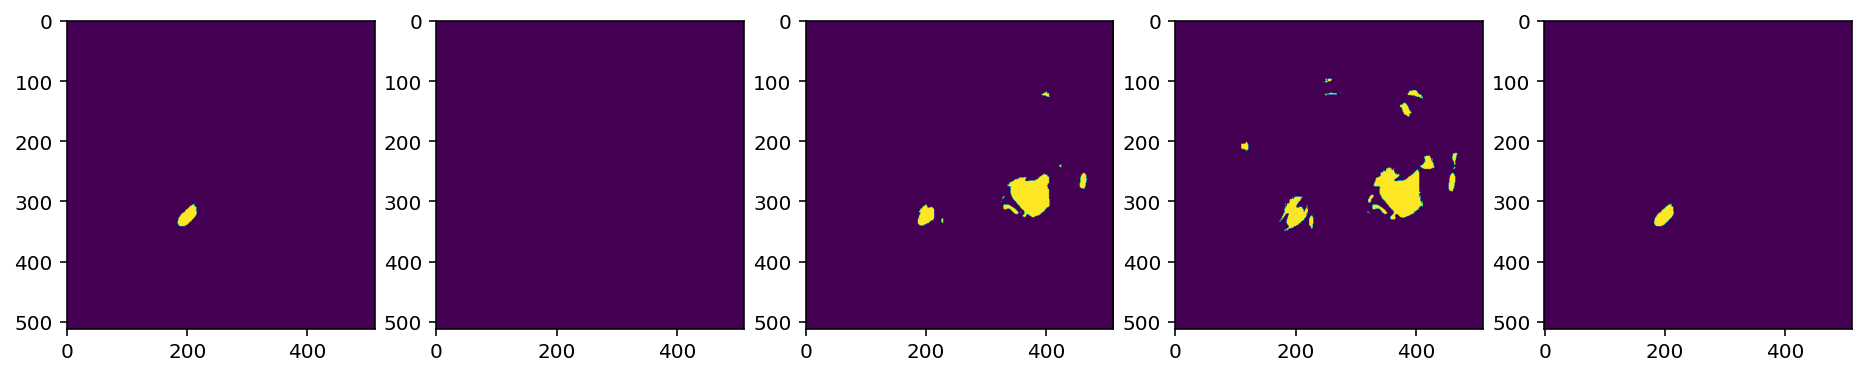

0.9144080581144369


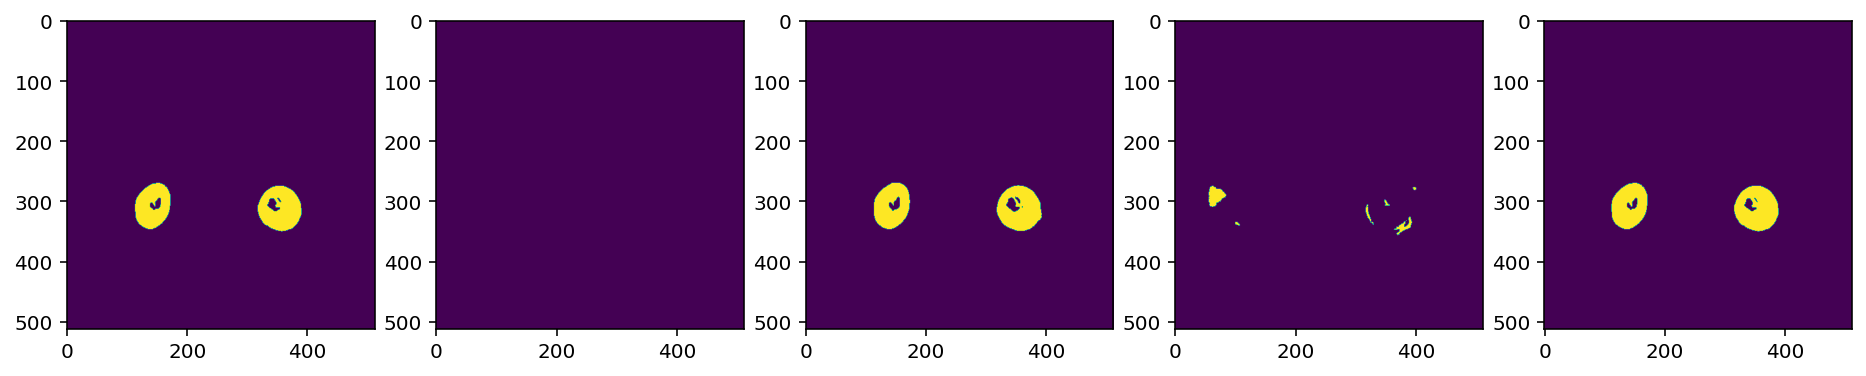

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 0.723655 	Validation Loss: 0.724621
Validation loss decreased (99.000000 --> 0.724621).  Saving model ...


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9281711918118312


0.49886226654052734


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.652102 	Validation Loss: 0.686295
Validation loss decreased (0.724621 --> 0.686295).  Saving model ...


  0%|          | 0/5813 [00:00<?, ?it/s]

0.6867595420295831


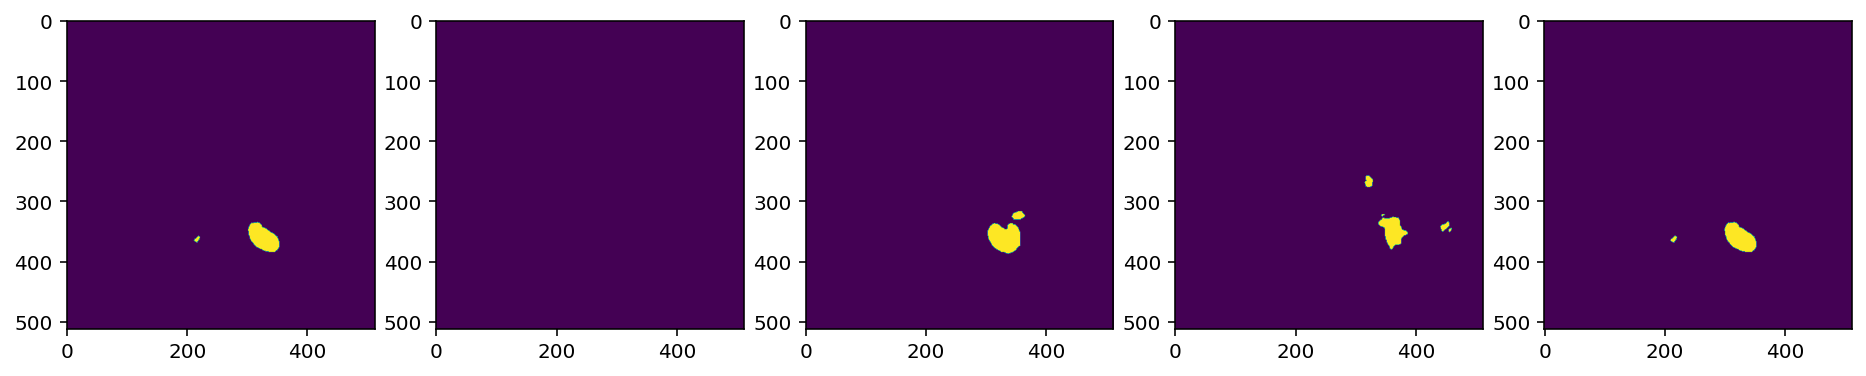

0.6665468258601928


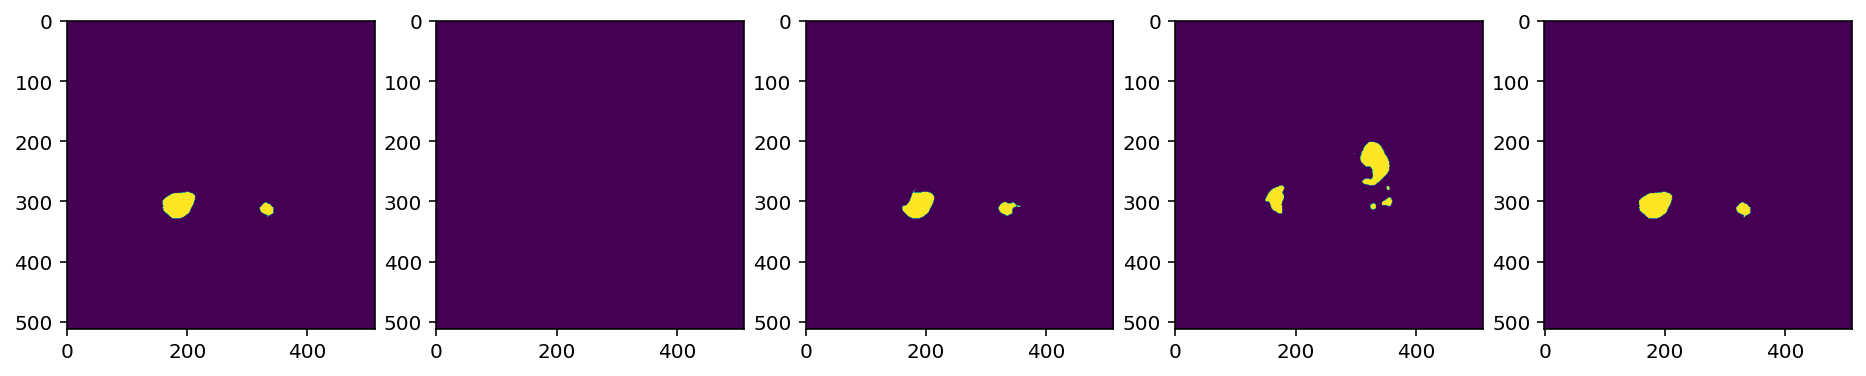

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.629425 	Validation Loss: 0.710835


  0%|          | 0/5813 [00:00<?, ?it/s]

0.4945850372314453


0.5511093759781747


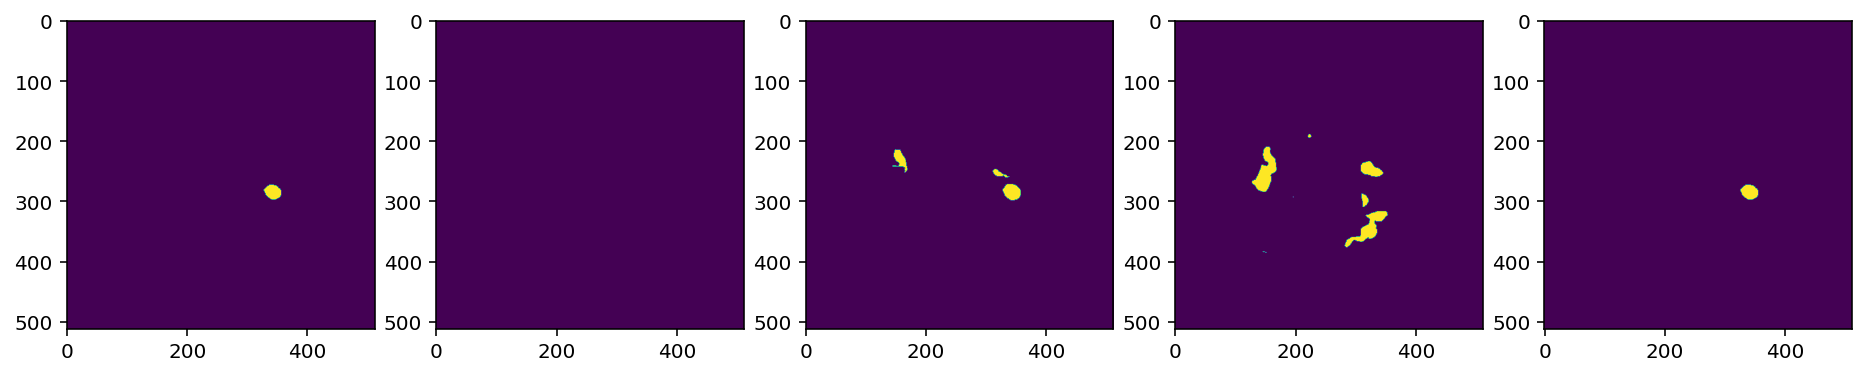

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.616467 	Validation Loss: 0.735112


  0%|          | 0/5813 [00:00<?, ?it/s]

0.4994020462036133


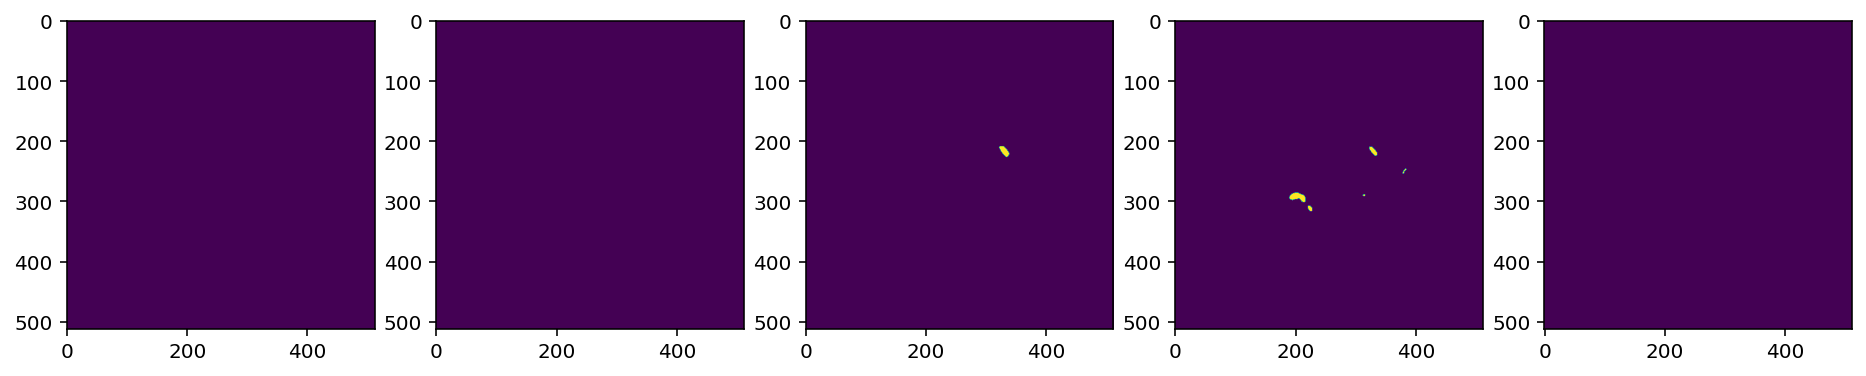

0.8977420388312729


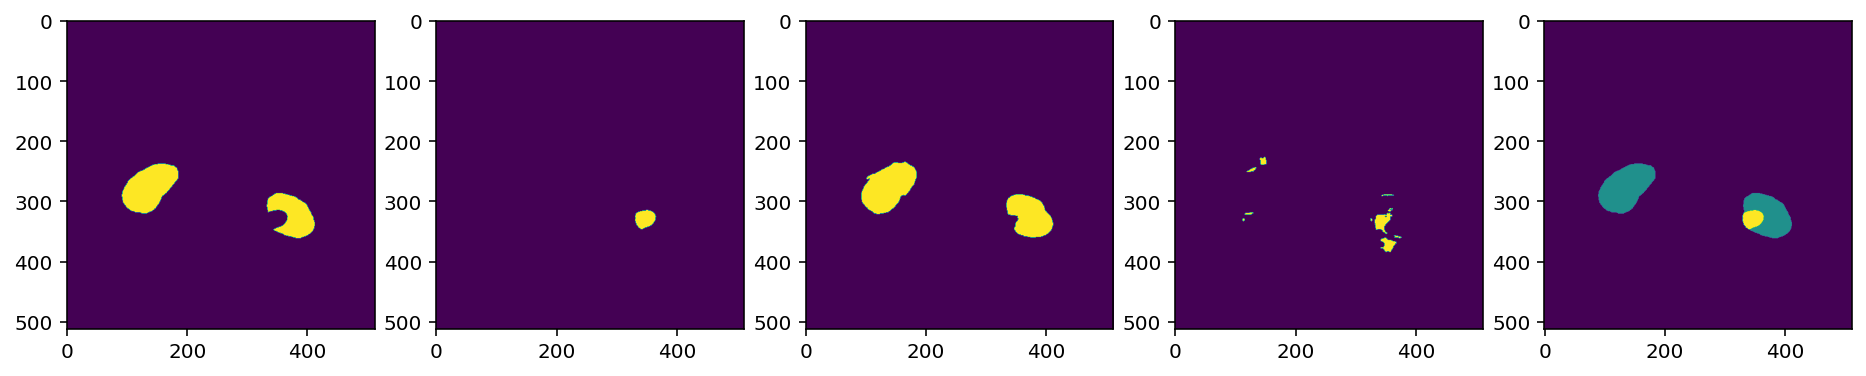

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.606021 	Validation Loss: 0.689557


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9087861961438154


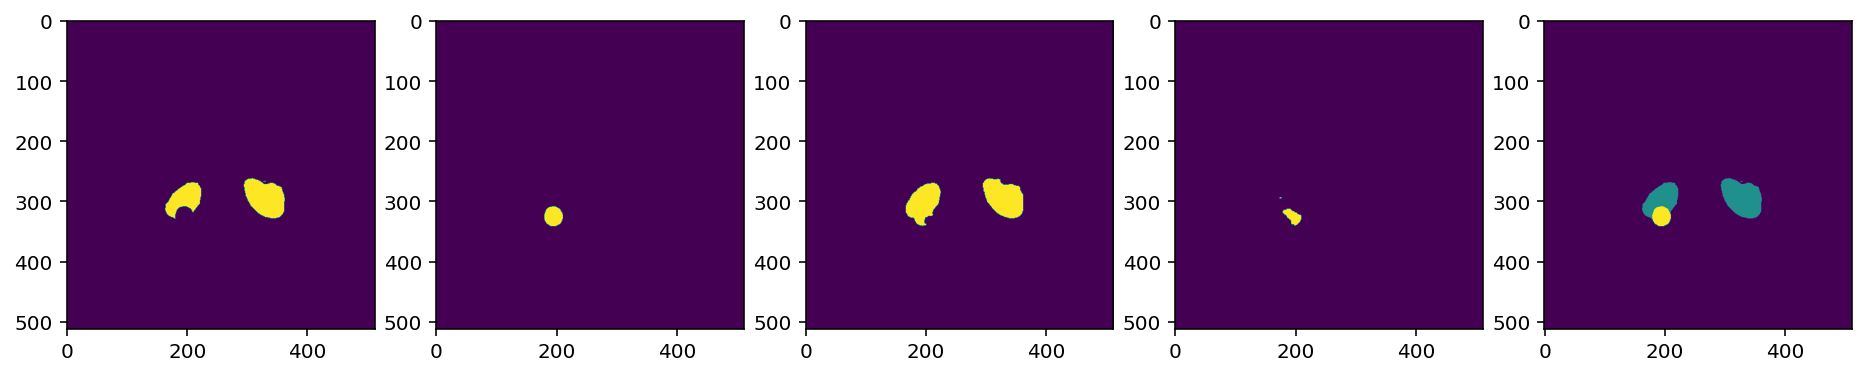

0.9409680910045295


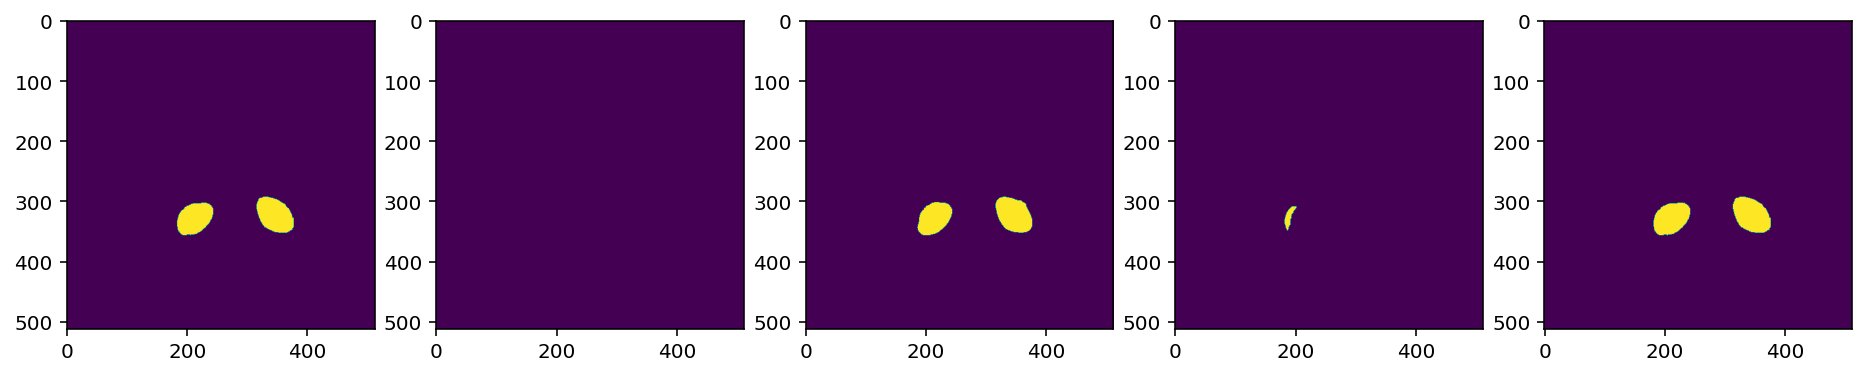

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.597210 	Validation Loss: 0.673858
Validation loss decreased (0.686295 --> 0.673858).  Saving model ...


  0%|          | 0/5813 [00:00<?, ?it/s]

0.5296763491738683


0.9498474872050056


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.590935 	Validation Loss: 0.692322


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9847385566371671


0.49271392822265625


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.587103 	Validation Loss: 0.705588


  0%|          | 0/5813 [00:00<?, ?it/s]

0.49933719635009766


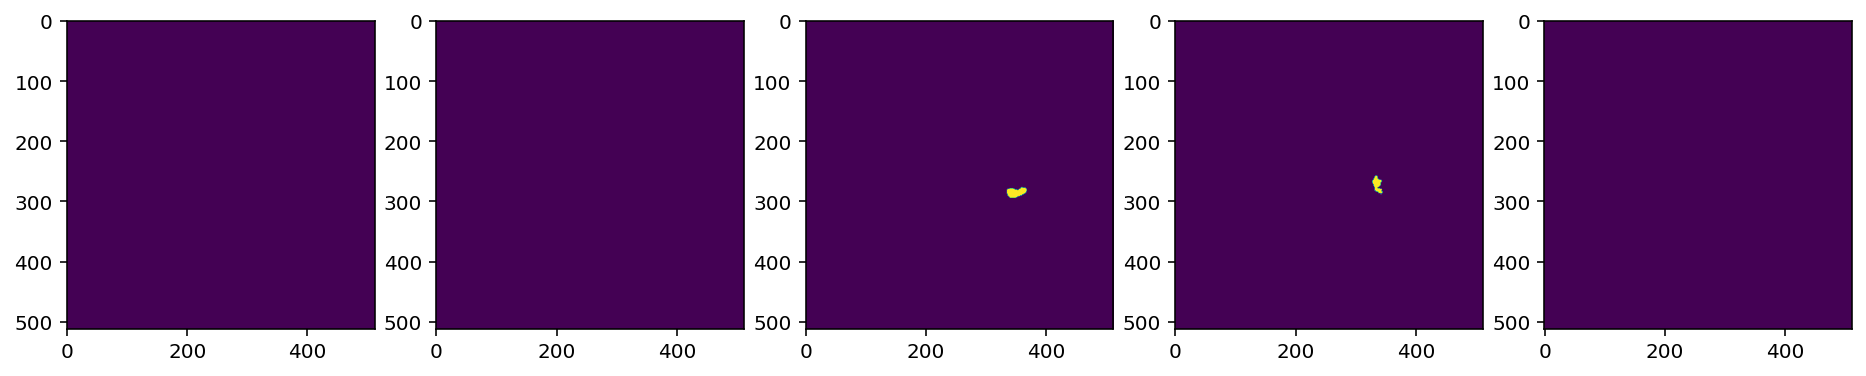

0.49457550048828125


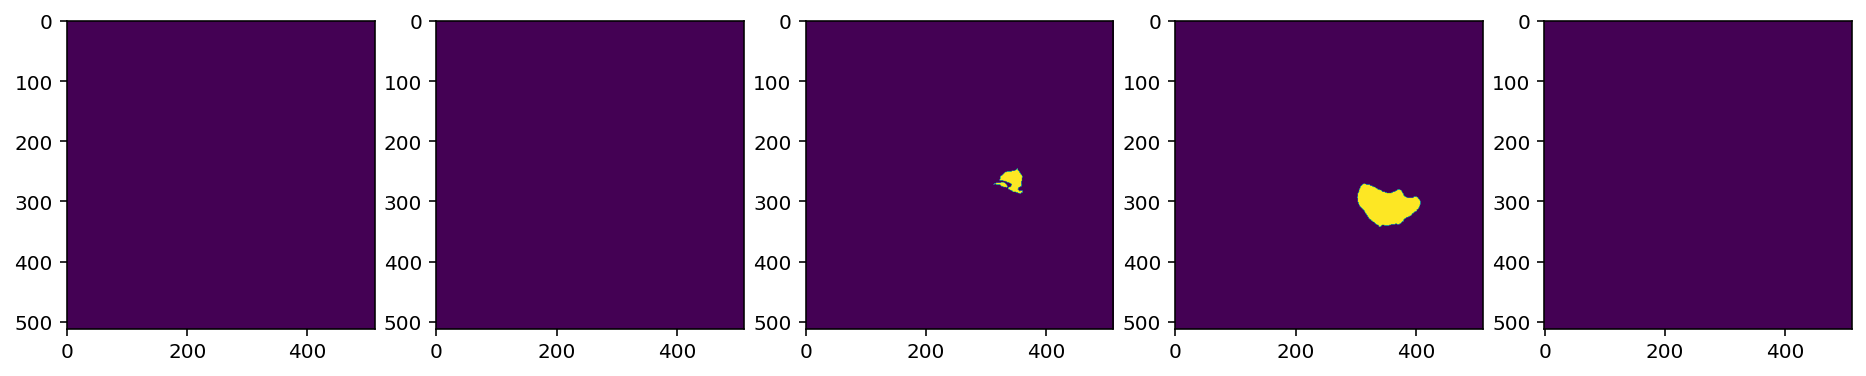

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.578221 	Validation Loss: 0.671240
Validation loss decreased (0.673858 --> 0.671240).  Saving model ...


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9845637697946443


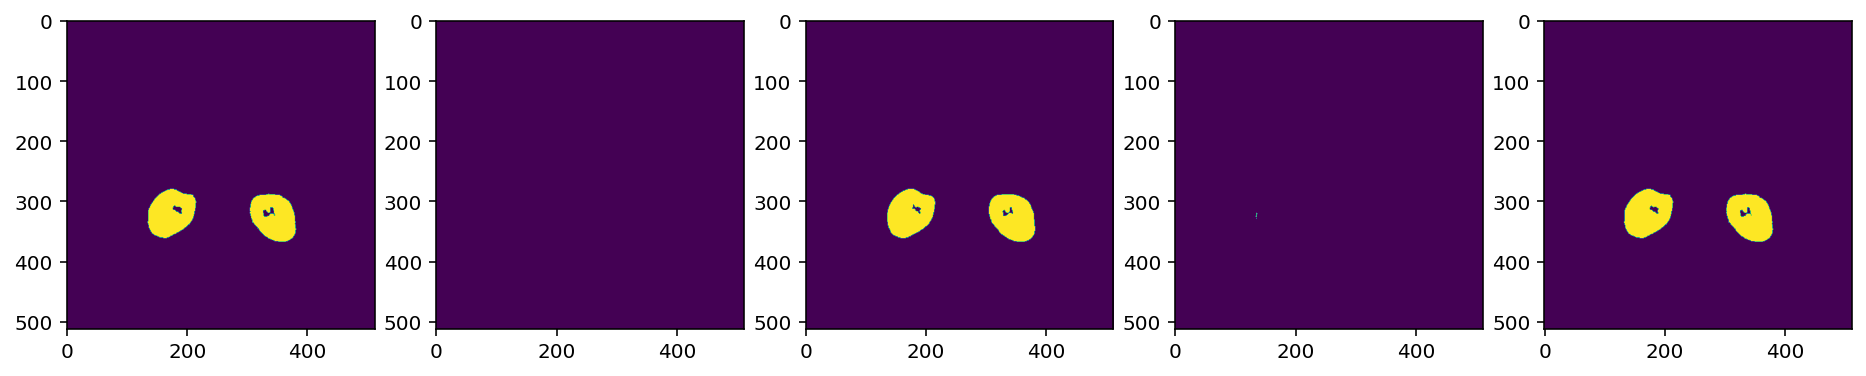

0.9488240220579518


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.575680 	Validation Loss: 0.665141
Validation loss decreased (0.671240 --> 0.665141).  Saving model ...


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9152155552895627


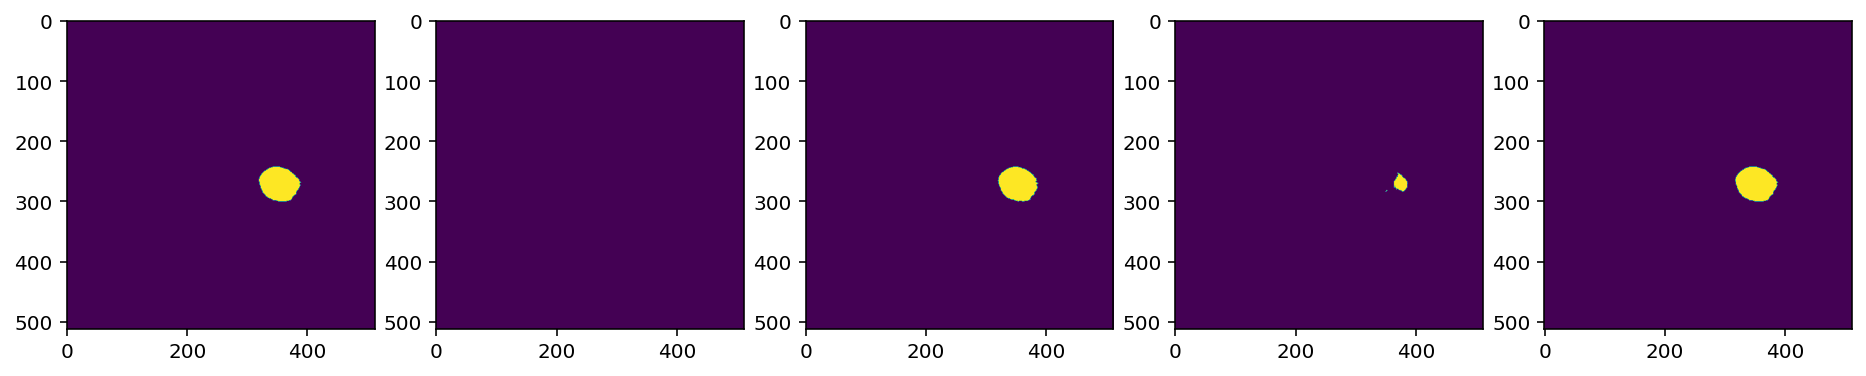

0.9646550867595881


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.571670 	Validation Loss: 0.671640


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9589656780835605


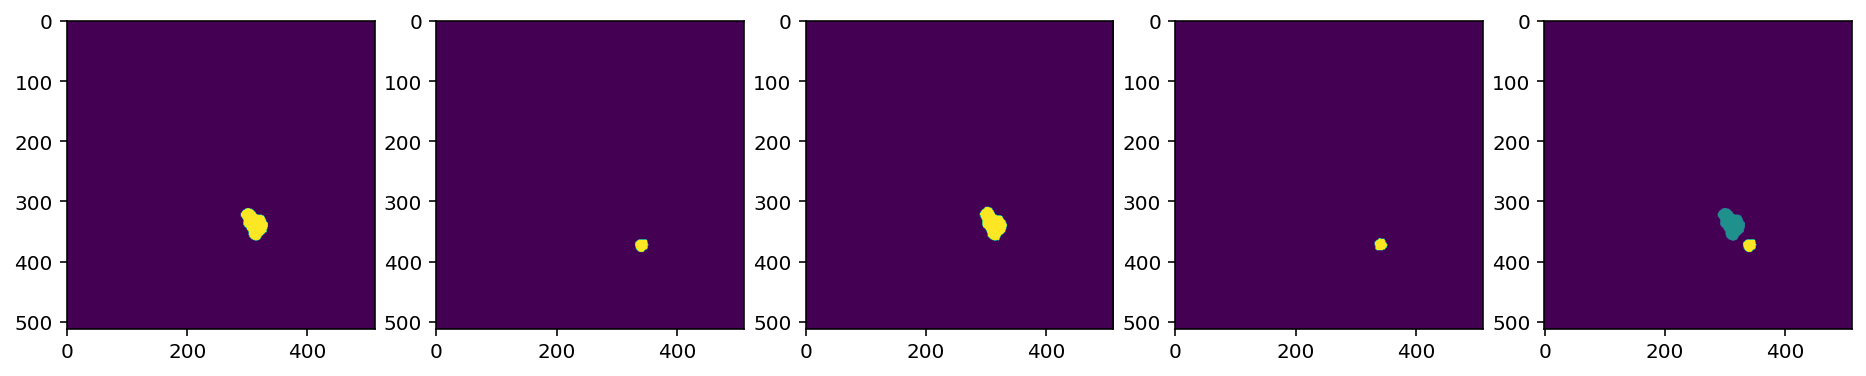

0.9779180756680608


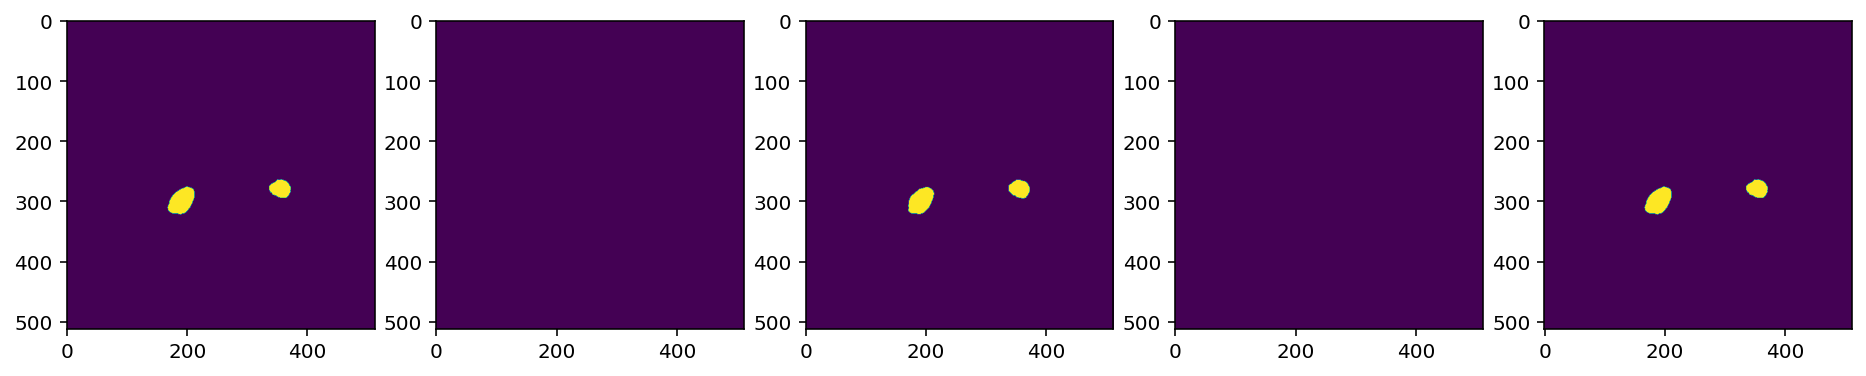

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.567753 	Validation Loss: 0.721138


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9653108874118614


0.994128223439225


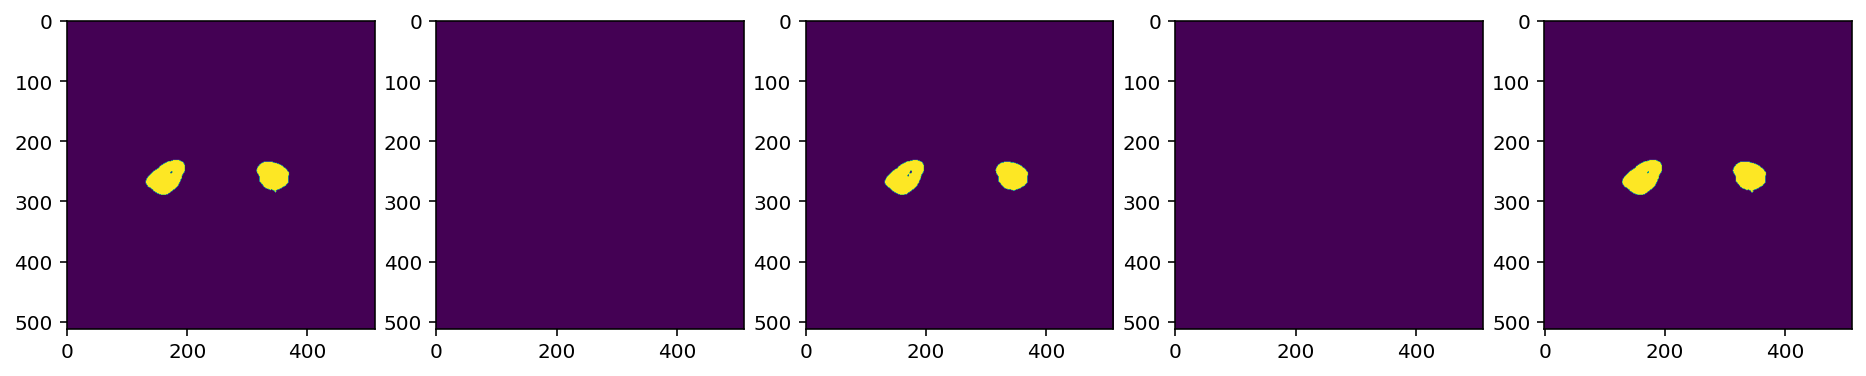

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.563751 	Validation Loss: 0.671293


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9768509836377317


0.9853707019149298


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.560493 	Validation Loss: 0.671461


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9337953771499554


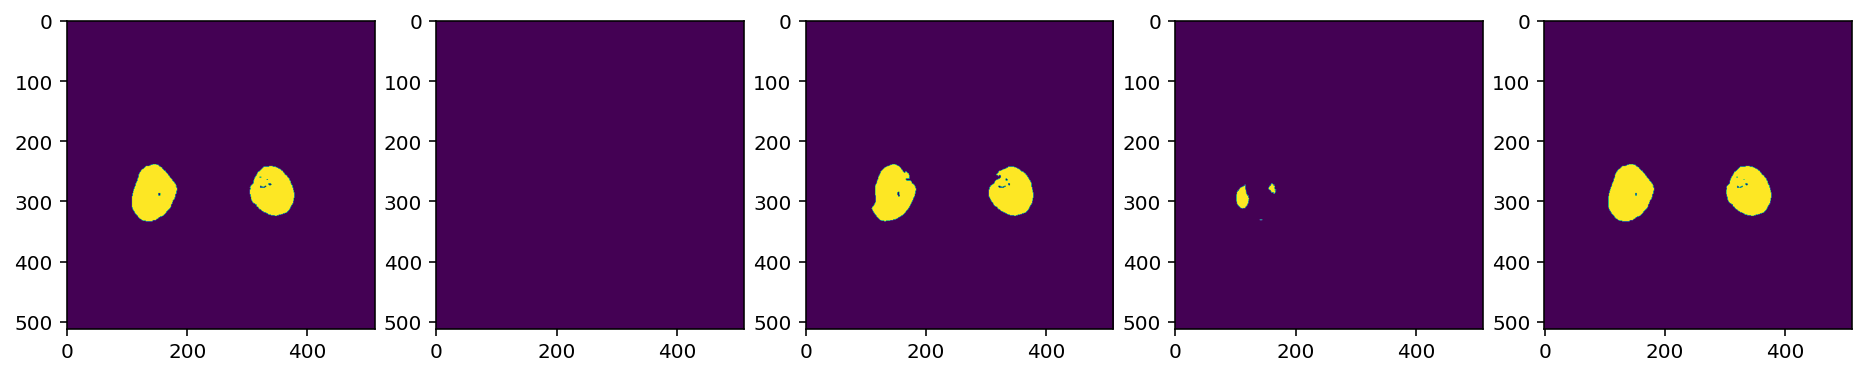

0.9822697066650421


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.558956 	Validation Loss: 0.668874


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9659431045020419


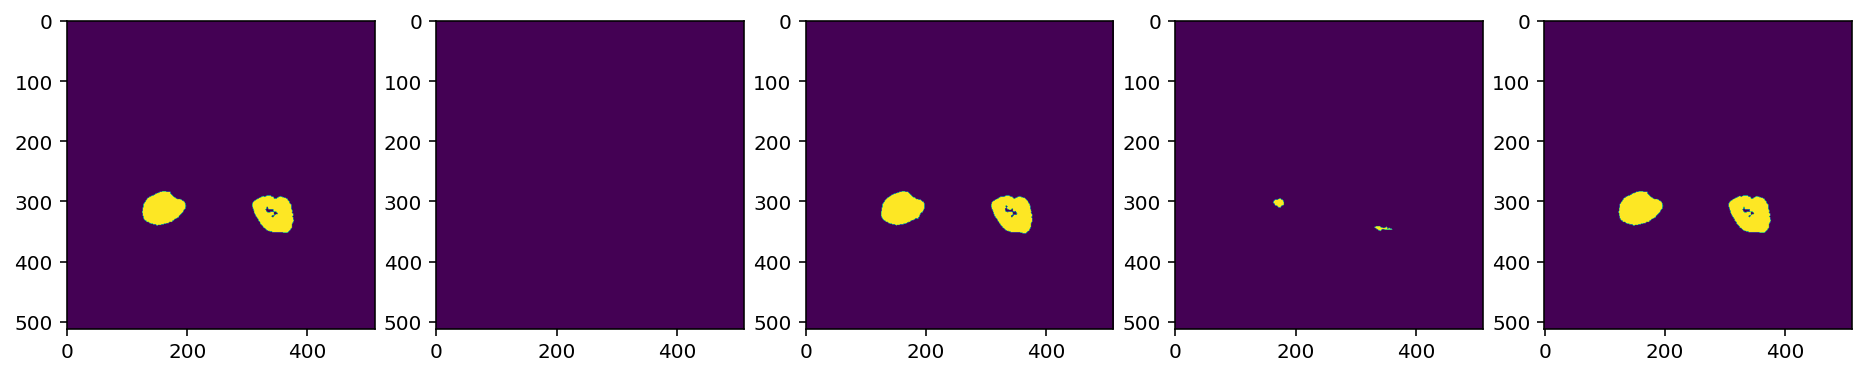

0.9722363258346386


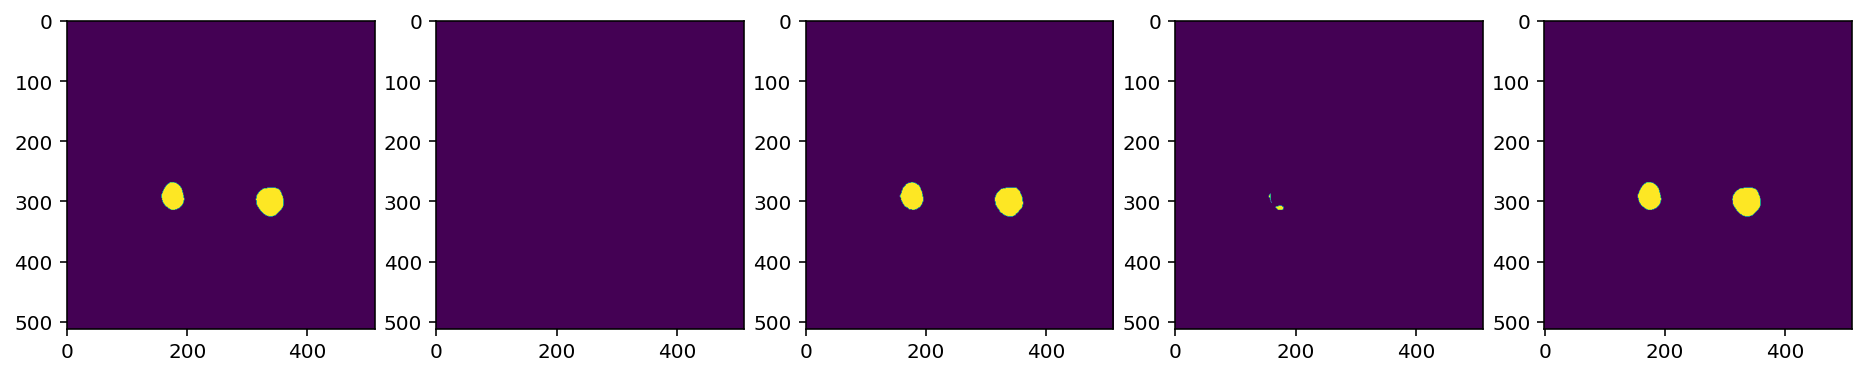

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.557058 	Validation Loss: 0.682077


  0%|          | 0/5813 [00:00<?, ?it/s]

0.961867805808651


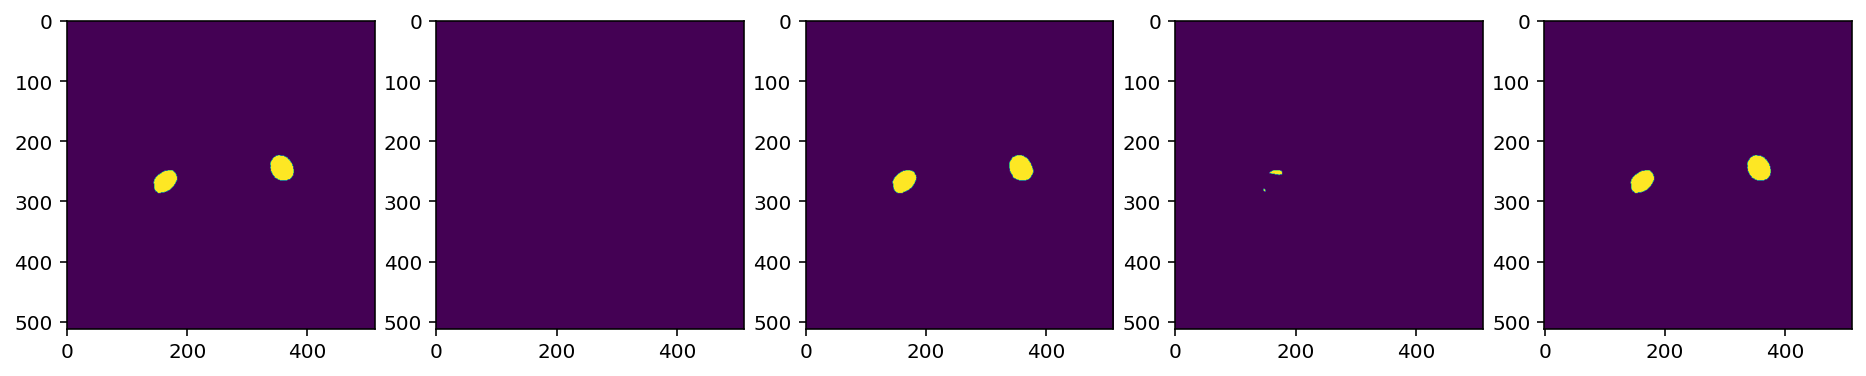

0.4993753433227539


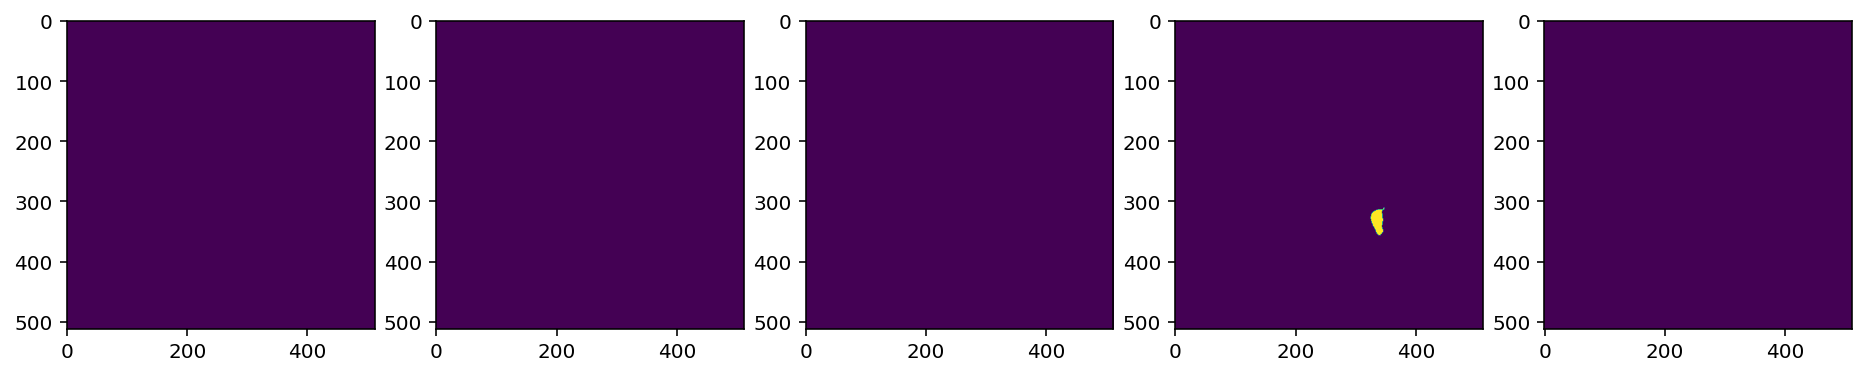

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.555502 	Validation Loss: 0.667855


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9743049911047537


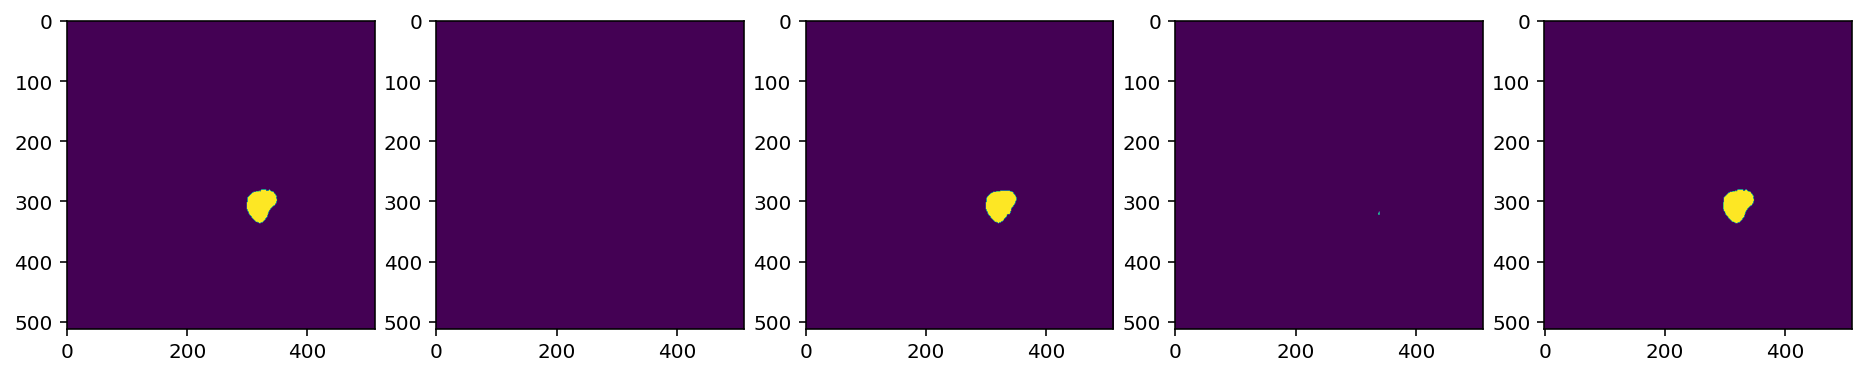

0.9607424546171945


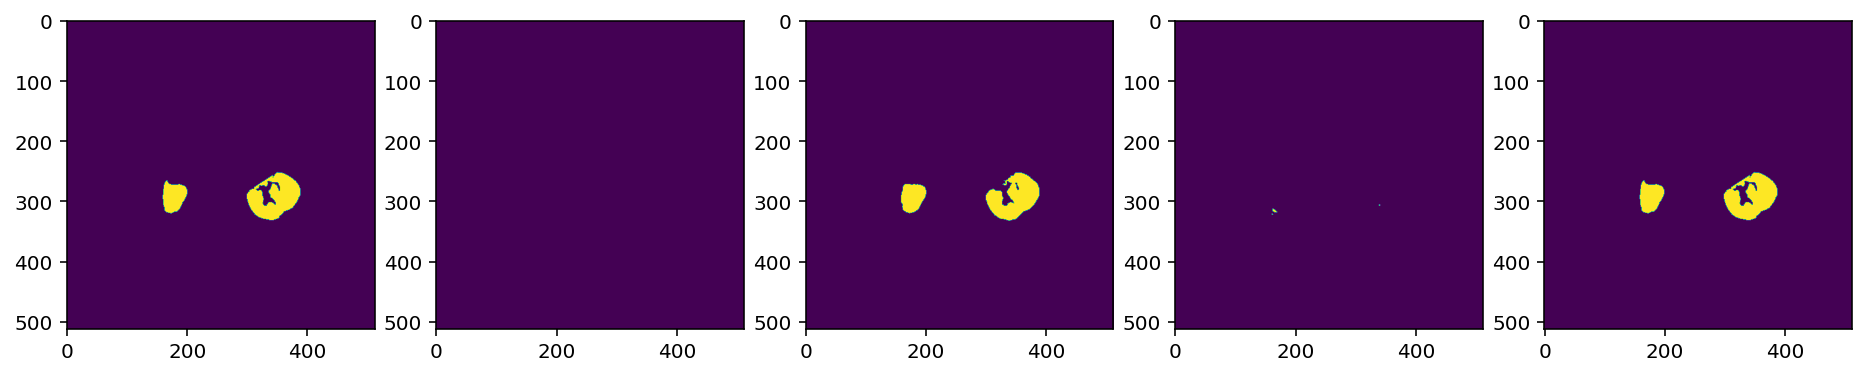

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.545533 	Validation Loss: 0.667521


  0%|          | 0/5813 [00:00<?, ?it/s]

0.4994087219238281


0.49850940704345703


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.542621 	Validation Loss: 0.669720


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9870163730247041


0.9771448234126415


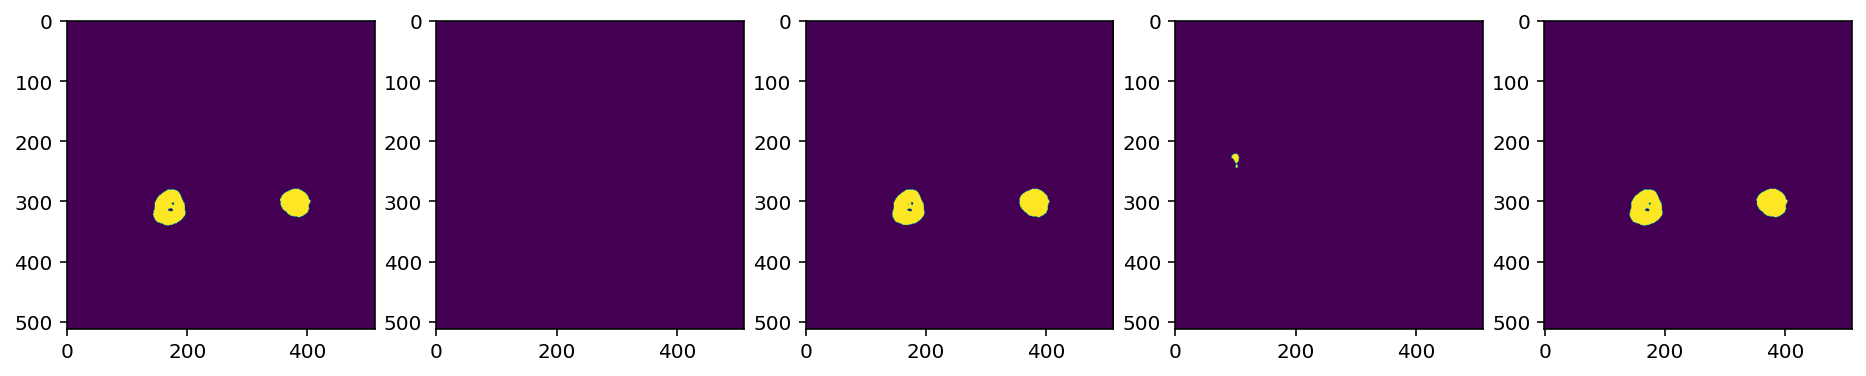

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.541181 	Validation Loss: 0.658061
Validation loss decreased (0.665141 --> 0.658061).  Saving model ...


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9532073371382154


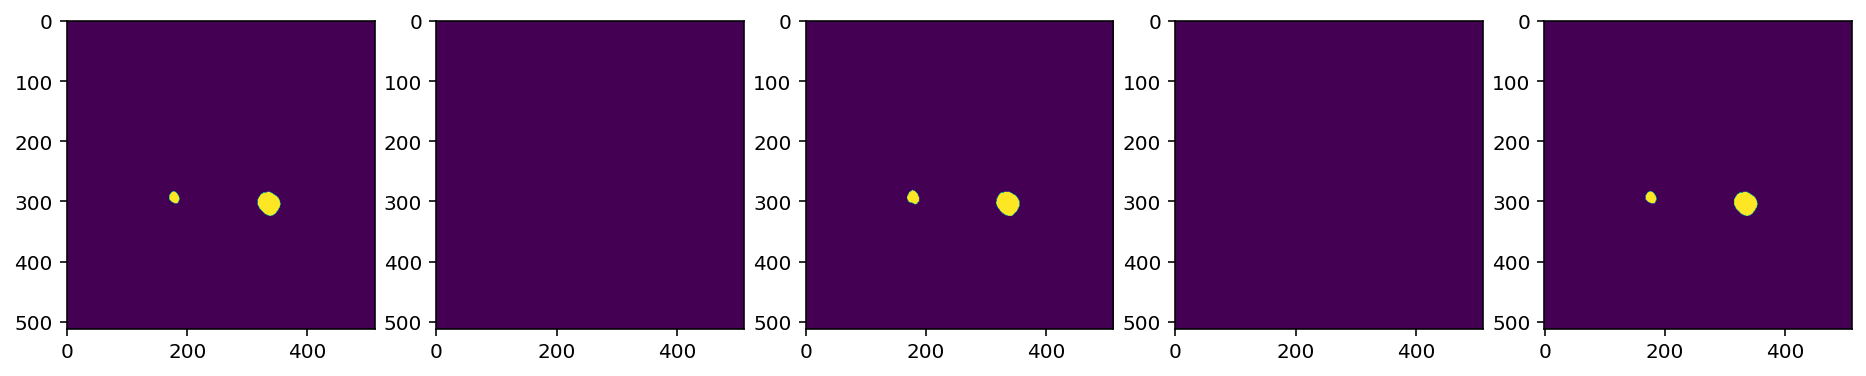

0.9895217678887454


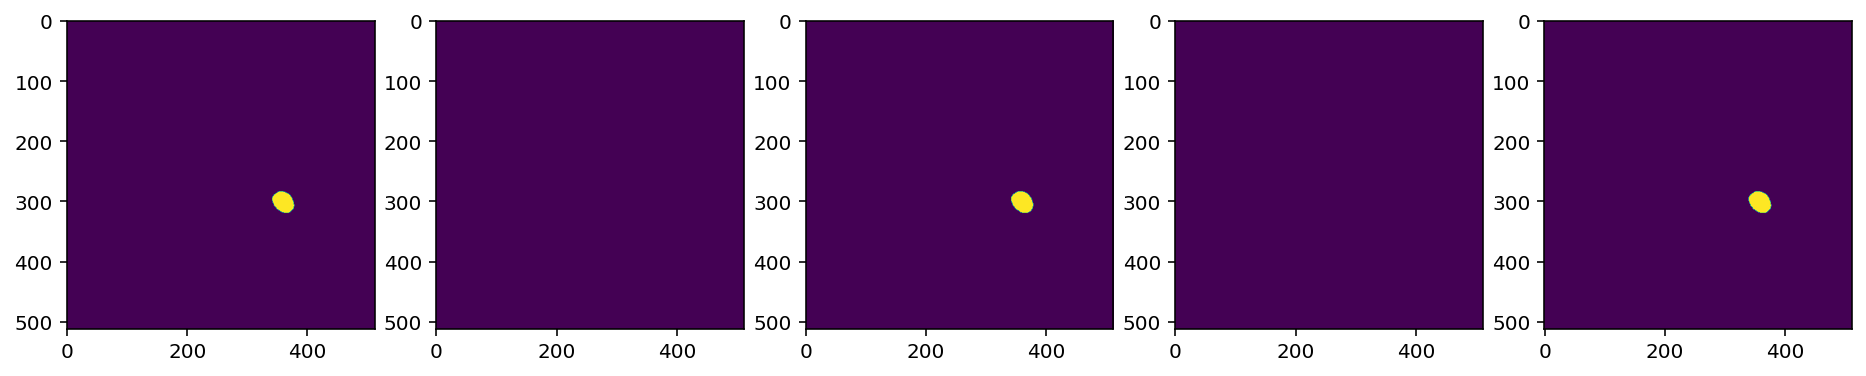

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.540459 	Validation Loss: 0.660750


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9915697520471507


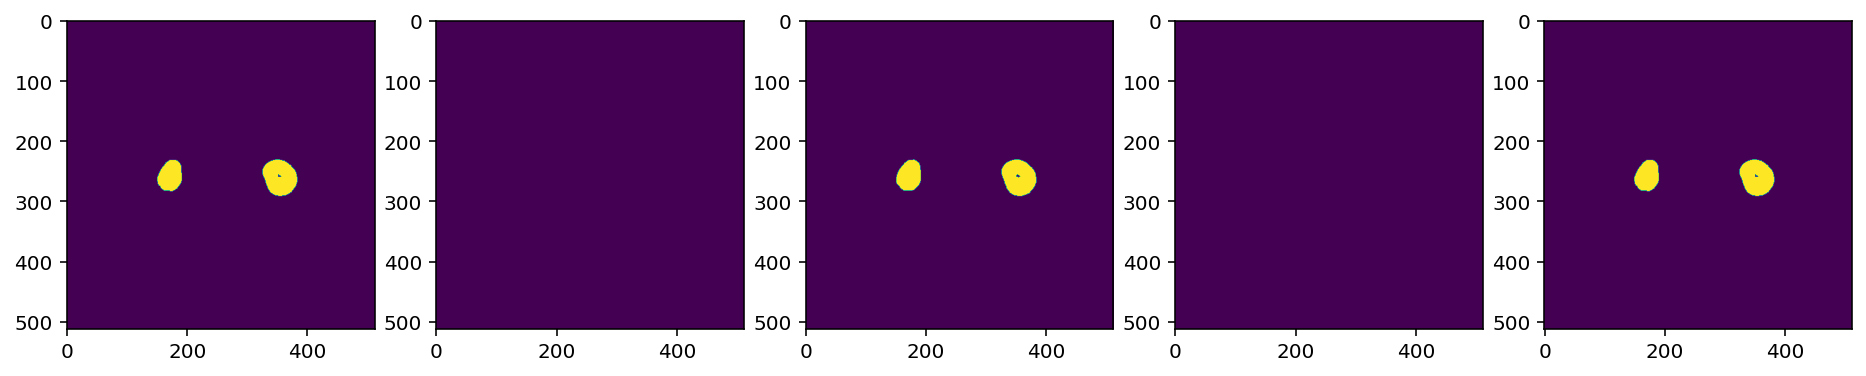

0.4997110366821289


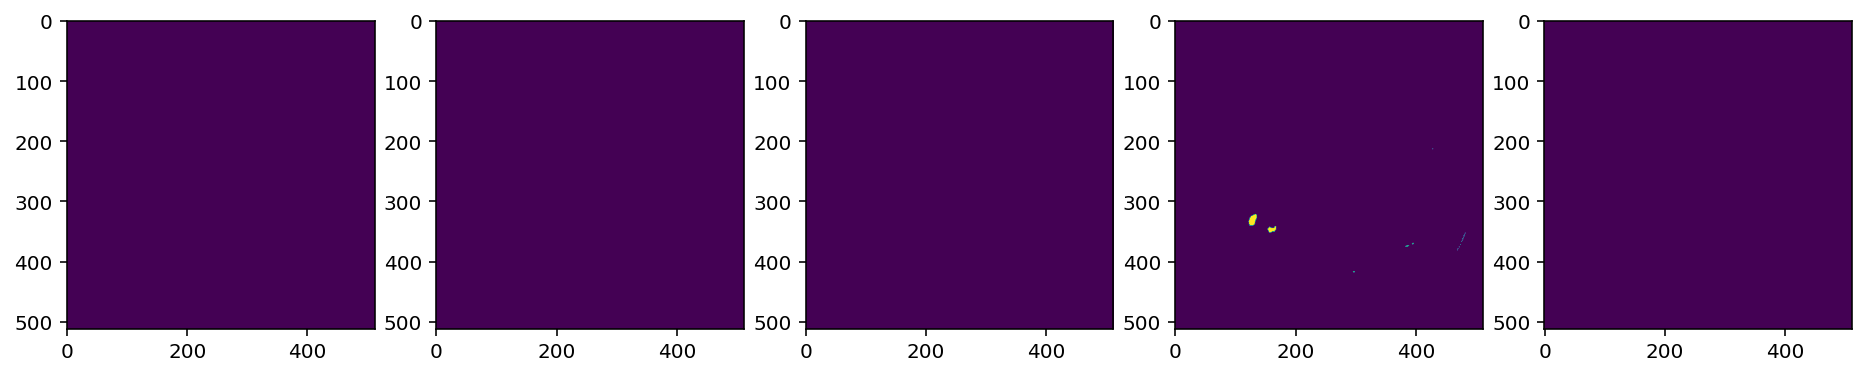

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.539325 	Validation Loss: 0.671887


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9874880180913923


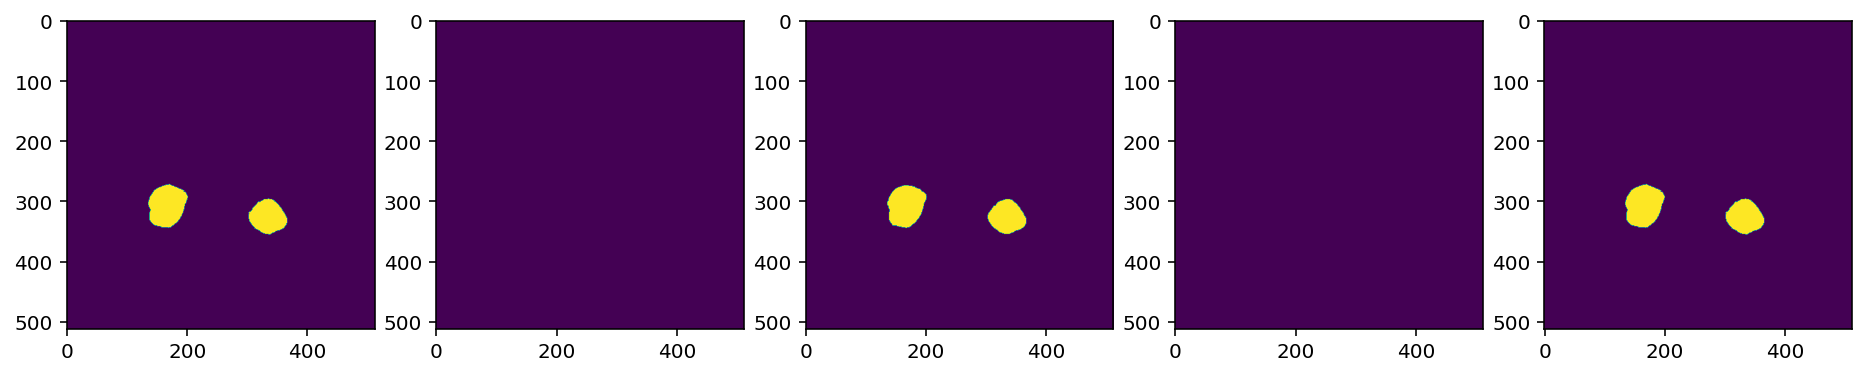

0.9552081937636355


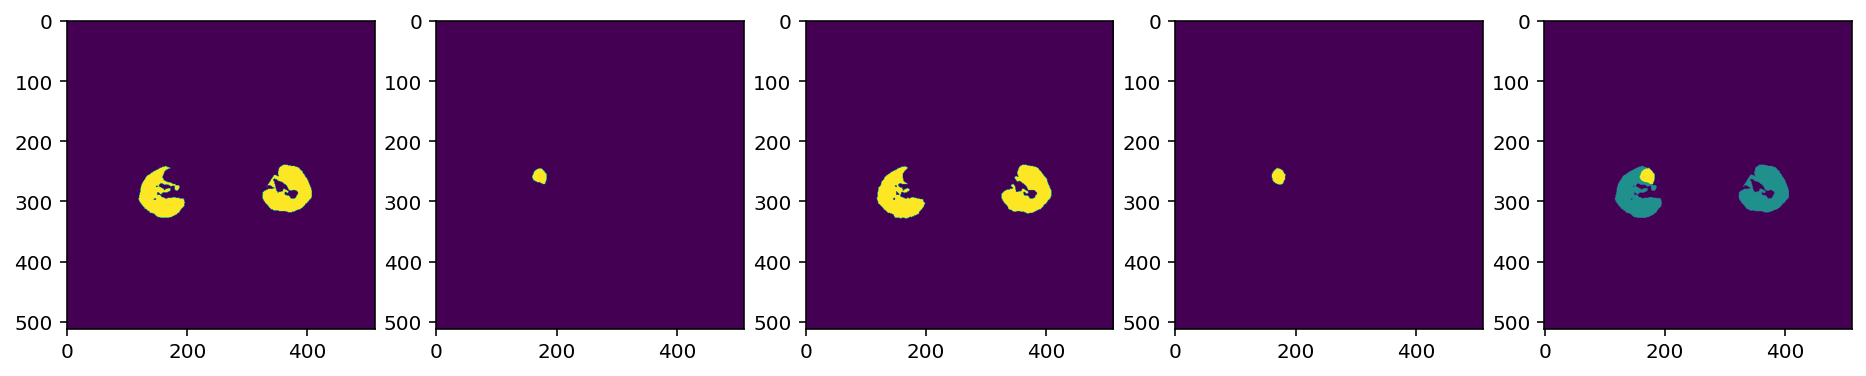

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.538789 	Validation Loss: 0.652412
Validation loss decreased (0.658061 --> 0.652412).  Saving model ...


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9401704545856269


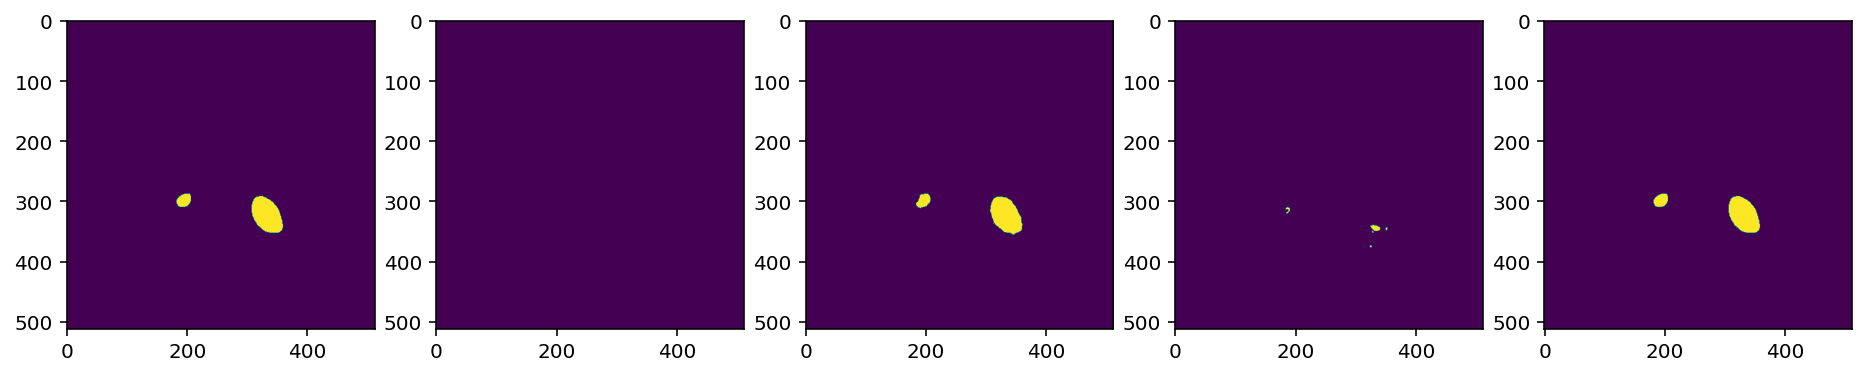

0.9912941610296468


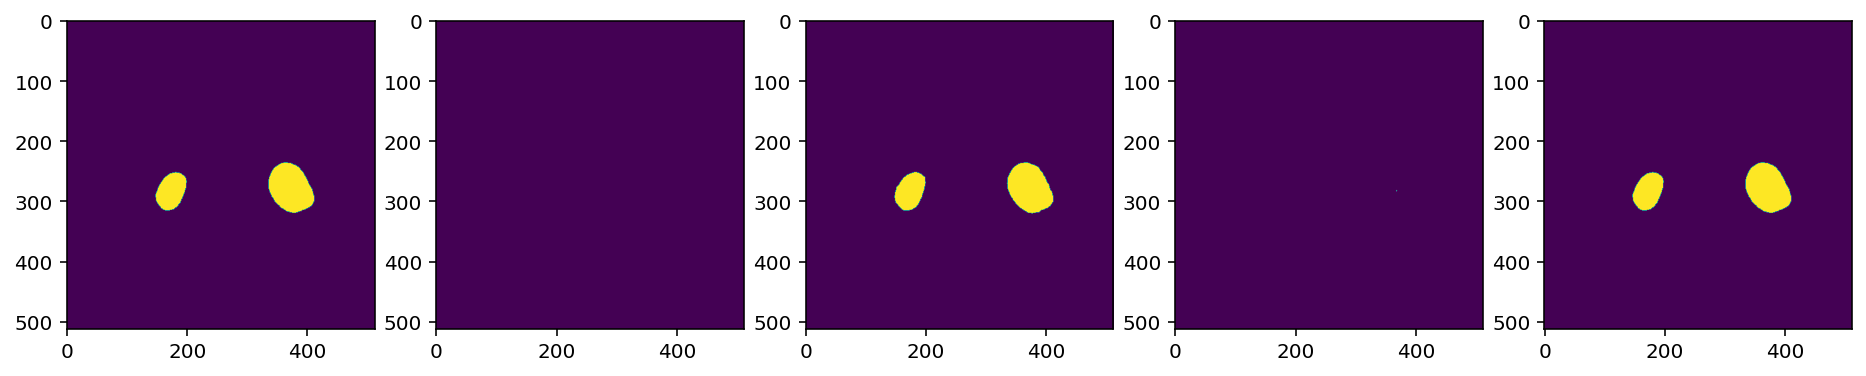

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.537982 	Validation Loss: 0.669579


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9504619951136146


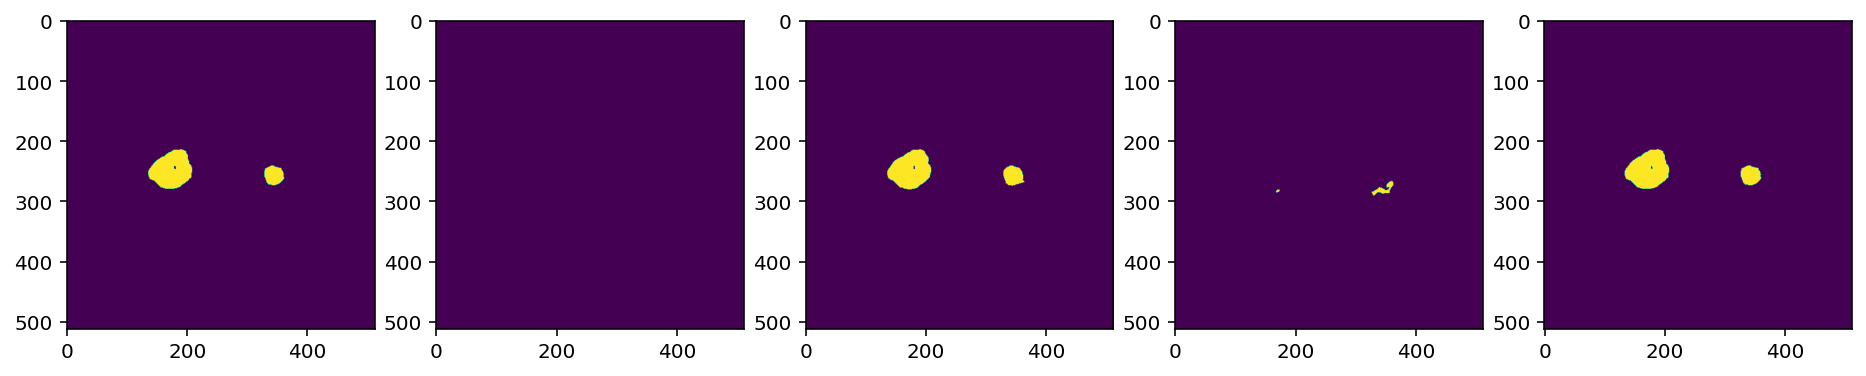

0.9809922760099936


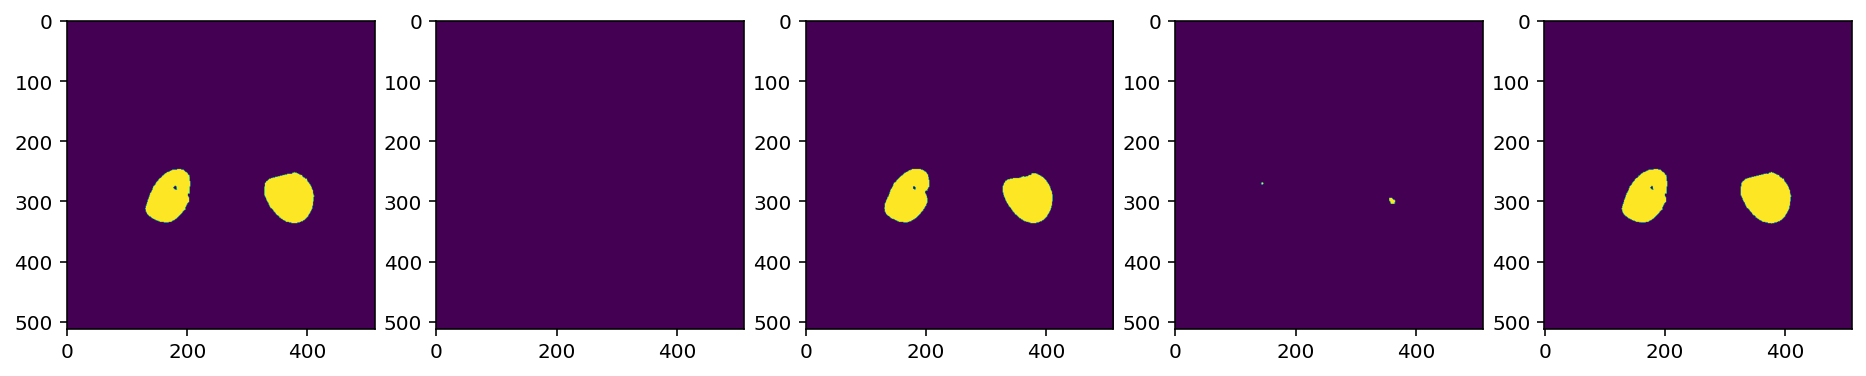

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.537382 	Validation Loss: 0.656009


  0%|          | 0/5813 [00:00<?, ?it/s]

0.7628906769053092


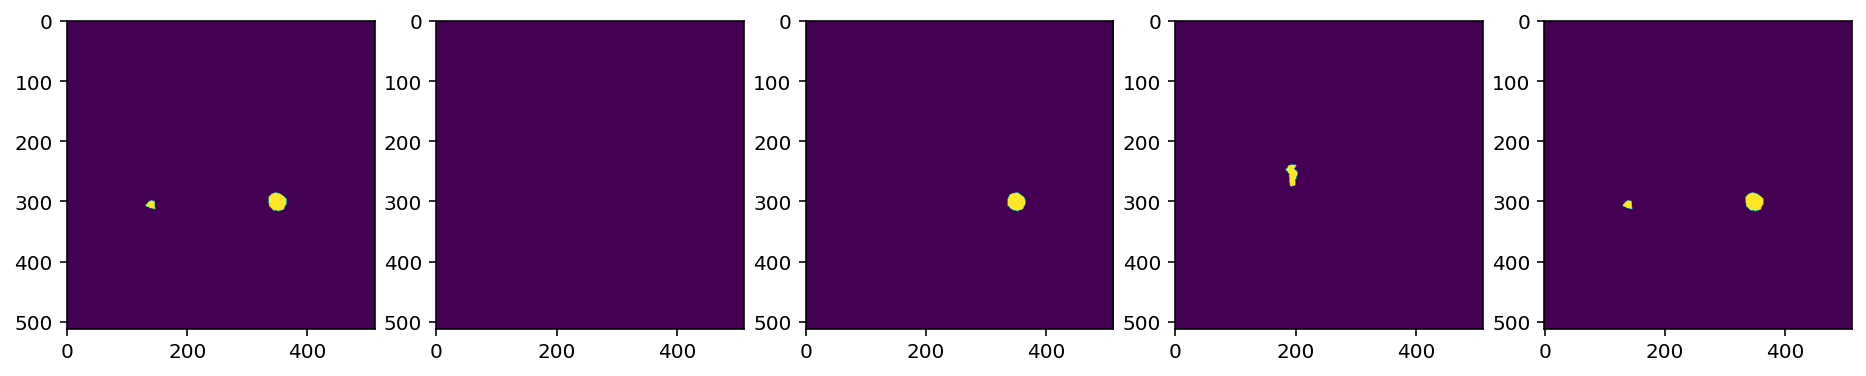

0.9712108366658228


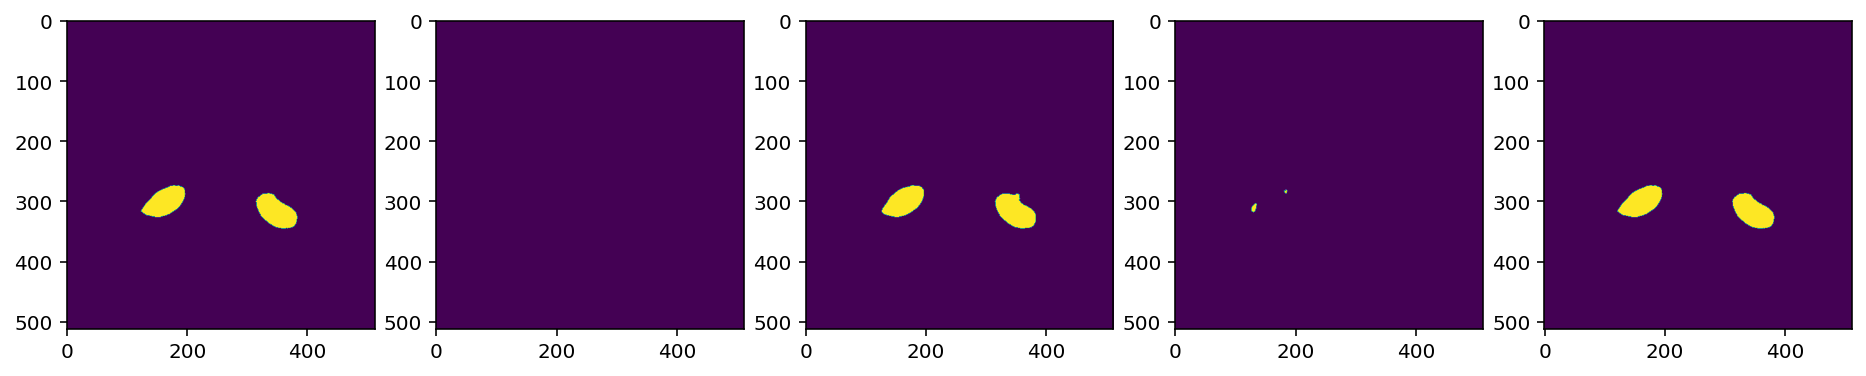

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.536903 	Validation Loss: 0.663784


  0%|          | 0/5813 [00:00<?, ?it/s]

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


0.9712543352522347


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.536437 	Validation Loss: 0.674892


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9757993463164812


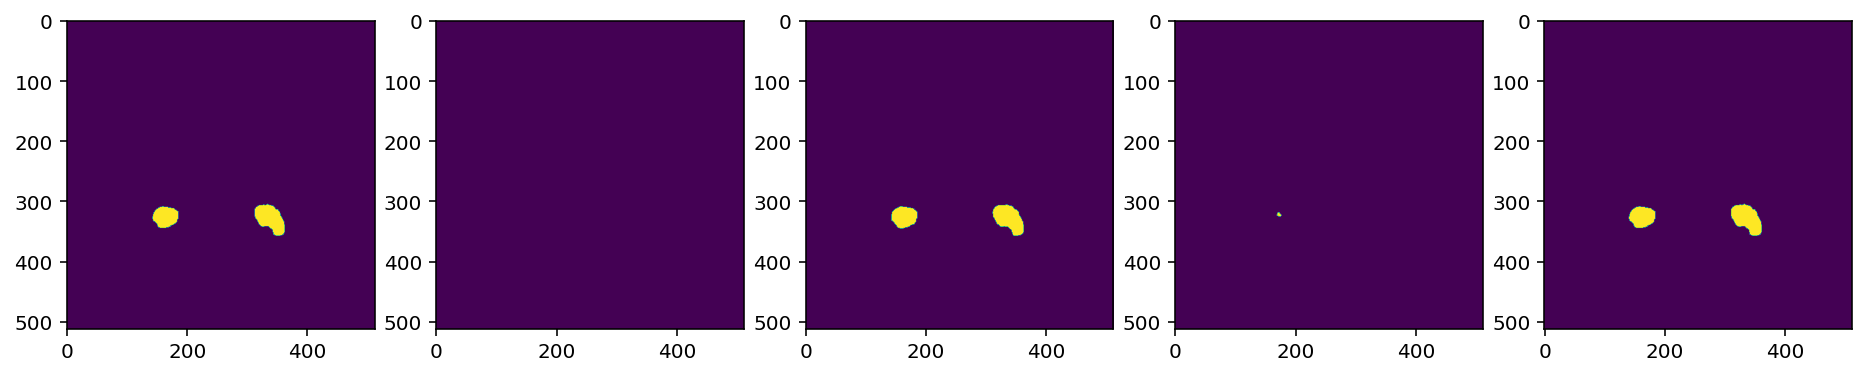

0.977477449335974


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.536138 	Validation Loss: 0.666711


  0%|          | 0/5813 [00:00<?, ?it/s]

0.990988002958703


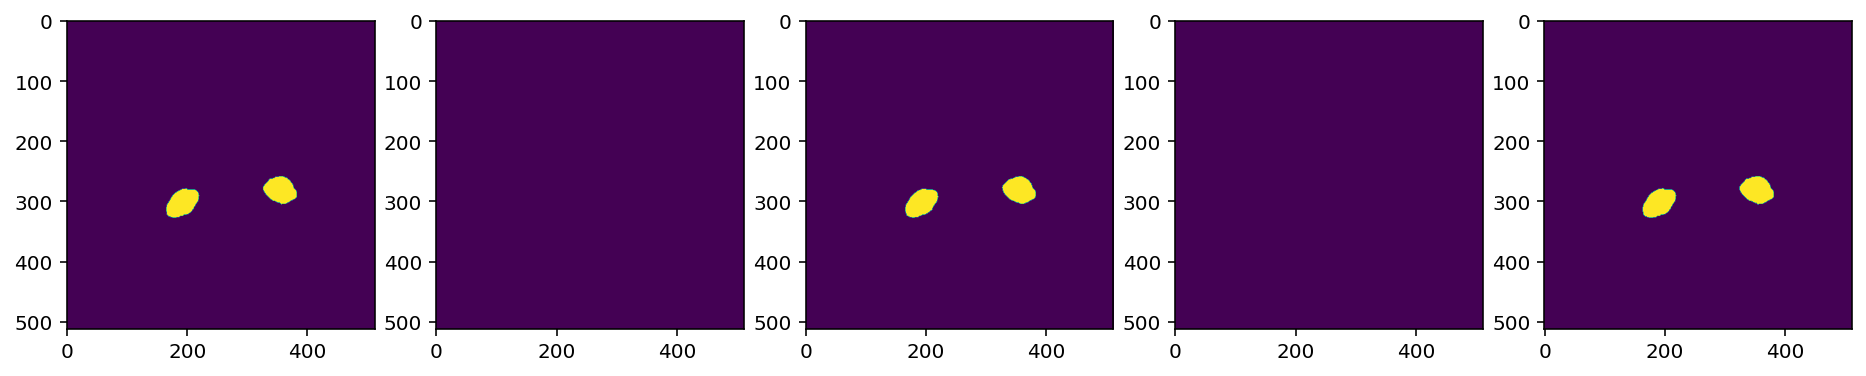

0.9837626912780675


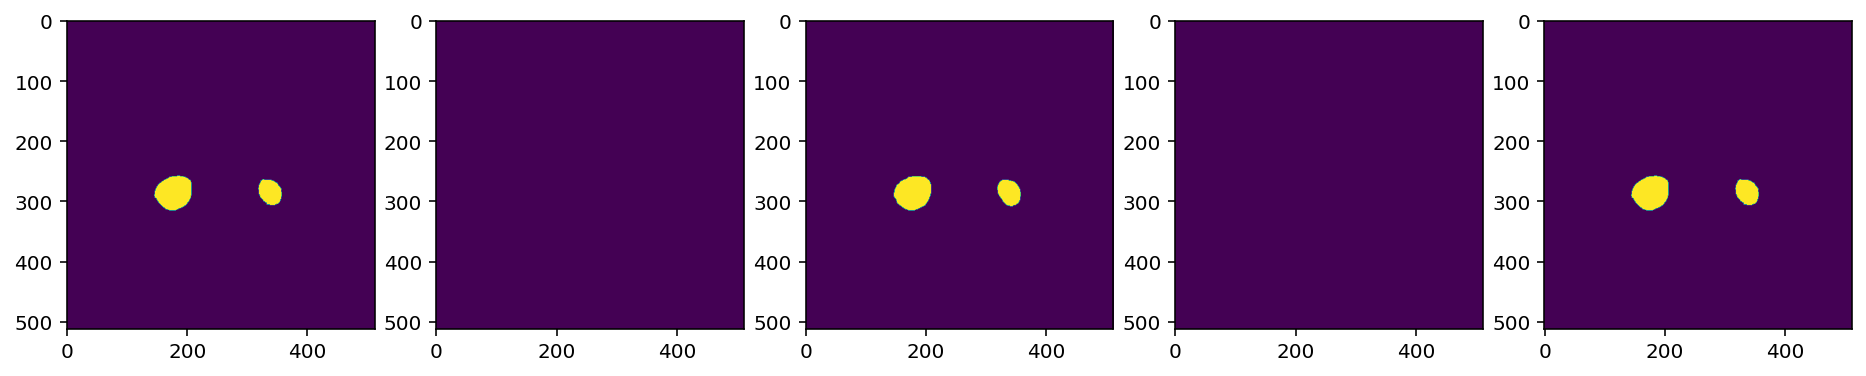

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.535428 	Validation Loss: 0.688530


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9566141354217255


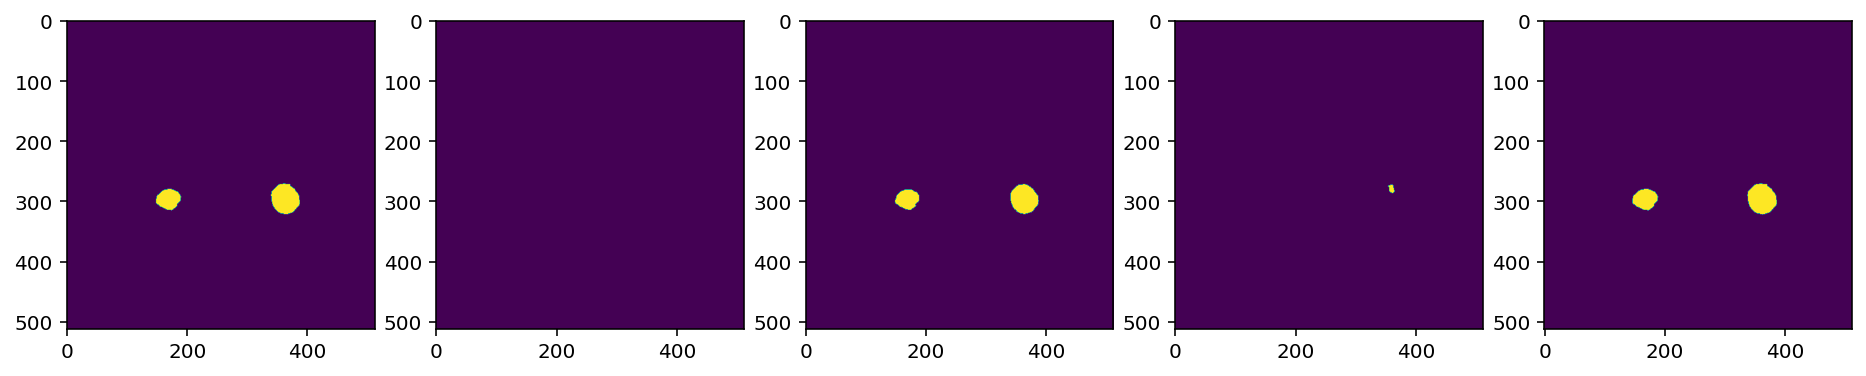

0.9800392630024355


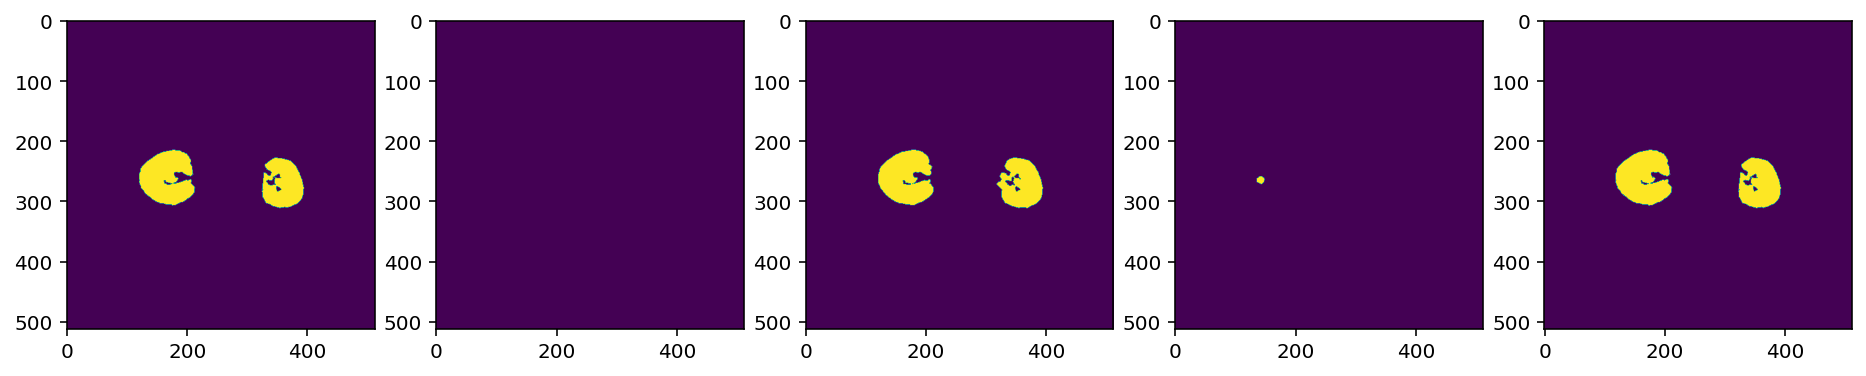

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.534941 	Validation Loss: 0.667585


  0%|          | 0/5813 [00:00<?, ?it/s]

0.49854373931884766


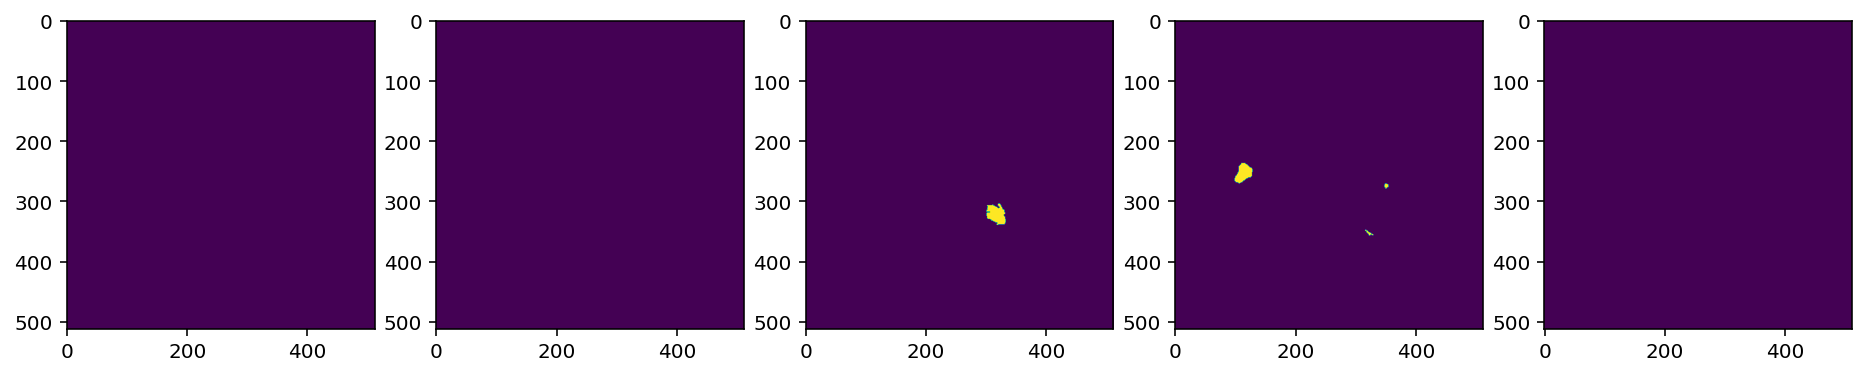

0.9877994022453559


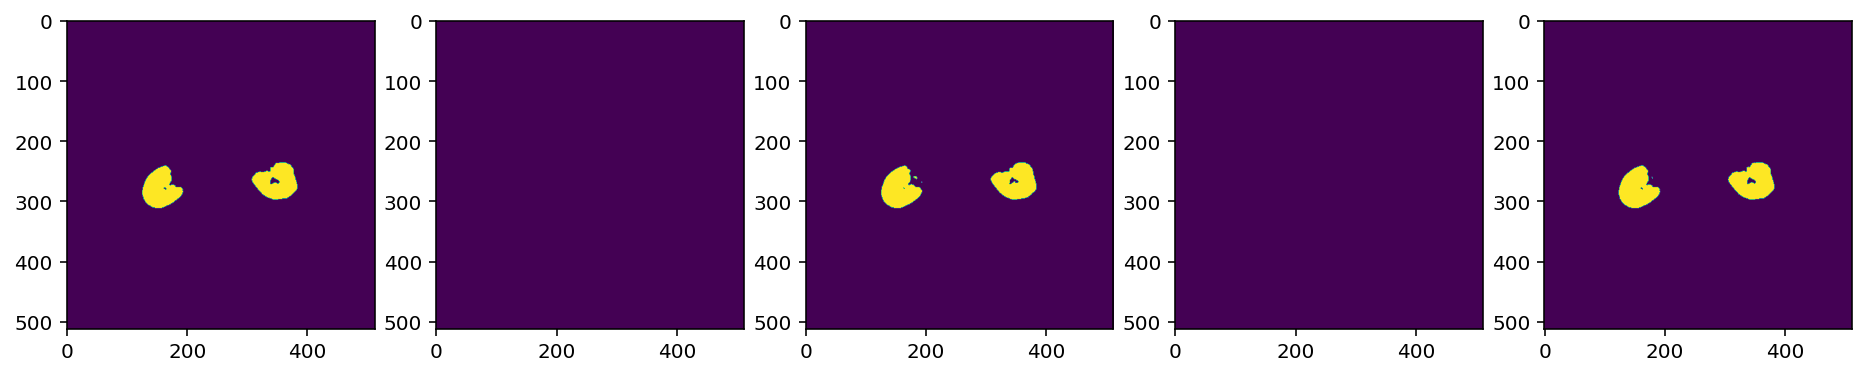

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.534213 	Validation Loss: 0.663632


  0%|          | 0/5813 [00:00<?, ?it/s]

0.49997997283935547


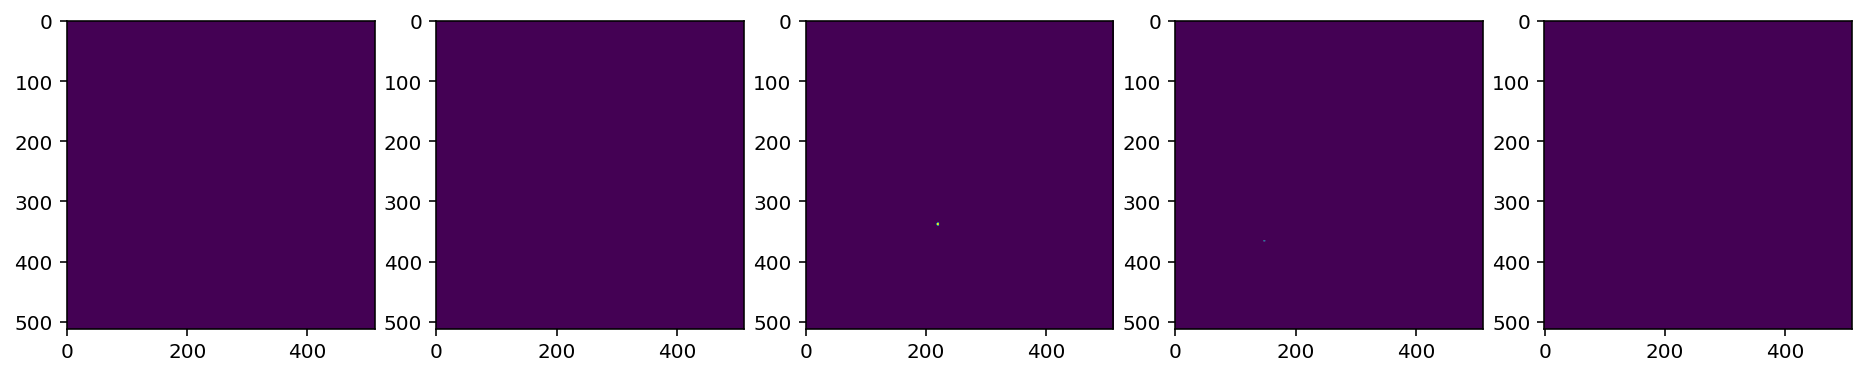

0.9682271214153195


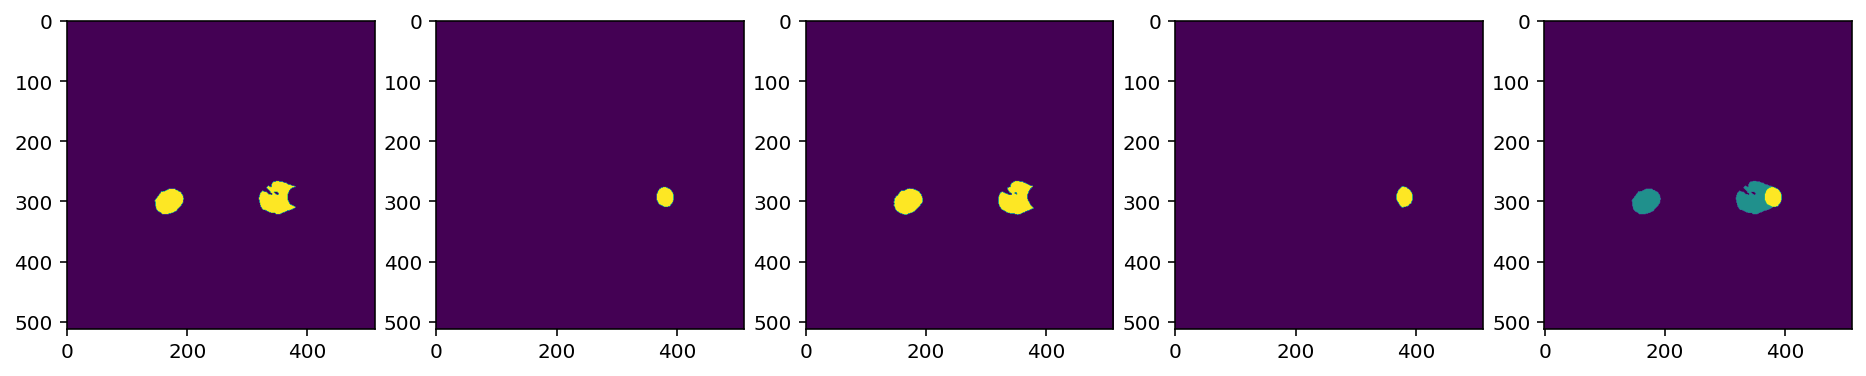

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.533665 	Validation Loss: 0.656098


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9776376834536785


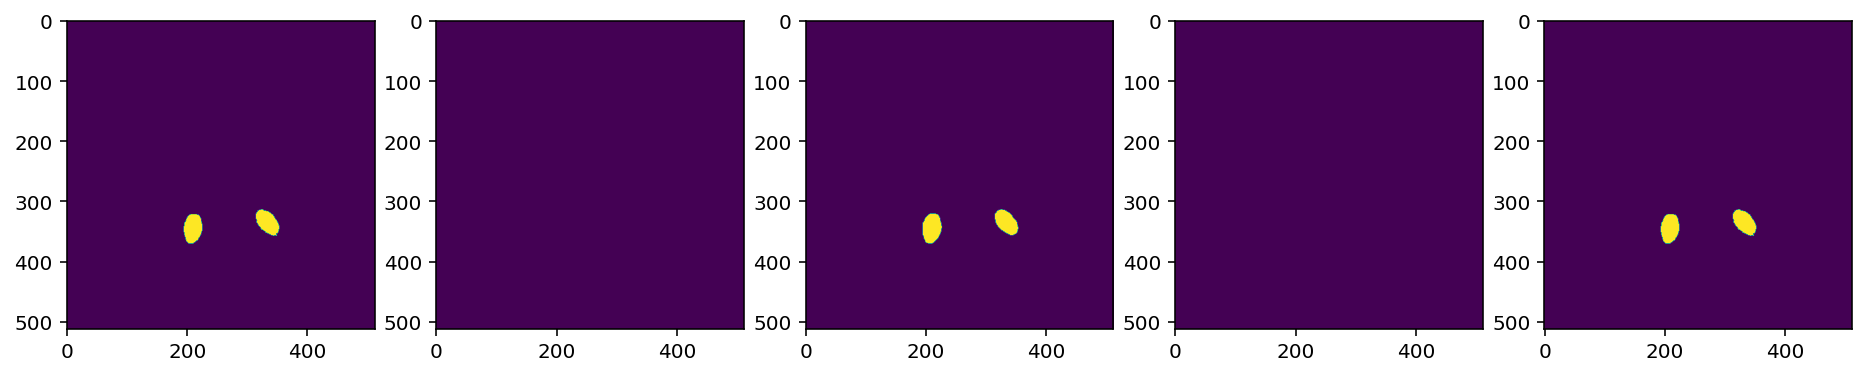

0.8790443261623775


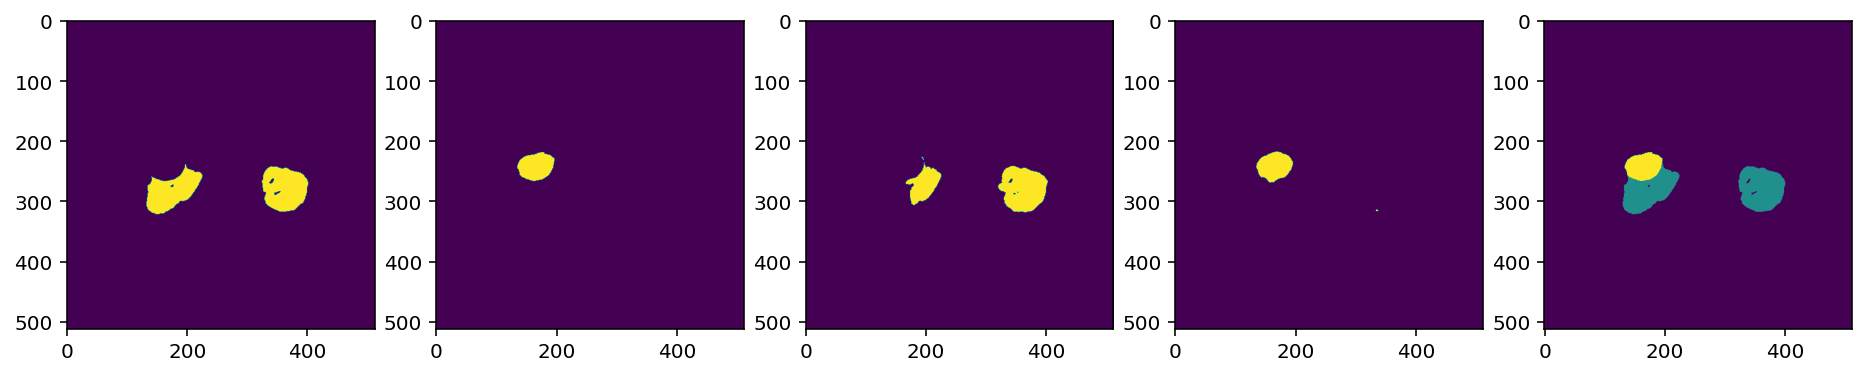

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.533407 	Validation Loss: 0.688777


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9687051154590248


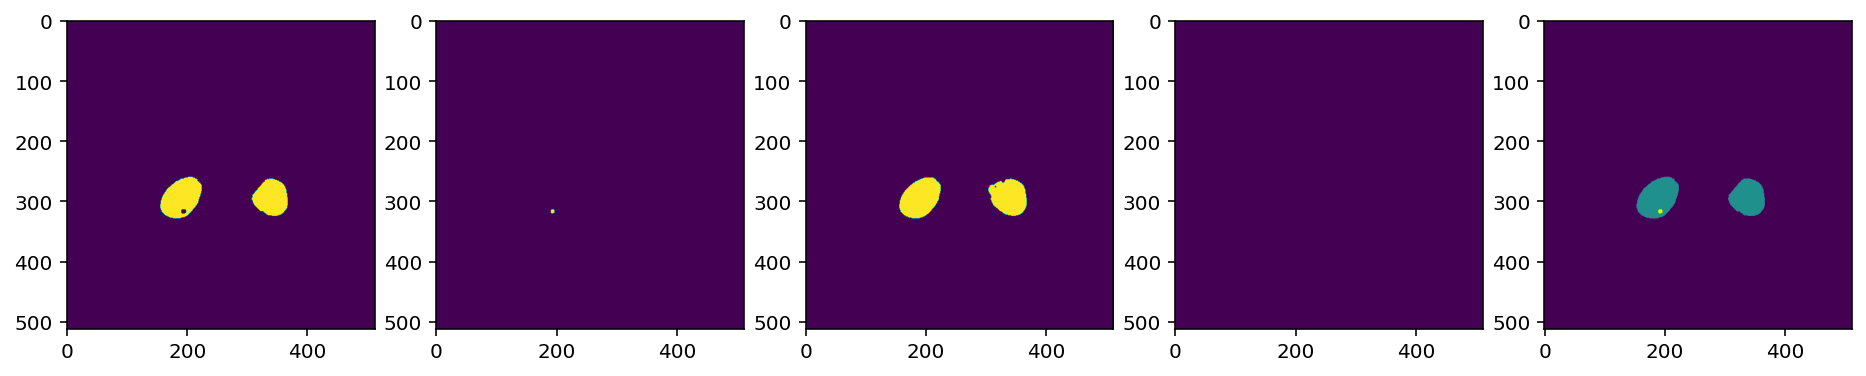

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


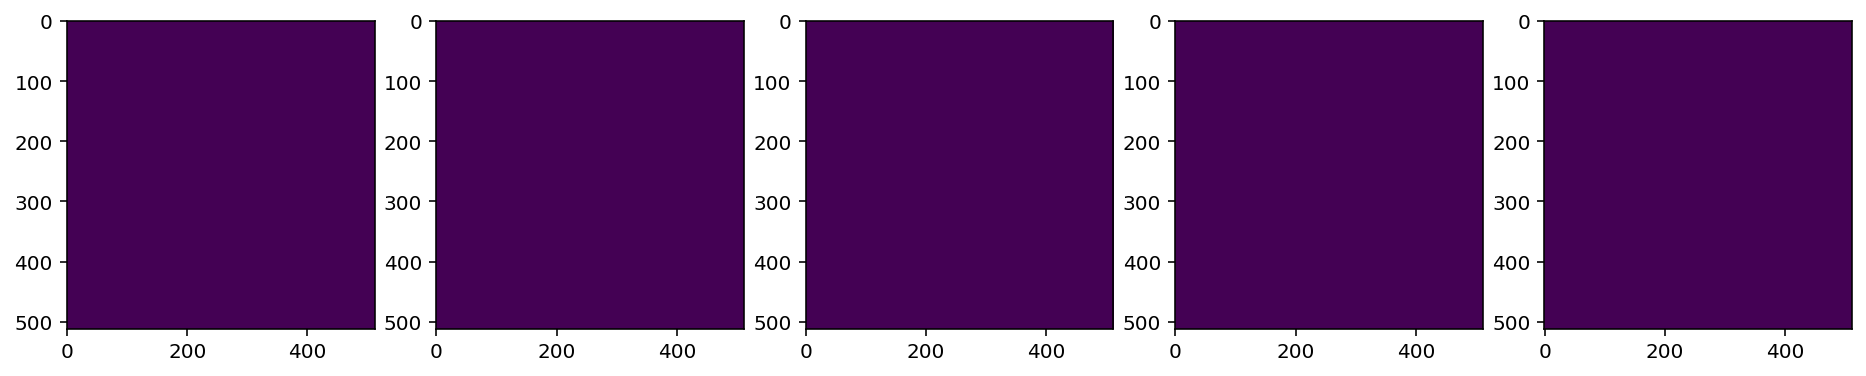

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.533237 	Validation Loss: 0.653835


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9907872463080135


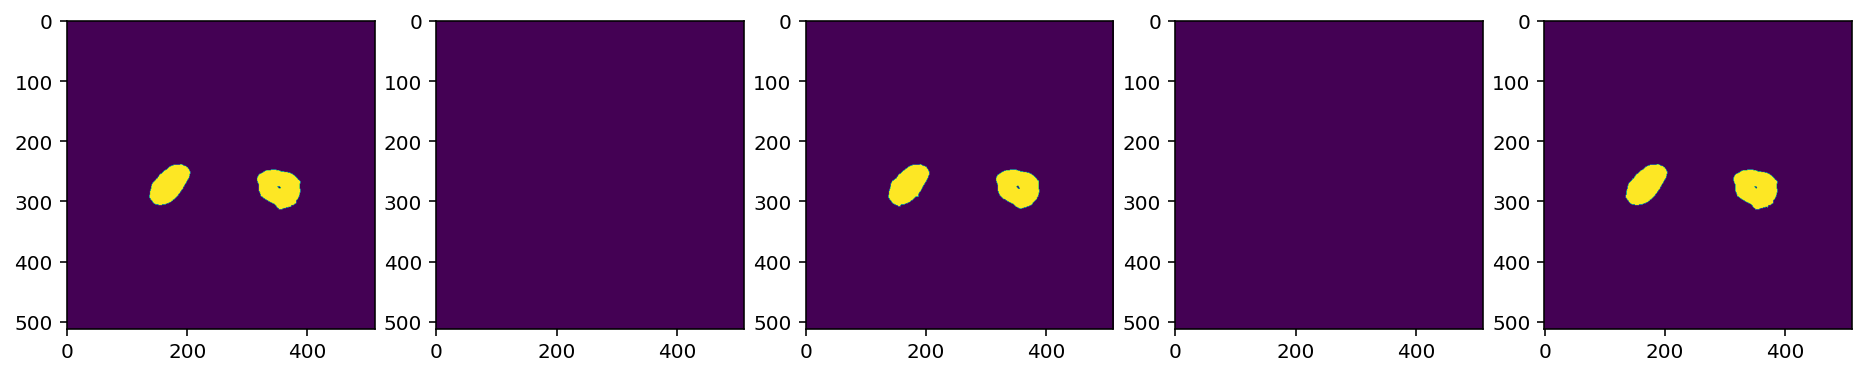

0.4999971389770508


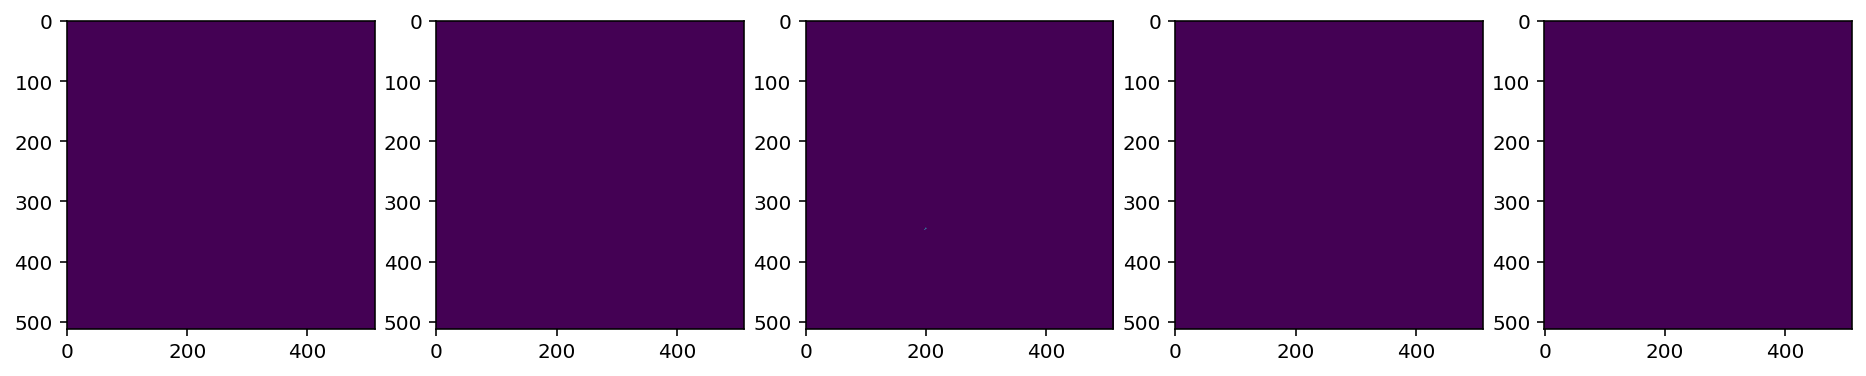

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.533097 	Validation Loss: 0.659008


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9900283250850326


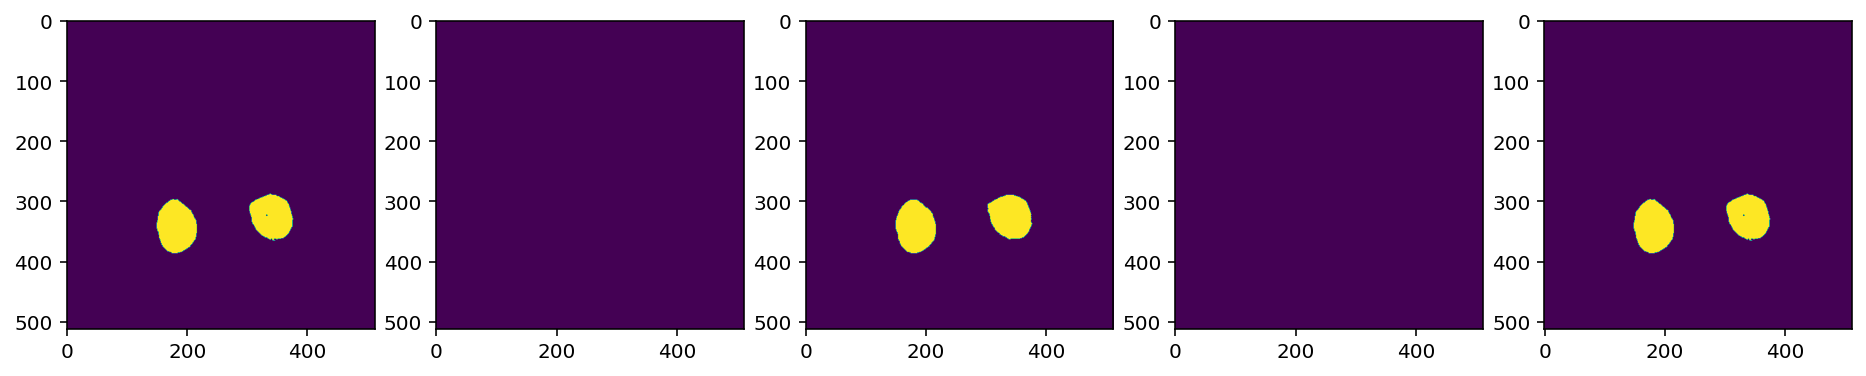

0.9135080162149483


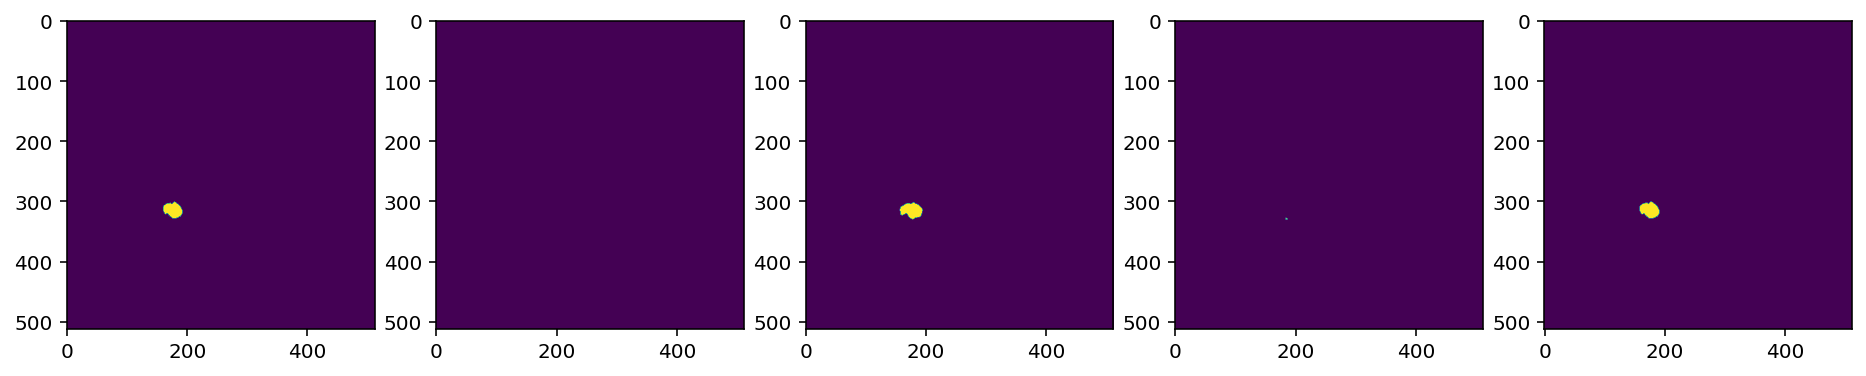

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.532985 	Validation Loss: 0.684201


  0%|          | 0/5813 [00:00<?, ?it/s]

0.8461500313910958


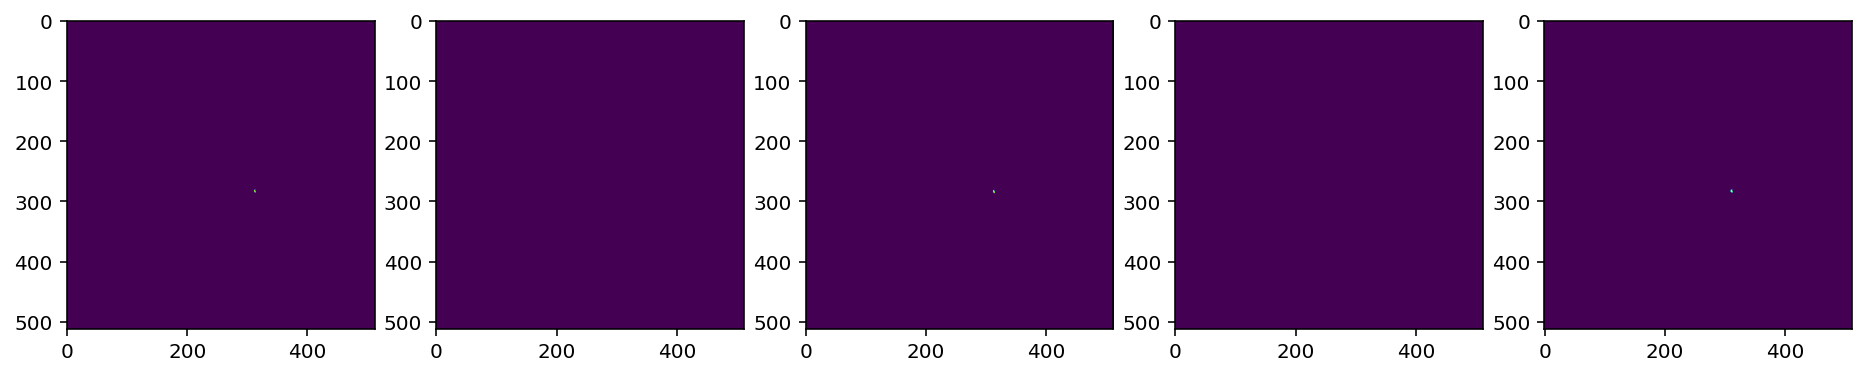

0.9775787257093957


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.532892 	Validation Loss: 0.672791


  0%|          | 0/5813 [00:00<?, ?it/s]

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


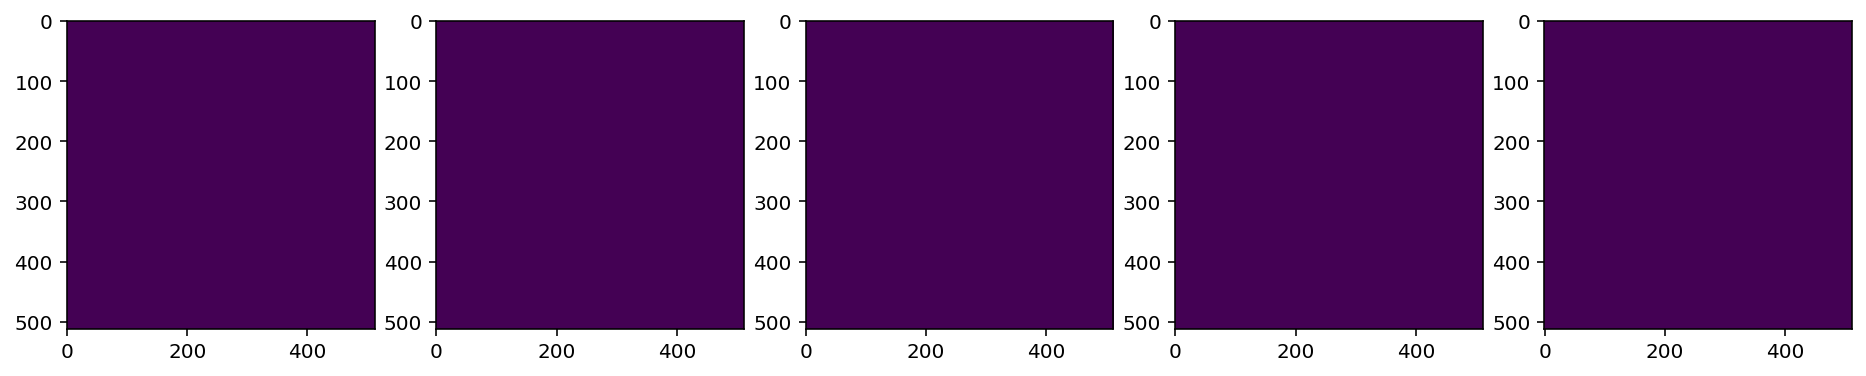

0.9925610426226825


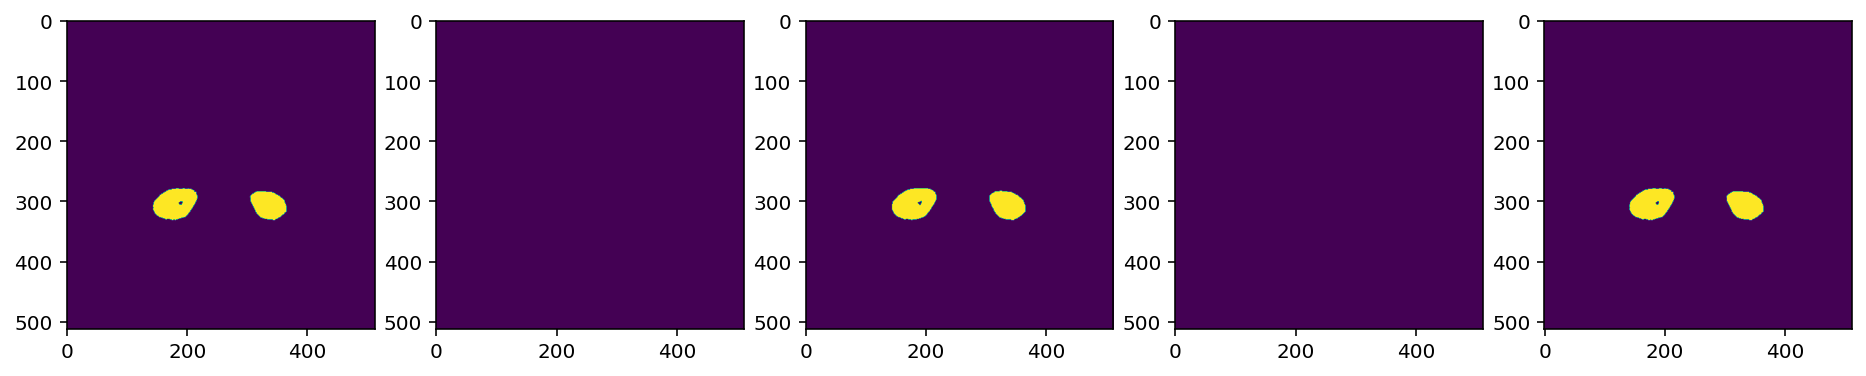

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.532739 	Validation Loss: 0.667237


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9848956837420879


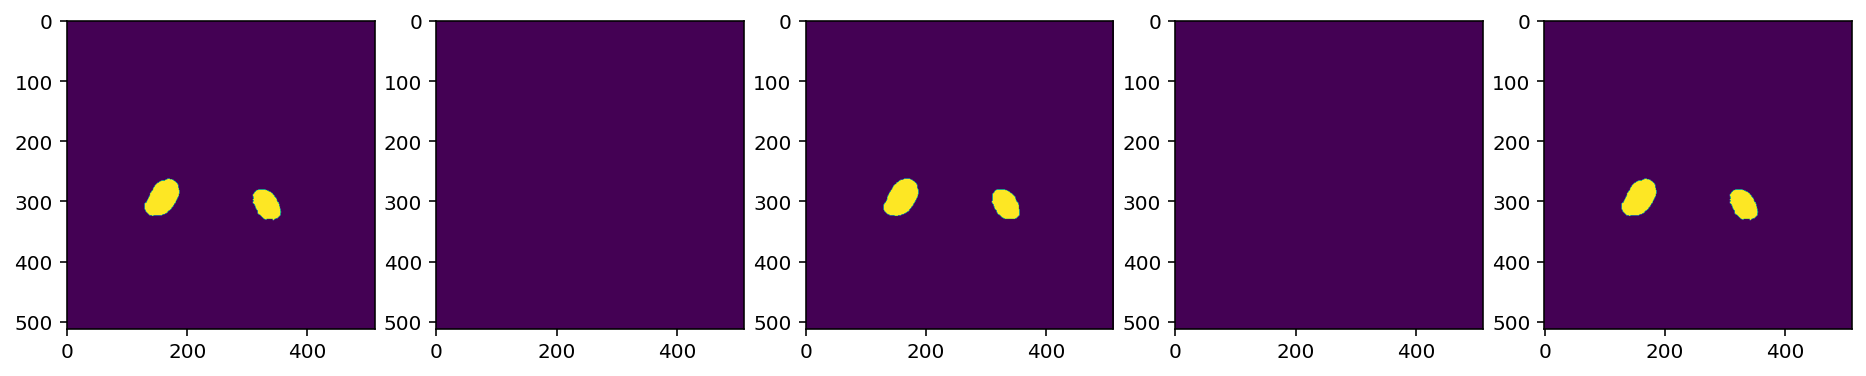

0.49988651275634766


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.532700 	Validation Loss: 0.690743


  0%|          | 0/5813 [00:00<?, ?it/s]

0.49984264373779297


<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


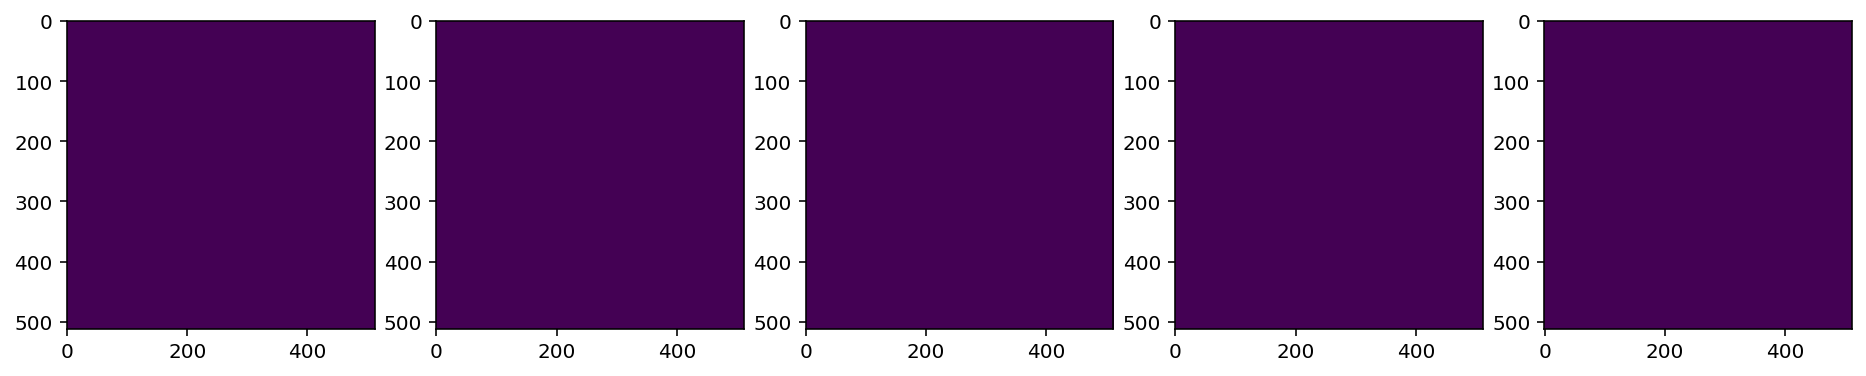

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.532677 	Validation Loss: 0.654244


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9812075673232696


0.9776833973596966


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.532656 	Validation Loss: 0.657966


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9844028608247668


0.98655640869826


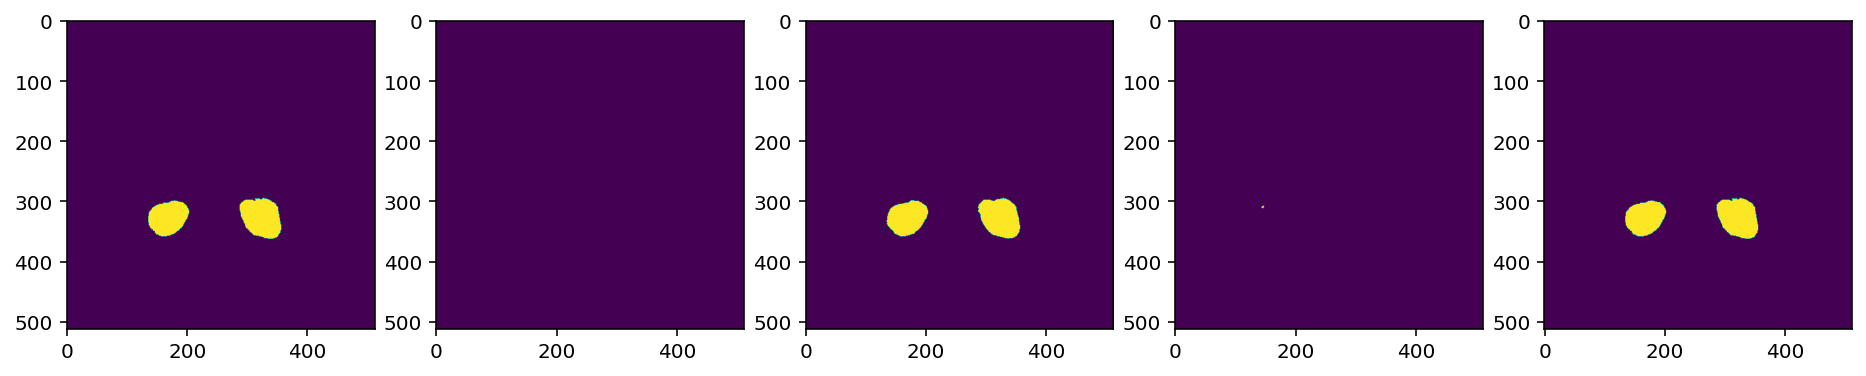

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.532639 	Validation Loss: 0.661746


  0%|          | 0/5813 [00:00<?, ?it/s]

0.8782205010569555


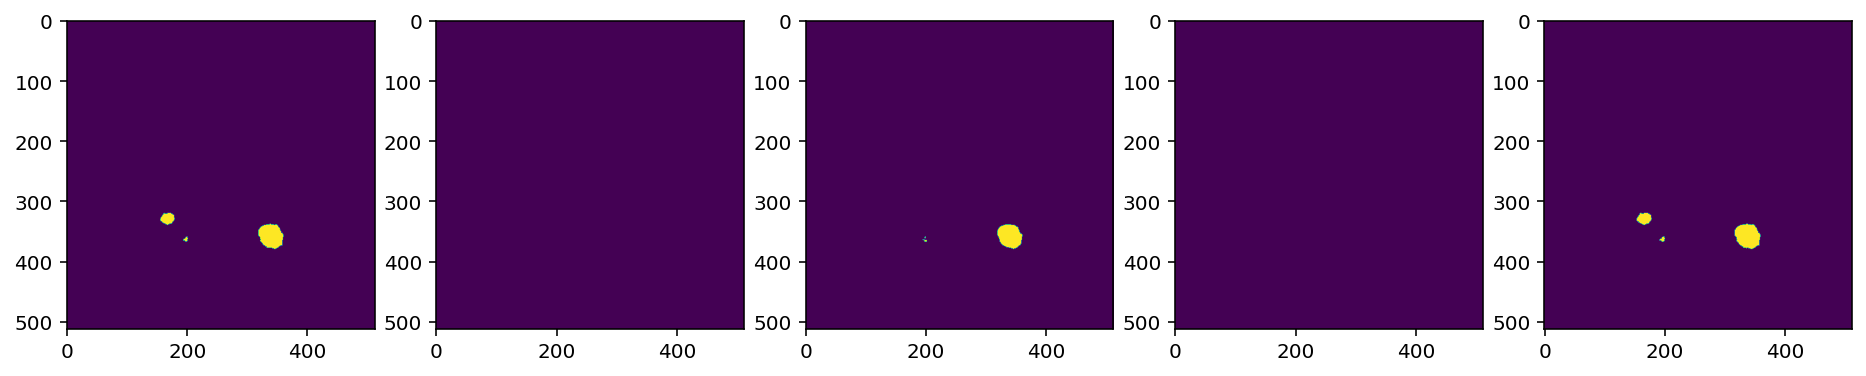

0.8317683945196898


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.532624 	Validation Loss: 0.677788


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9839527389916658


0.988122227095446


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.532608 	Validation Loss: 0.658818


  0%|          | 0/5813 [00:00<?, ?it/s]

0.4998607635498047


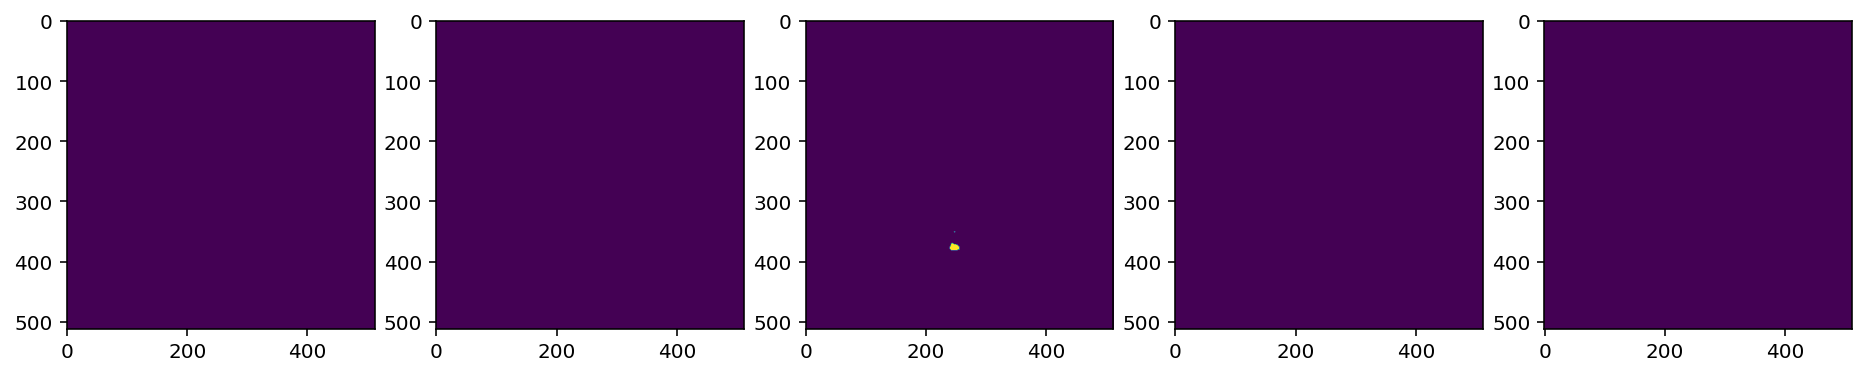

0.991538761312086


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.532588 	Validation Loss: 0.653943


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9242968368828894


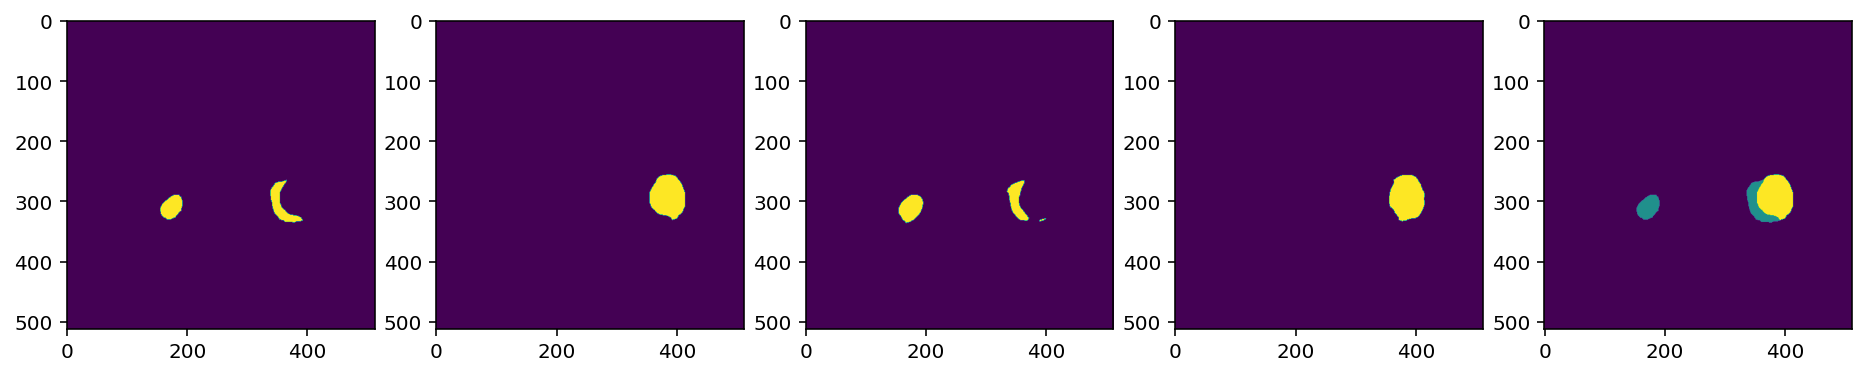

0.9776960327474348


0.9675074440613657


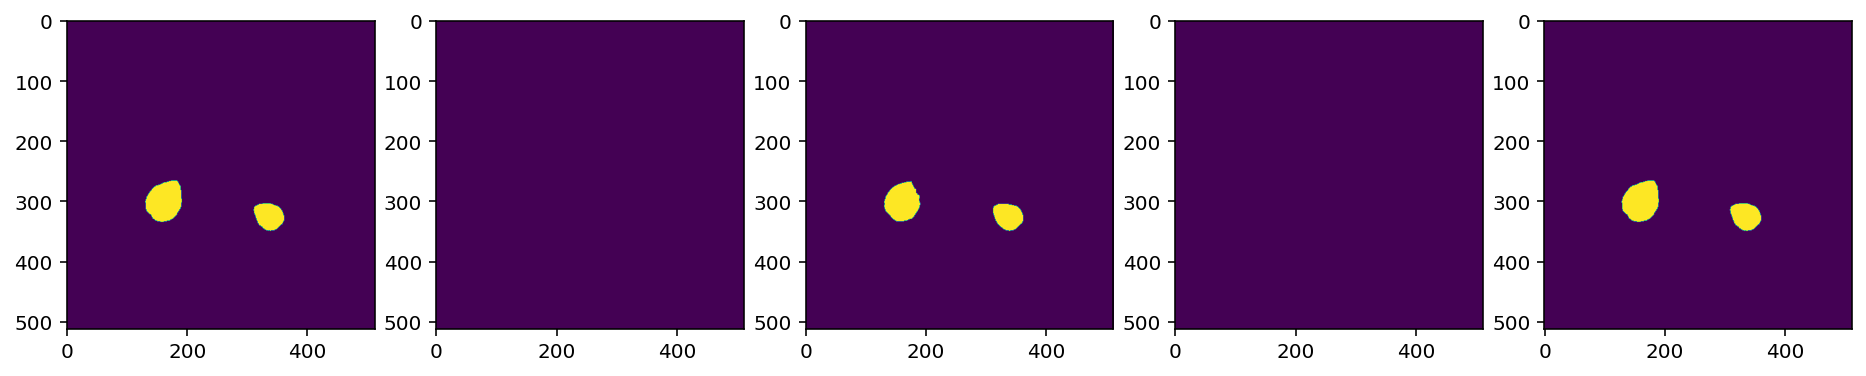

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.532585 	Validation Loss: 0.666183


  0%|          | 0/5813 [00:00<?, ?it/s]

0.929228344263225


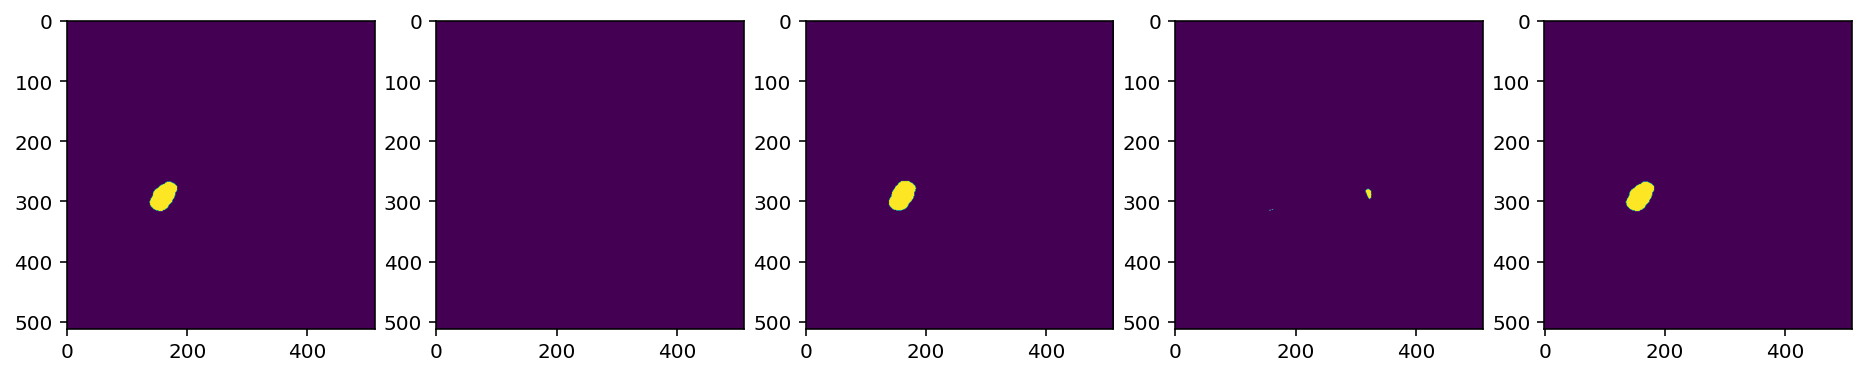

0.9544197178362428


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.532584 	Validation Loss: 0.657913


  0%|          | 0/5813 [00:00<?, ?it/s]

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


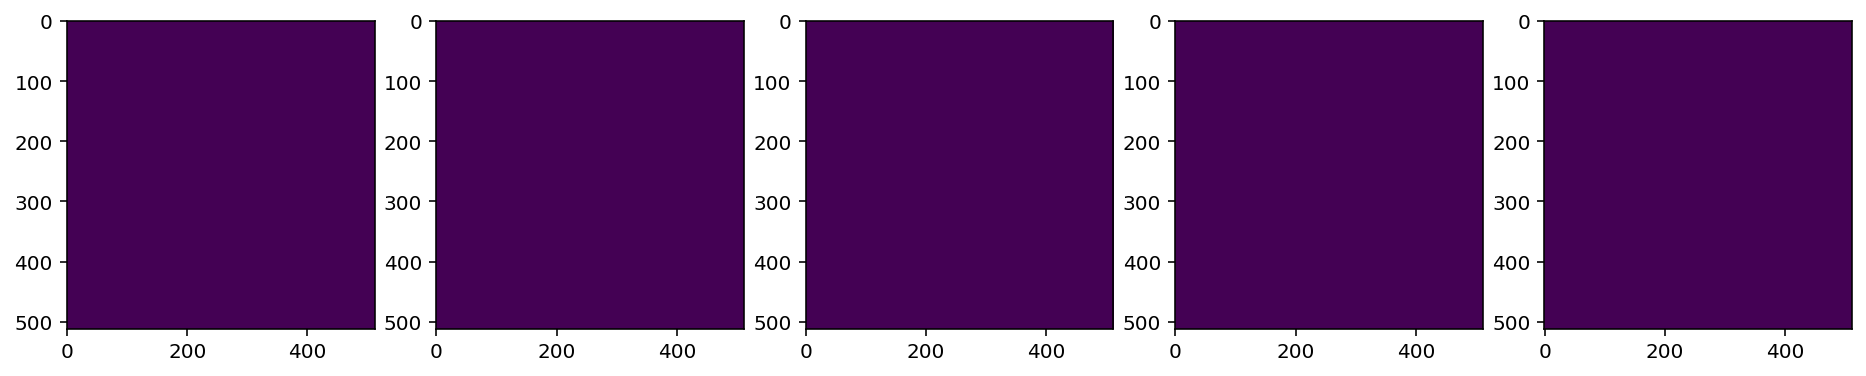

0.990607764160766


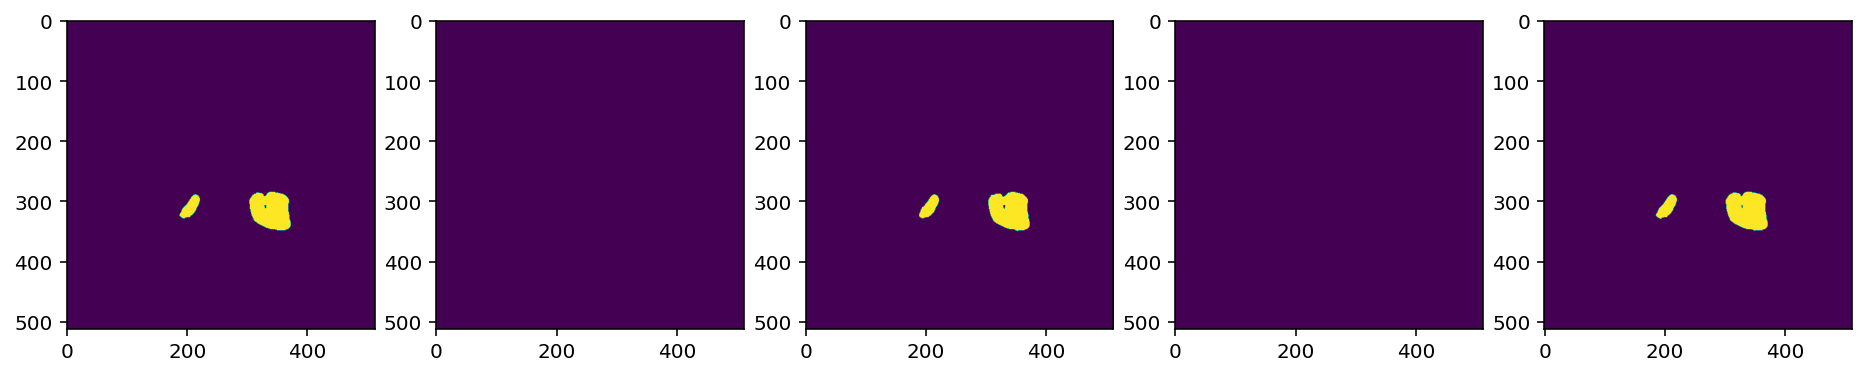

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.532582 	Validation Loss: 0.656844


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9749930876867453


0.4999856948852539


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.532581 	Validation Loss: 0.662590


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9817006837918106


0.8718994327884538


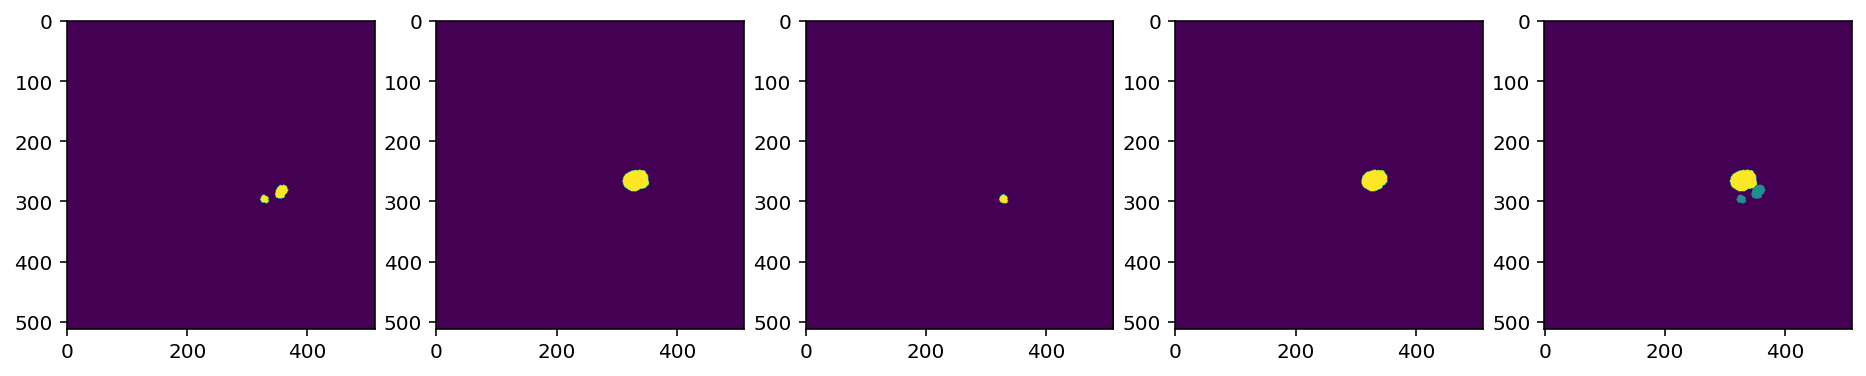

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.532580 	Validation Loss: 0.658743


  0%|          | 0/5813 [00:00<?, ?it/s]

0.49981021881103516


0.9502361978927405


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.532579 	Validation Loss: 0.693642


  0%|          | 0/5813 [00:00<?, ?it/s]

0.49942970275878906


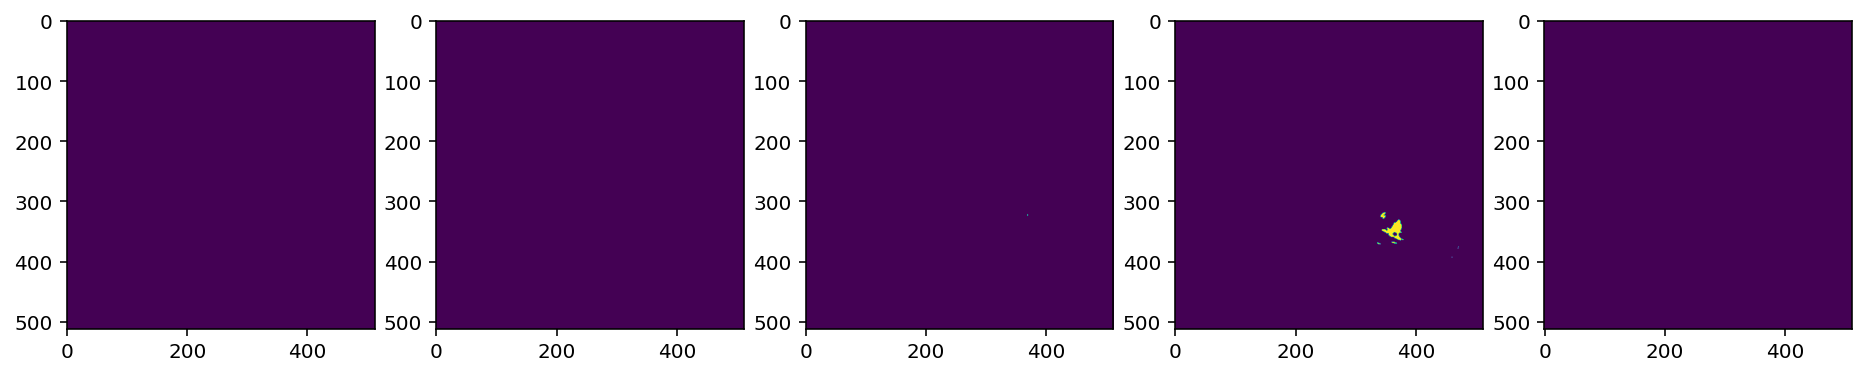

0.6943500193407199


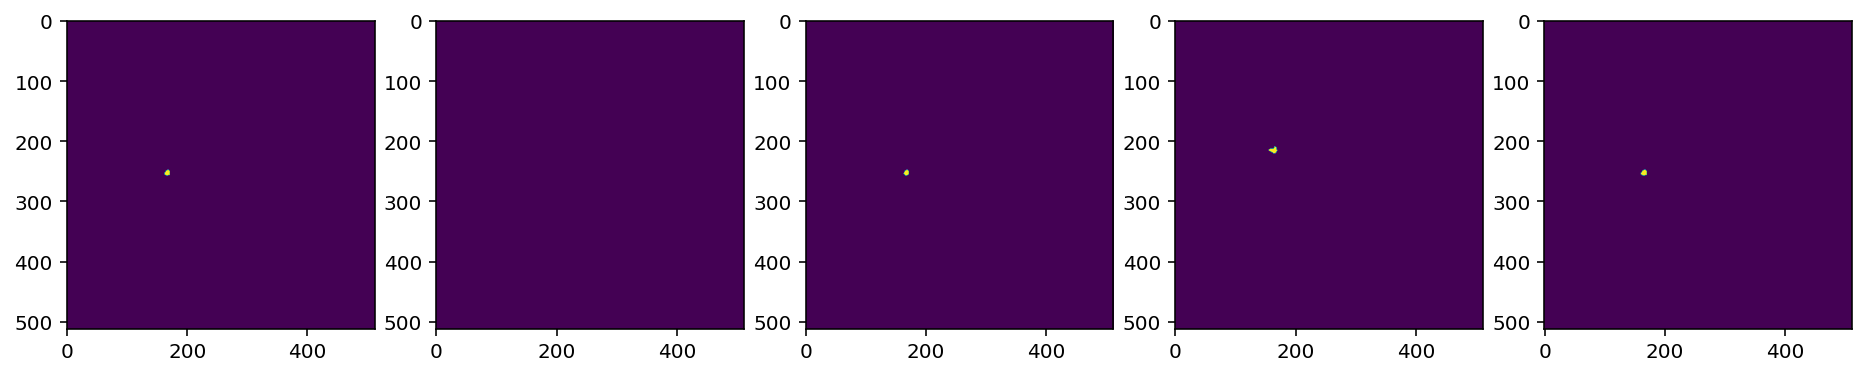

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.532576 	Validation Loss: 0.673130


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9664039319727533


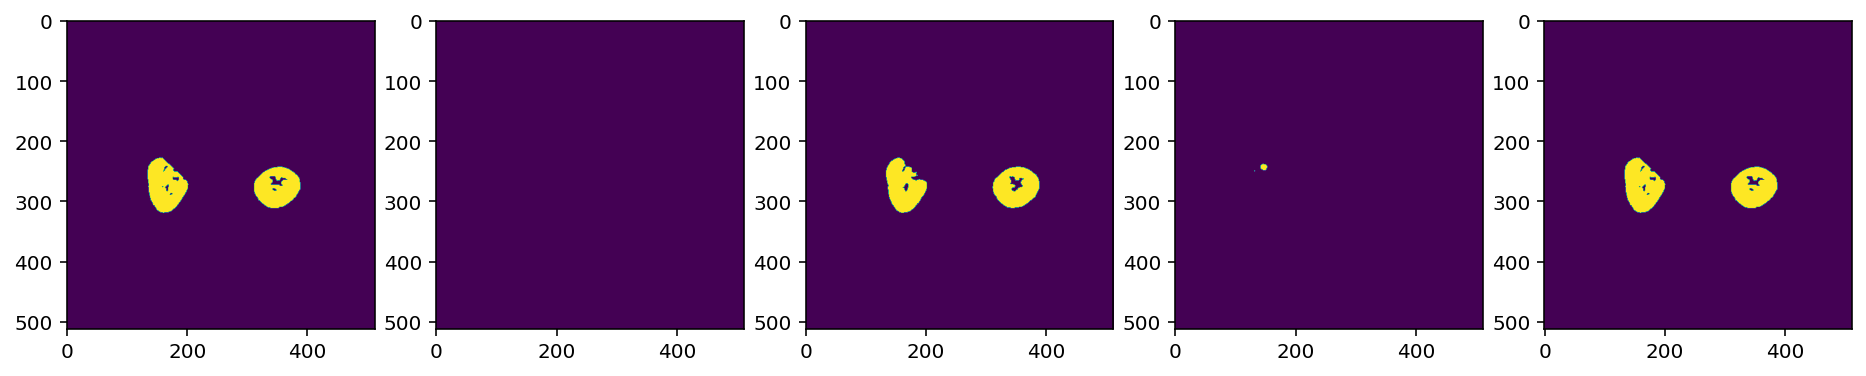

0.9421946055334326


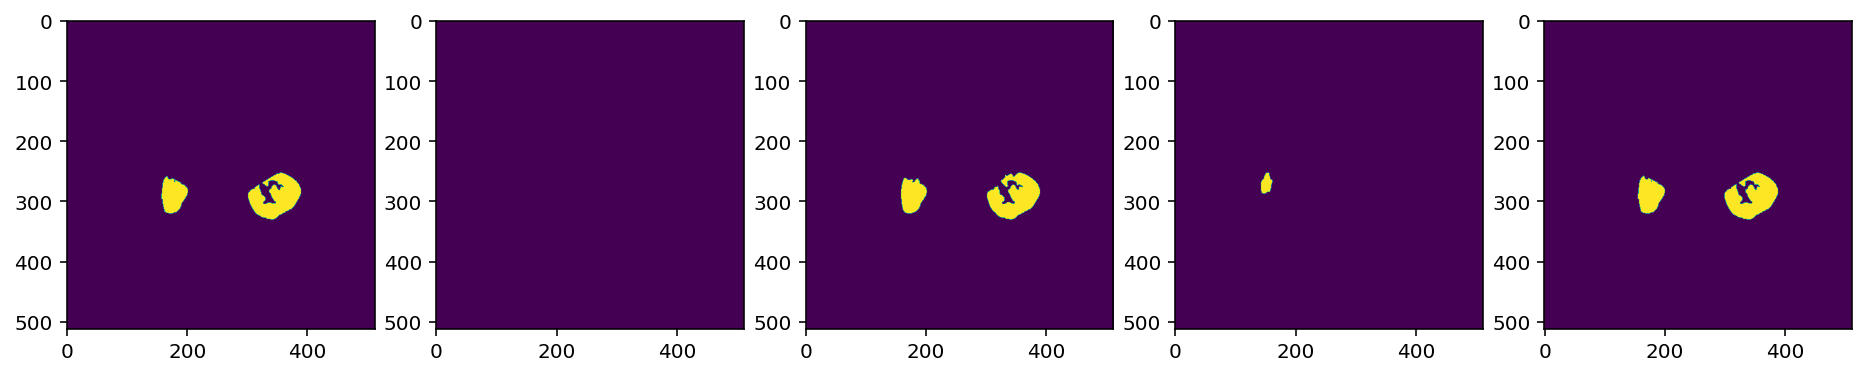

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.532576 	Validation Loss: 0.652616


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9713433010603574


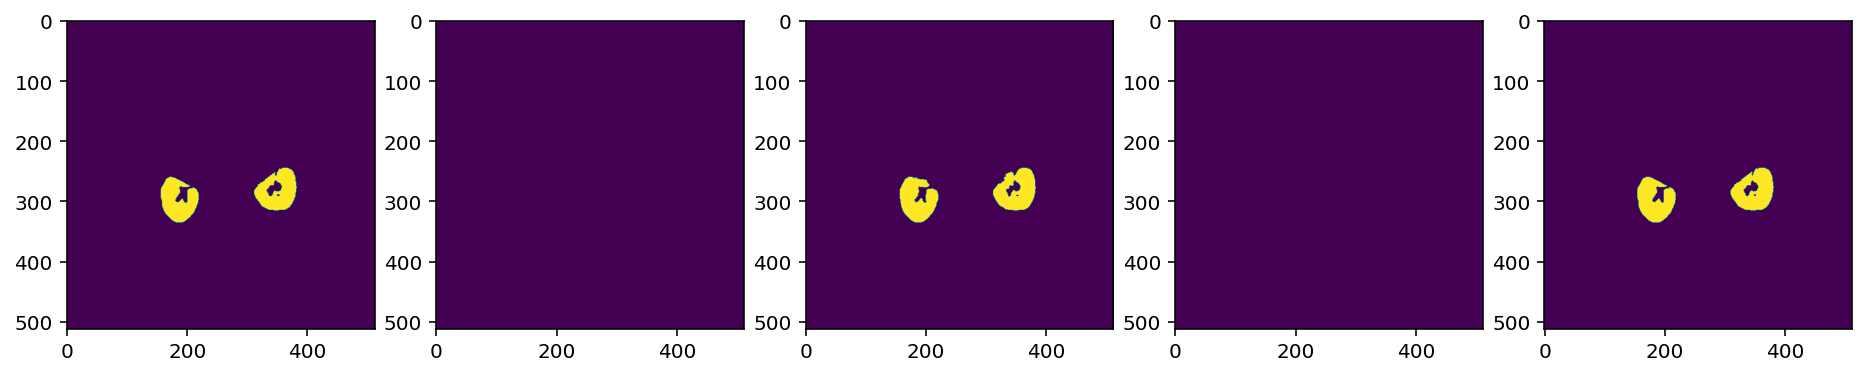

0.9873025040734239


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.532576 	Validation Loss: 0.662529


  0%|          | 0/5813 [00:00<?, ?it/s]

0.7881252756061232


0.9772746897621154


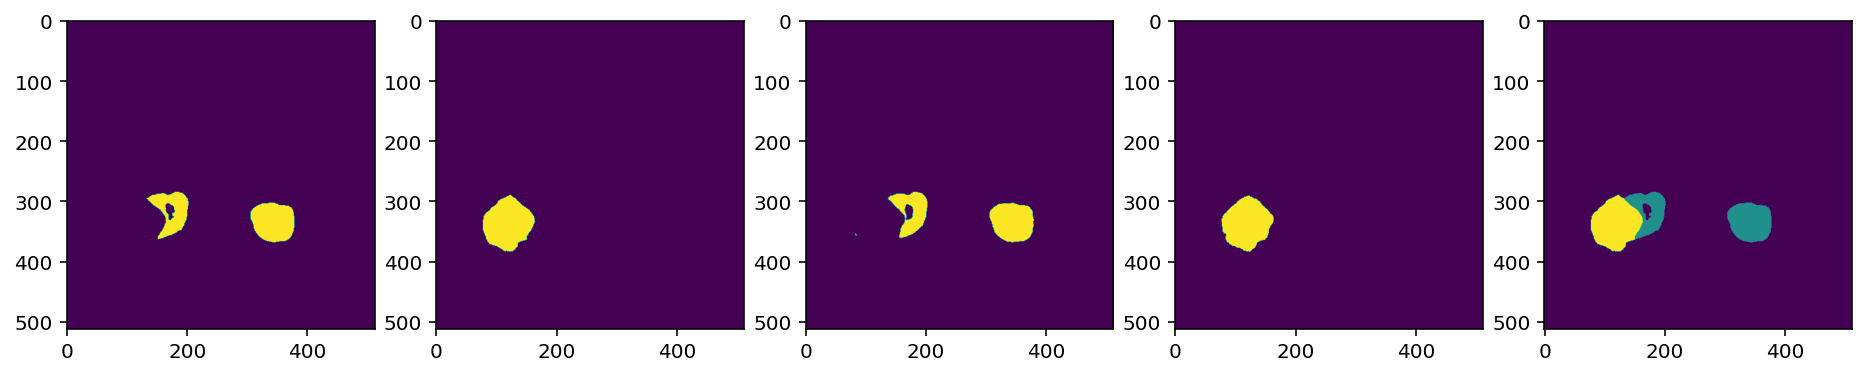

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.532575 	Validation Loss: 0.655650


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9851764976016888


0.972723976268856


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.532575 	Validation Loss: 0.664325


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9489333949491309


0.9835151346869448


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.532575 	Validation Loss: 0.657267


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9881439117695927


0.925370723964553


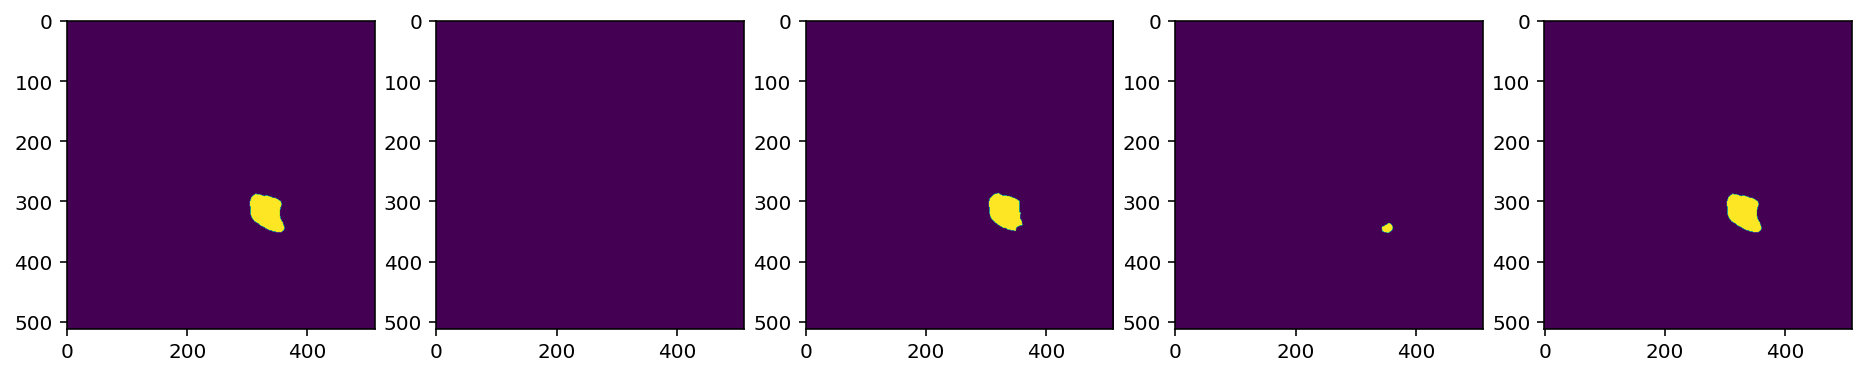

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.532576 	Validation Loss: 0.690024


  0%|          | 0/5813 [00:00<?, ?it/s]

0.4989805221557617


<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


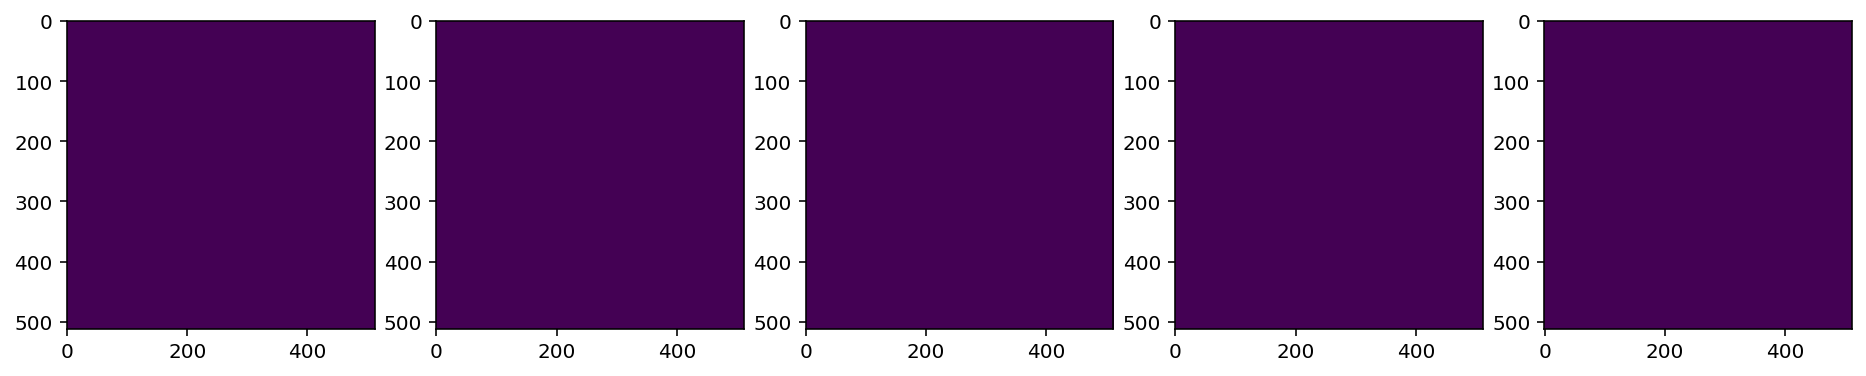

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.532575 	Validation Loss: 0.698648


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9643035081451856


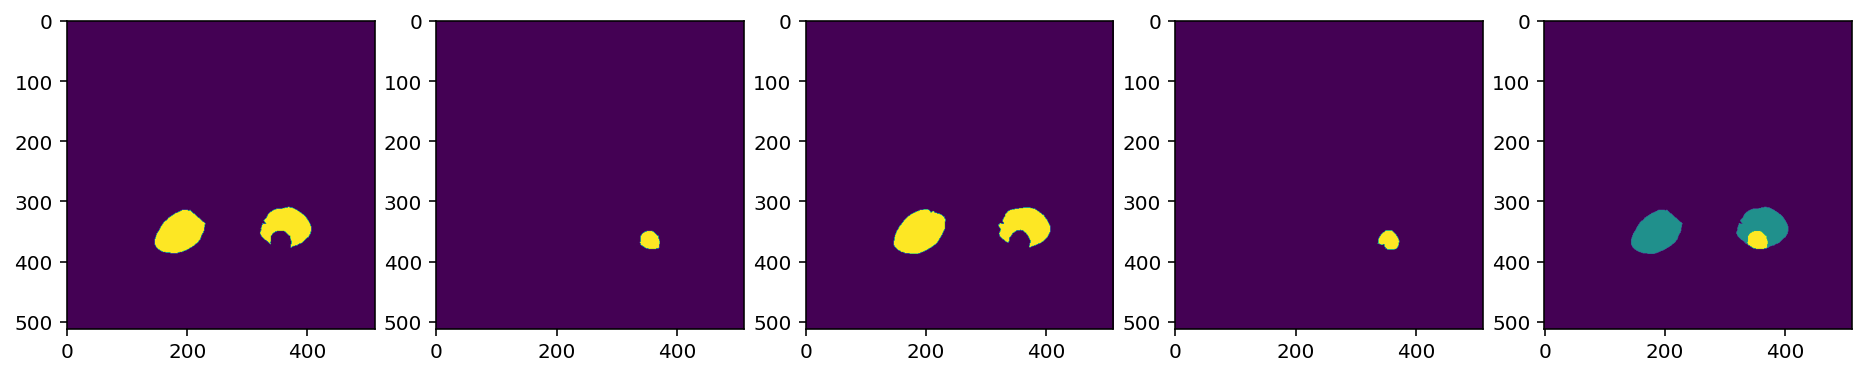

0.9835522063689199


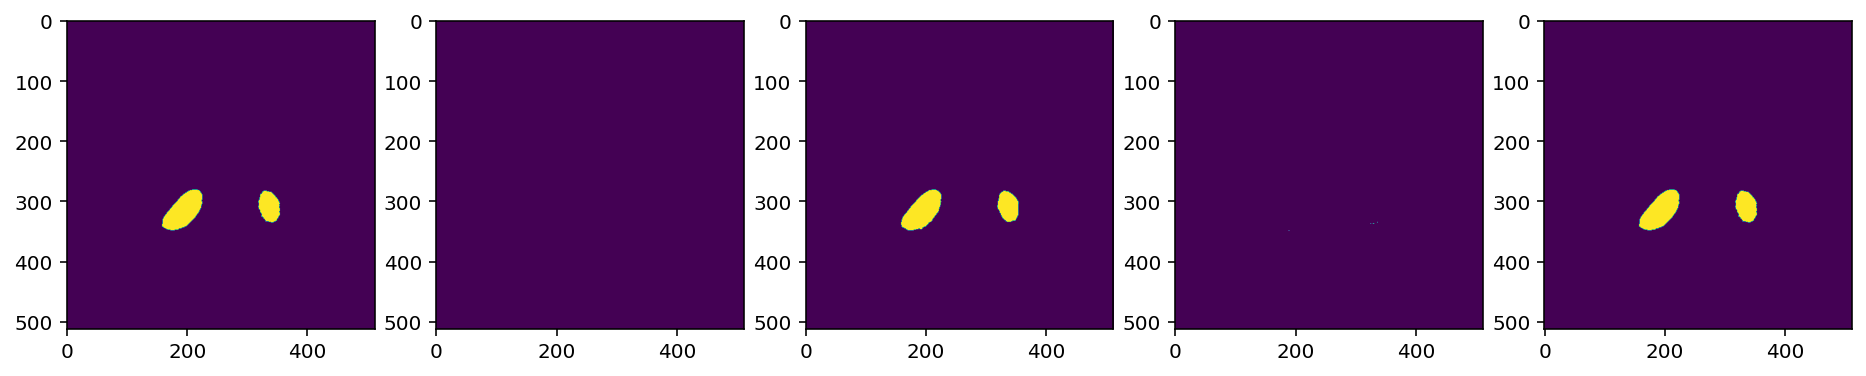

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.532576 	Validation Loss: 0.656806


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9904138918341387


0.9669222709857621


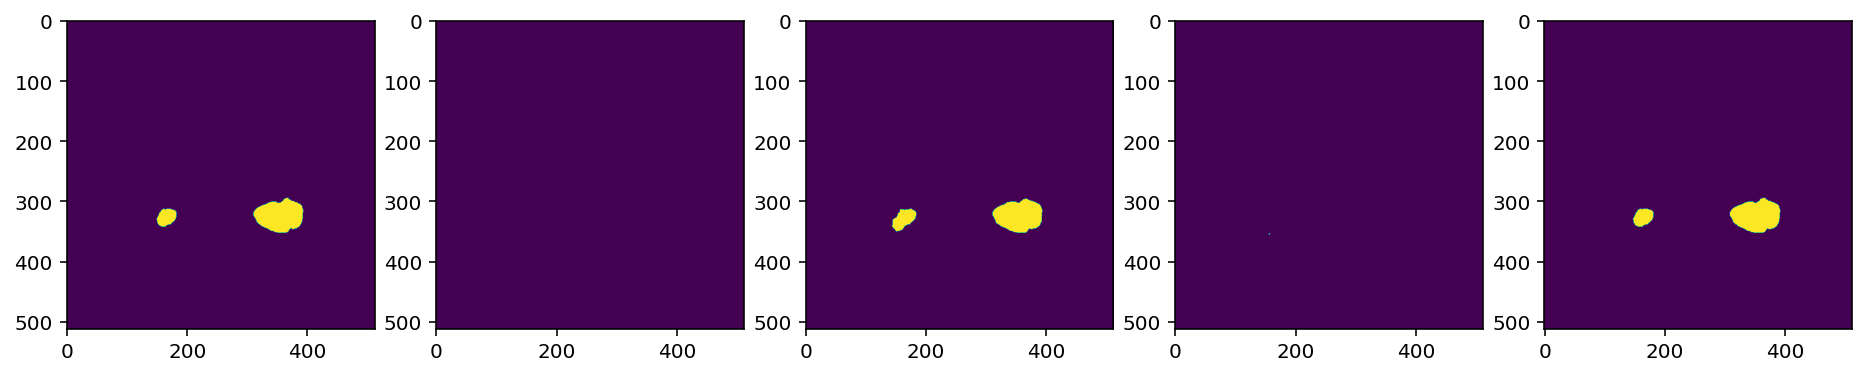

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 60 	Training Loss: 0.532575 	Validation Loss: 0.655951


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9882818162853637


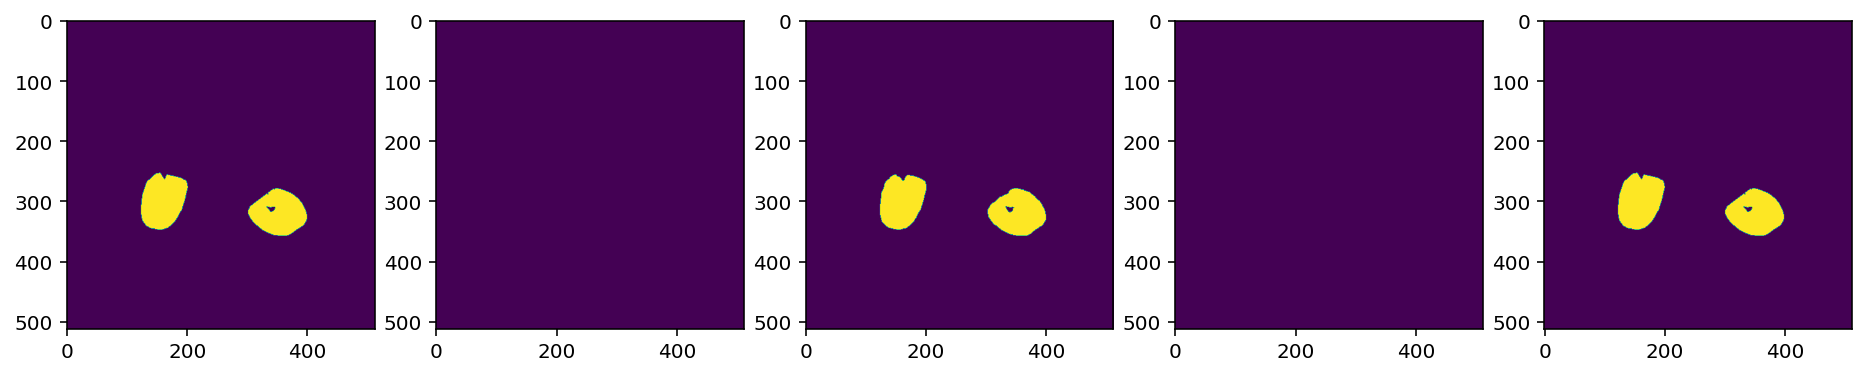

0.9914675249028095


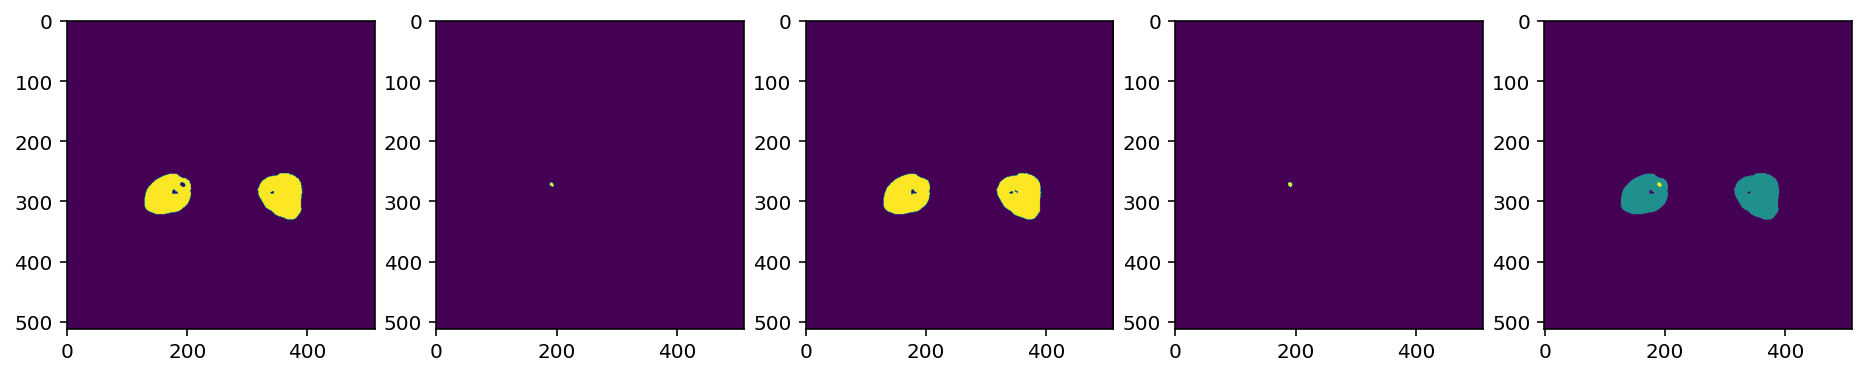

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 61 	Training Loss: 0.532575 	Validation Loss: 0.662710


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9748539271569787


<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


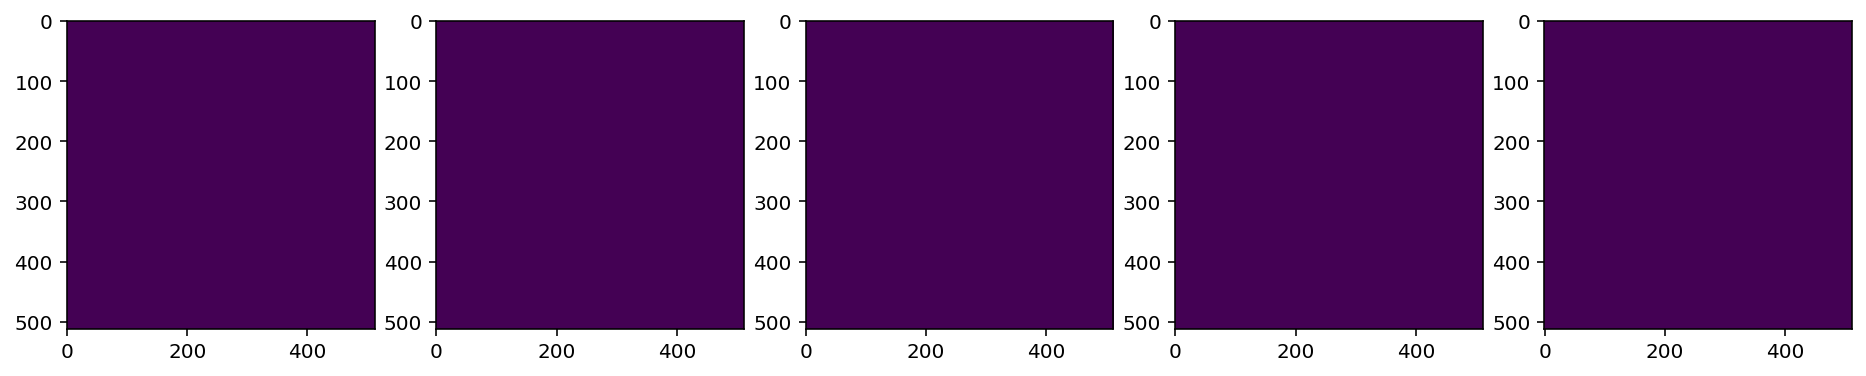

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 62 	Training Loss: 0.532576 	Validation Loss: 0.664113


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9915020845219018


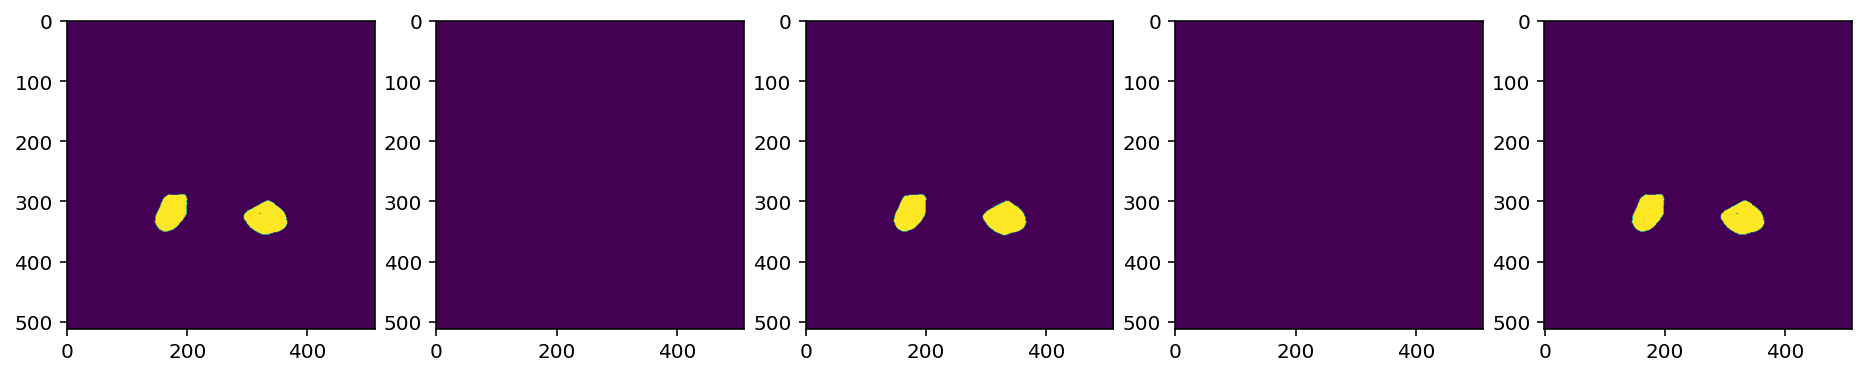

0.9241845101474198


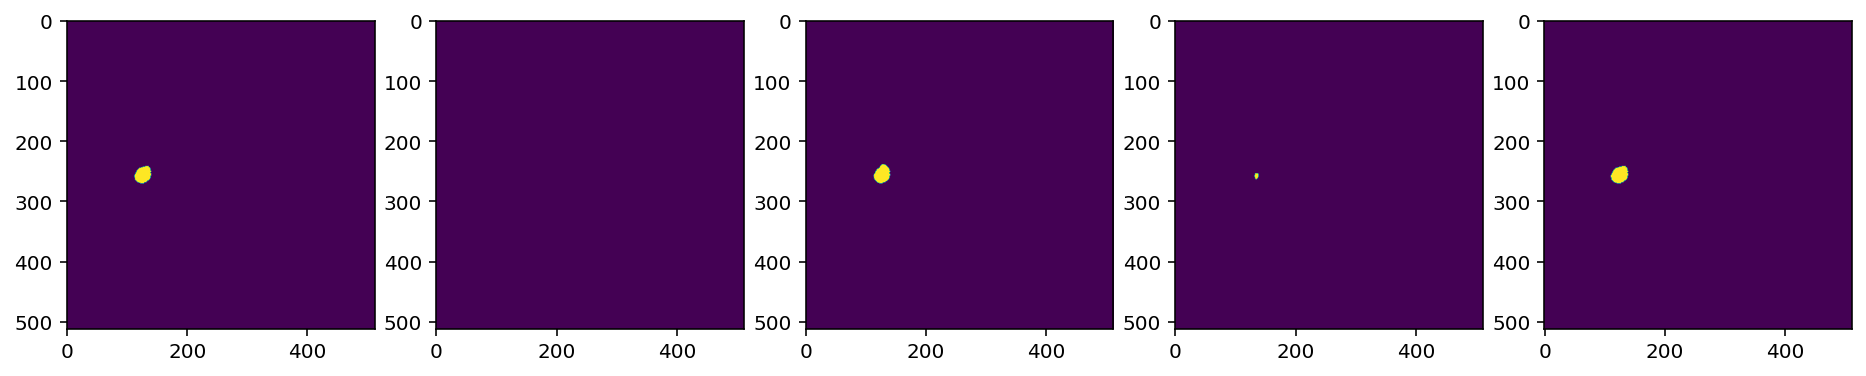

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 63 	Training Loss: 0.532575 	Validation Loss: 0.654180


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9841267932097322


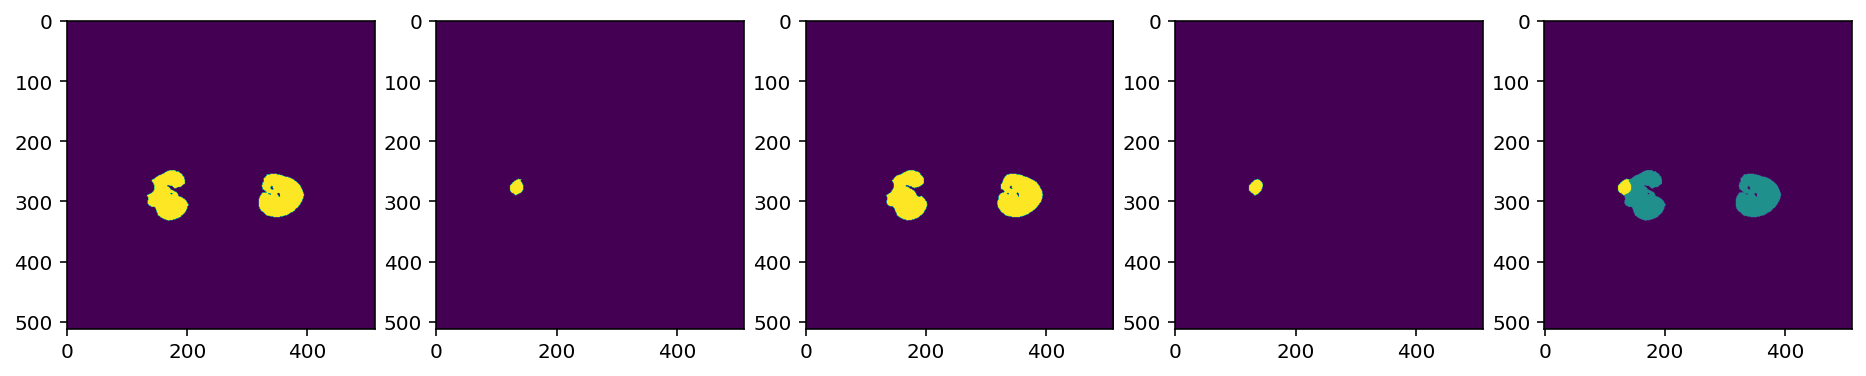

0.5660939655517034


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 64 	Training Loss: 0.532575 	Validation Loss: 0.649249
Validation loss decreased (0.652412 --> 0.649249).  Saving model ...


  0%|          | 0/5813 [00:00<?, ?it/s]

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


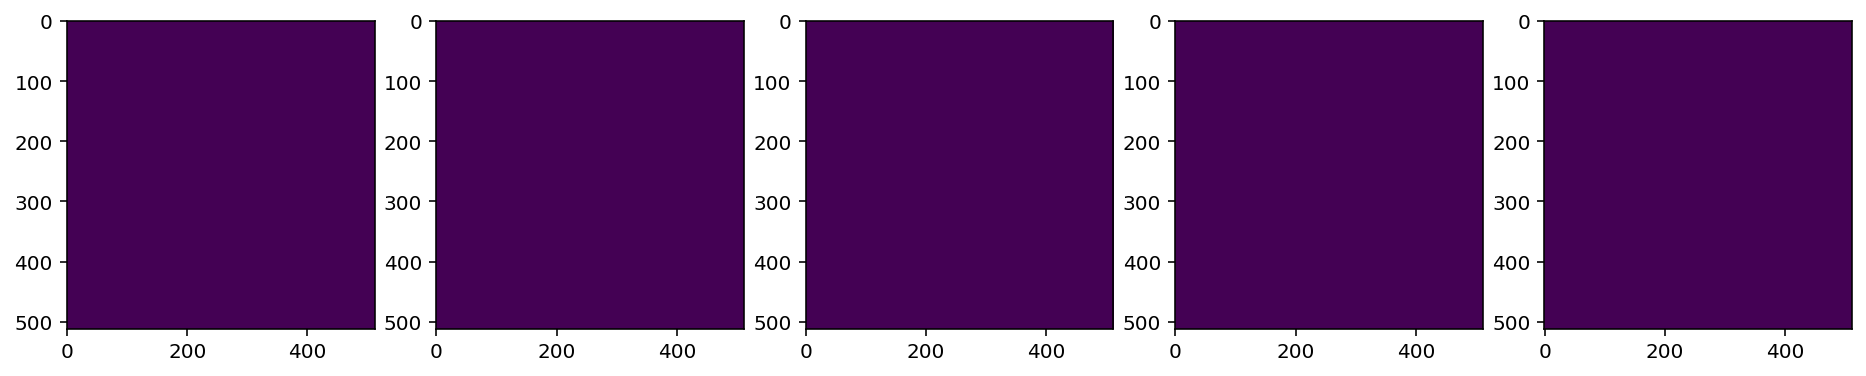

0.9833484097872389


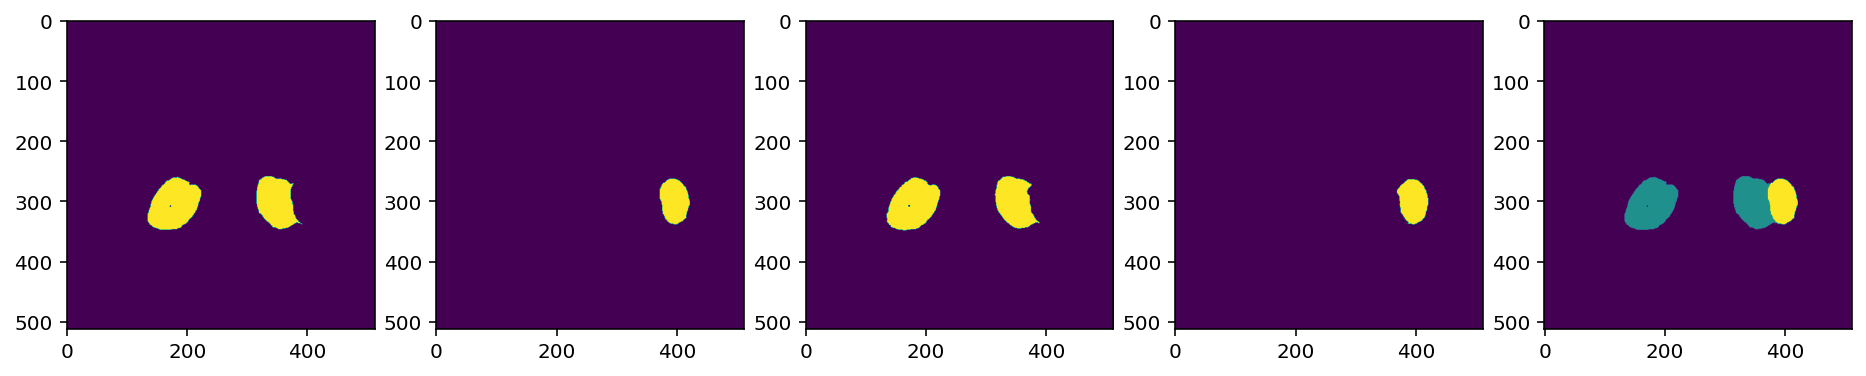

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 65 	Training Loss: 0.532576 	Validation Loss: 0.652696


  0%|          | 0/5813 [00:00<?, ?it/s]

0.8354705539955963


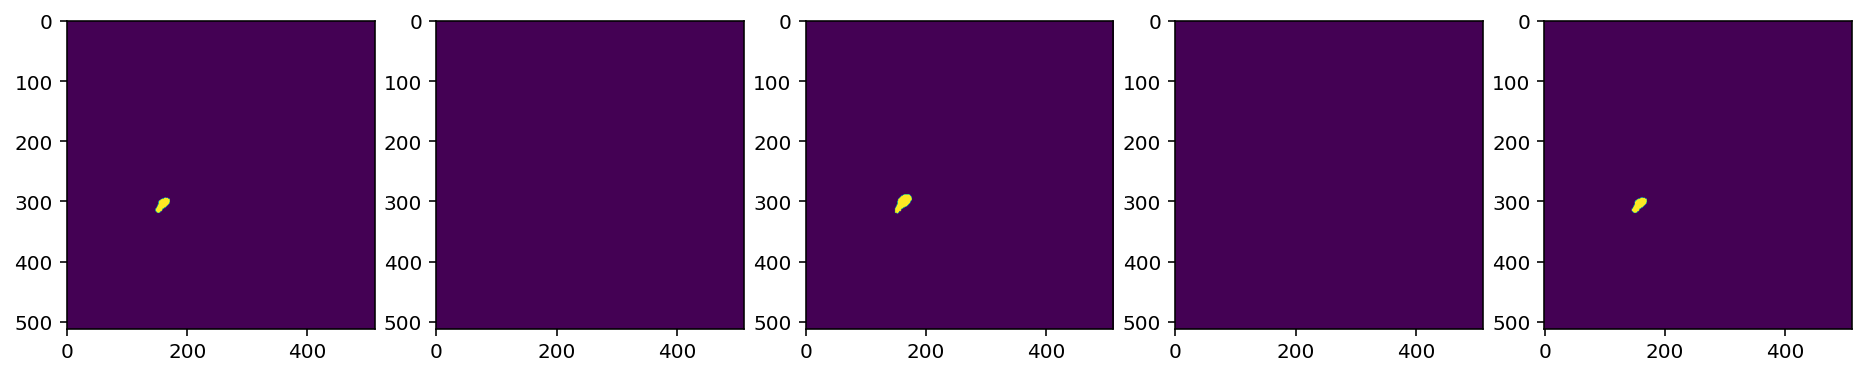

0.8639285746711961


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 66 	Training Loss: 0.532574 	Validation Loss: 0.661032


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9903178032326037


0.9707348354333147


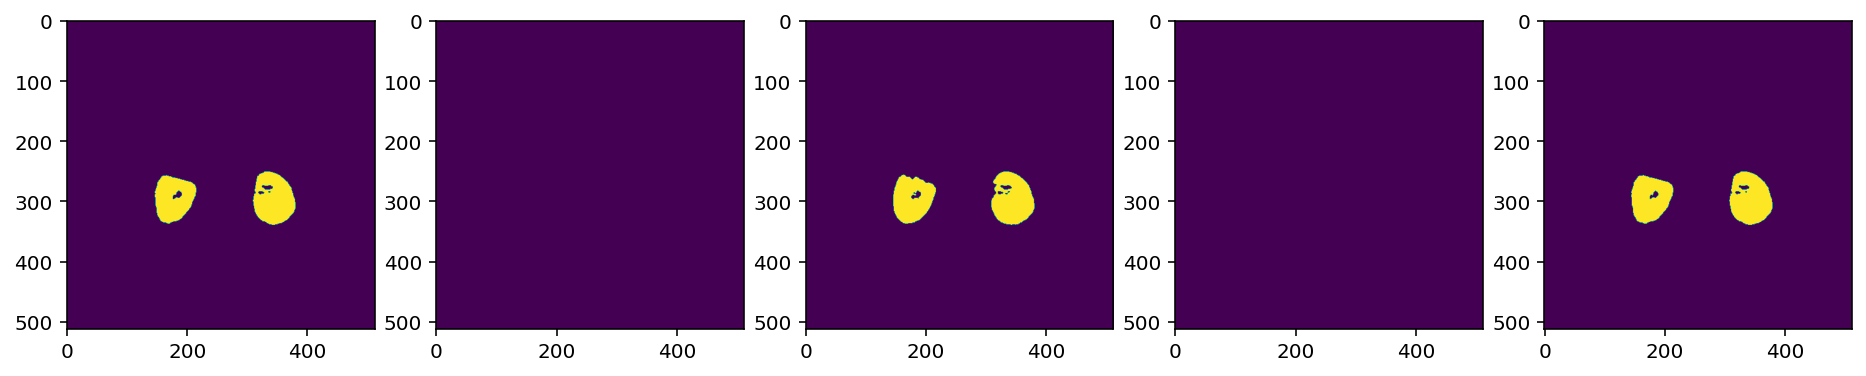

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 67 	Training Loss: 0.532574 	Validation Loss: 0.672335


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9781277468503653


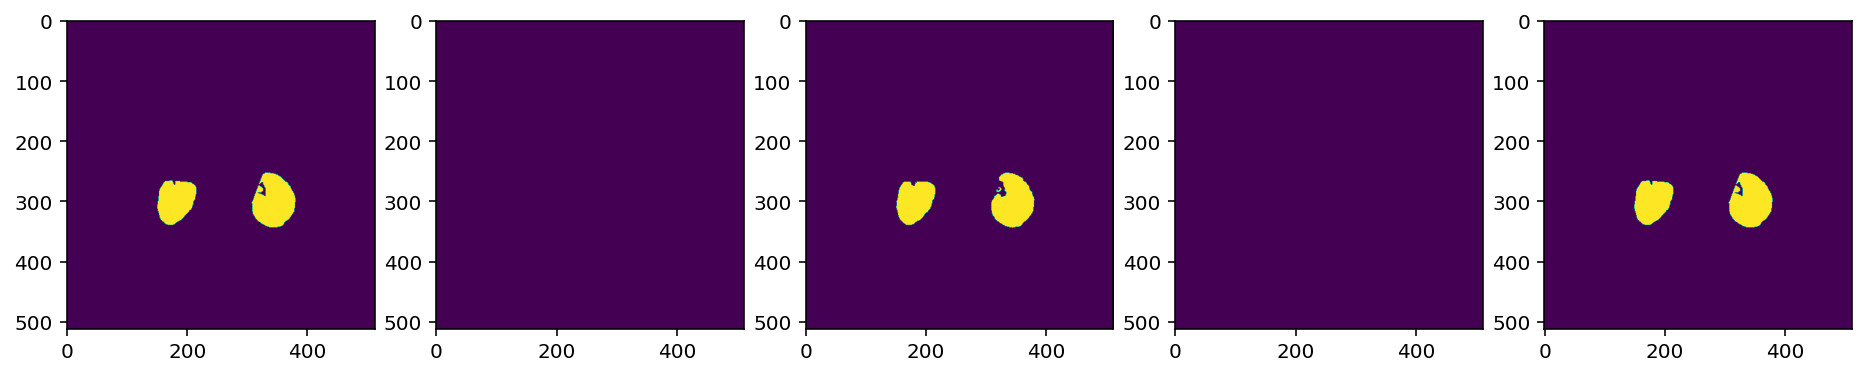

0.9714821072891824


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 68 	Training Loss: 0.532574 	Validation Loss: 0.661415


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9779848696778568


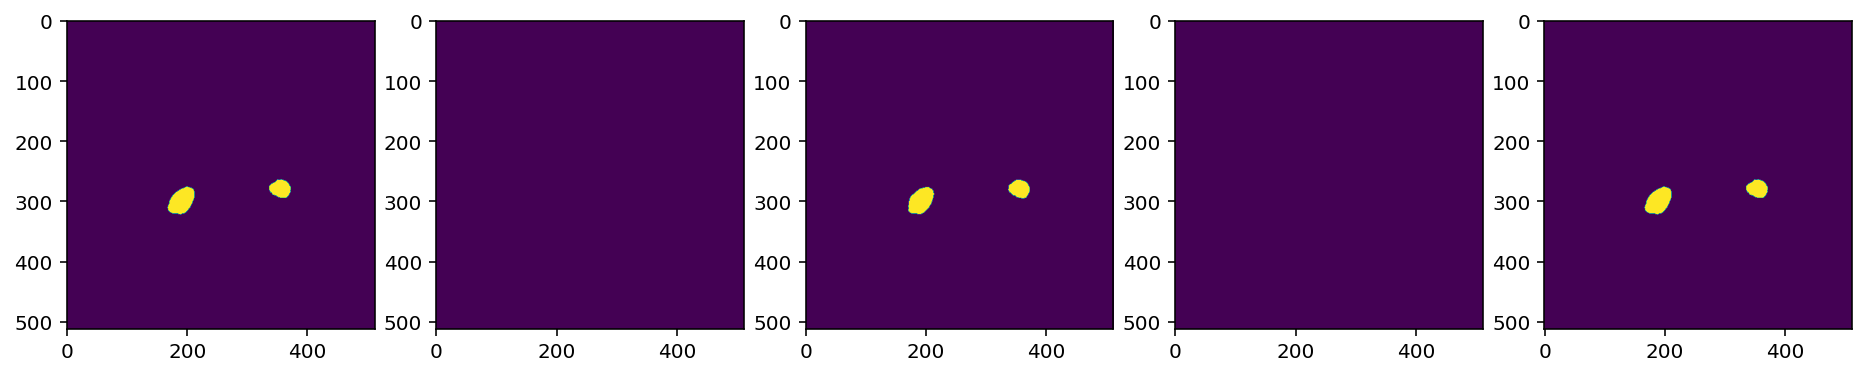

0.49993038177490234


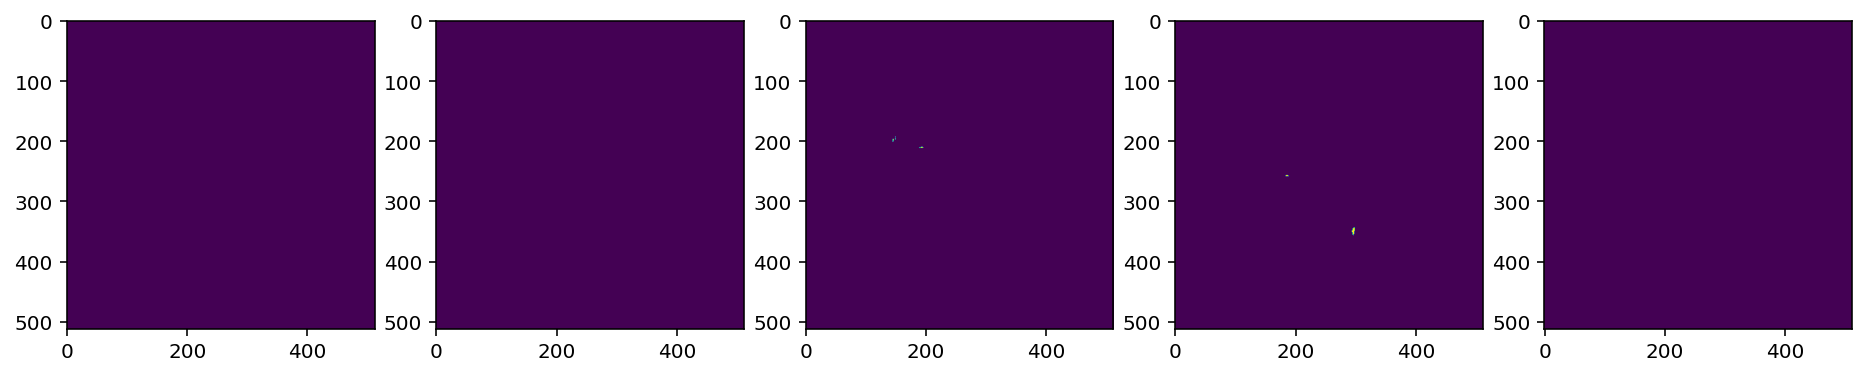

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 69 	Training Loss: 0.532576 	Validation Loss: 0.685836


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9747983613239983


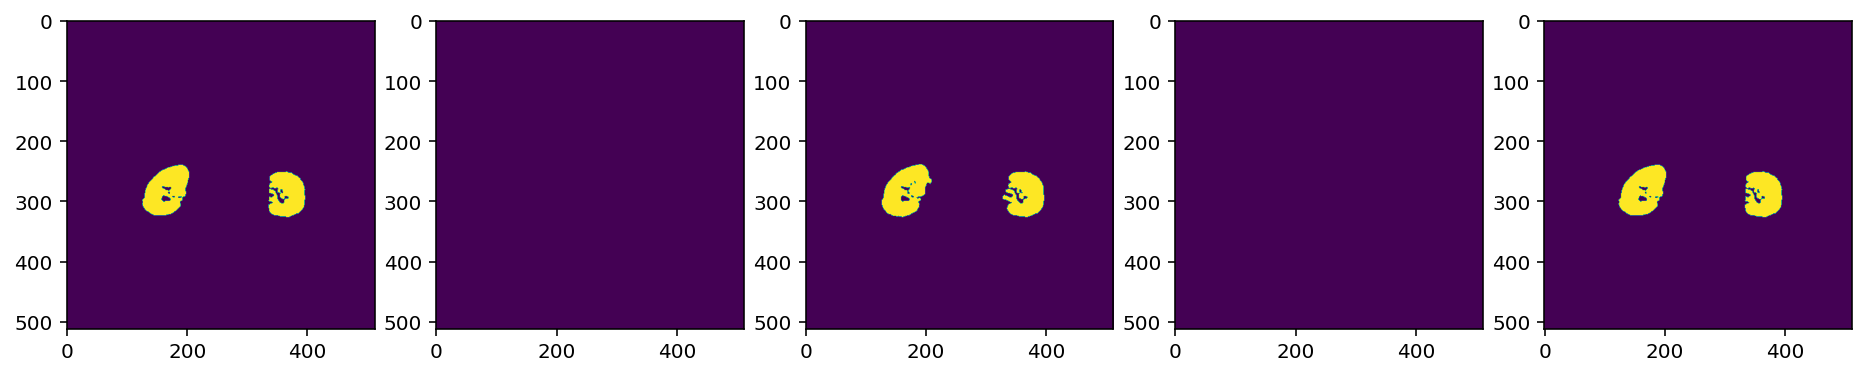

0.9794065706297557


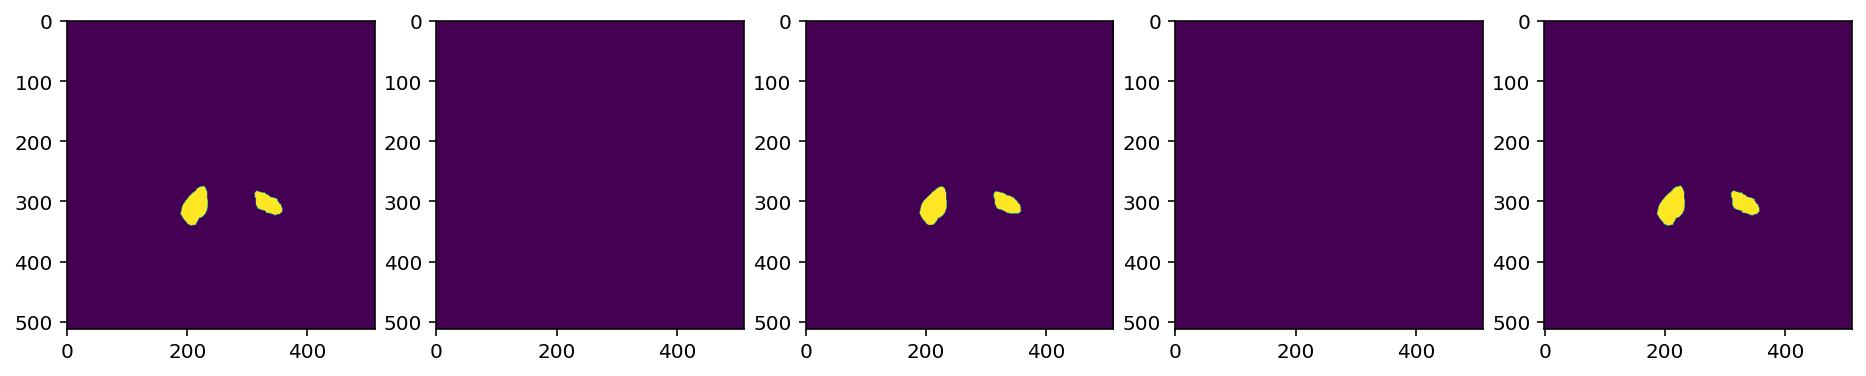

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 70 	Training Loss: 0.532575 	Validation Loss: 0.654211


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9870402934908172


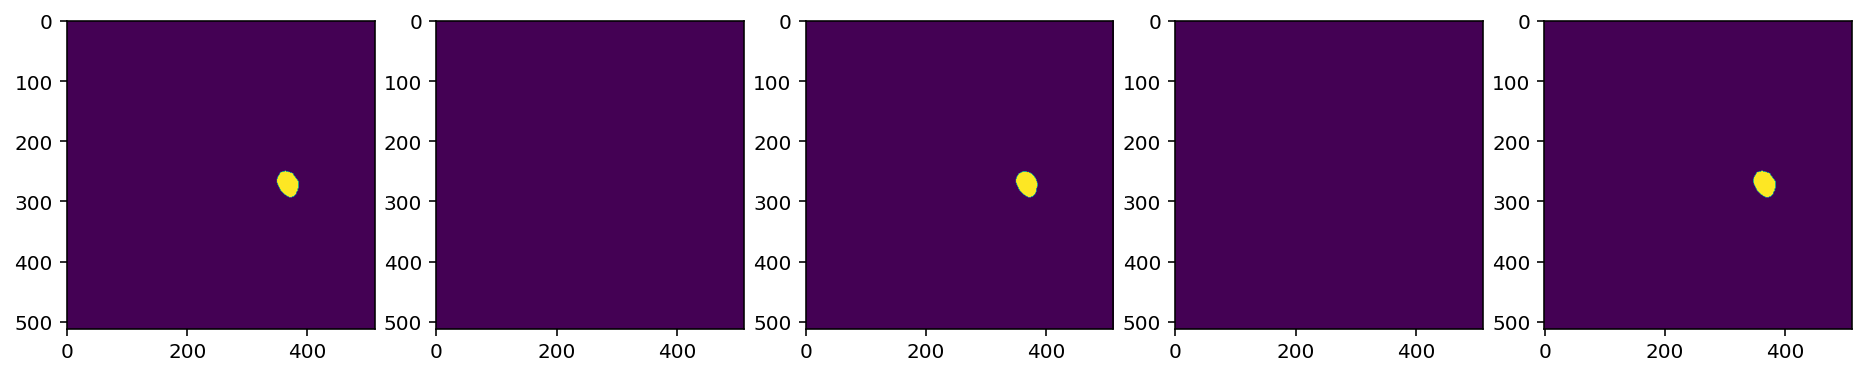

0.9822321753760199


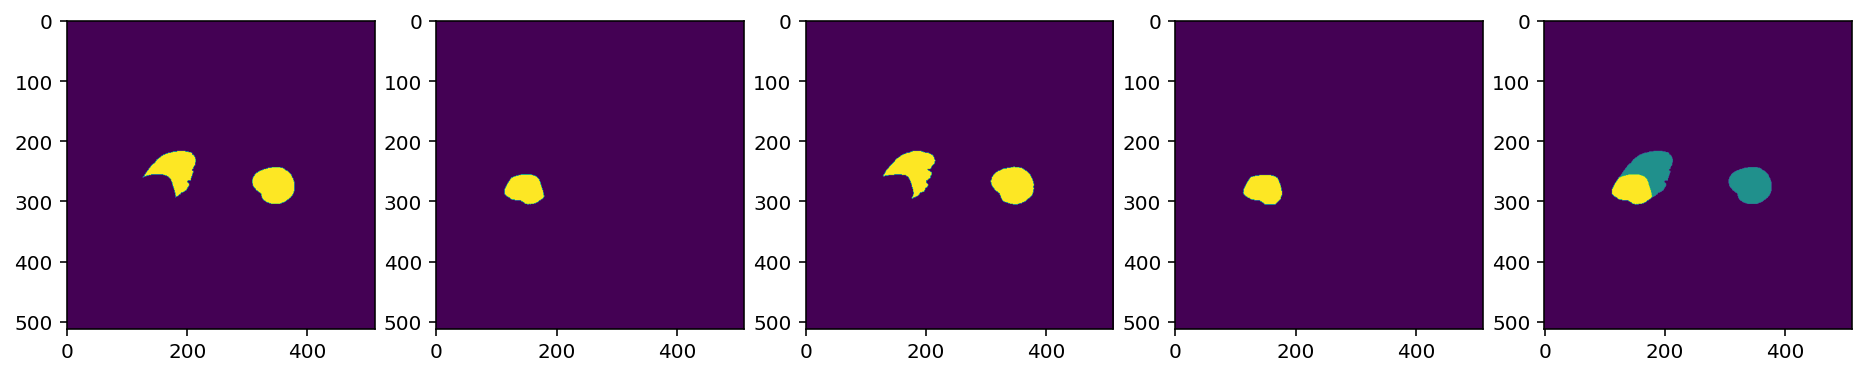

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 71 	Training Loss: 0.532575 	Validation Loss: 0.655869


  0%|          | 0/5813 [00:00<?, ?it/s]

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


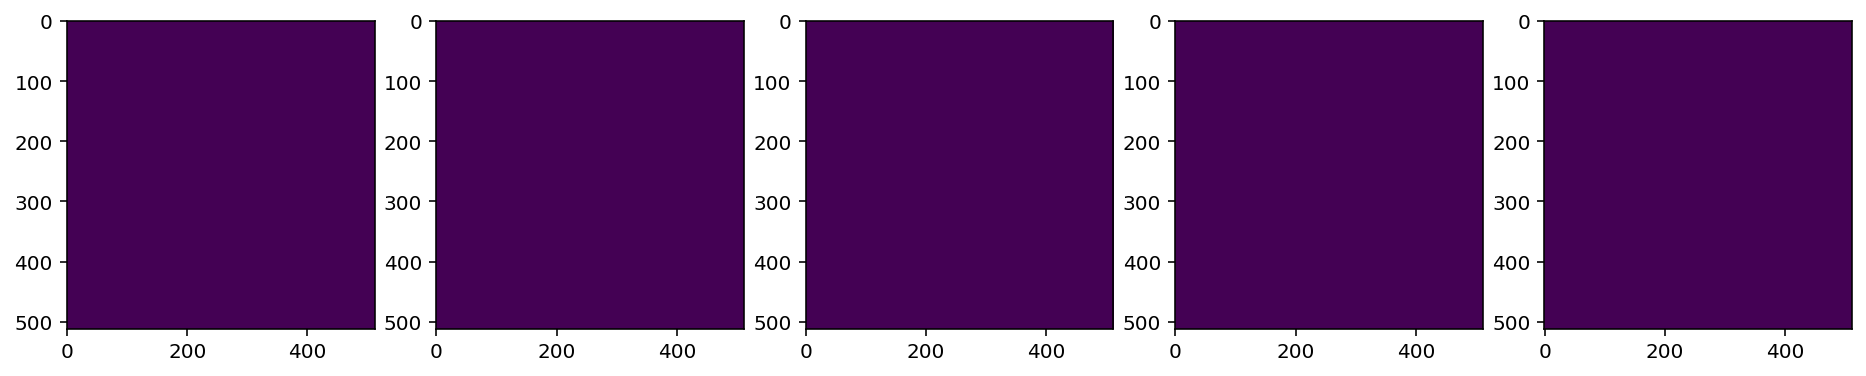

0.9839135093141305


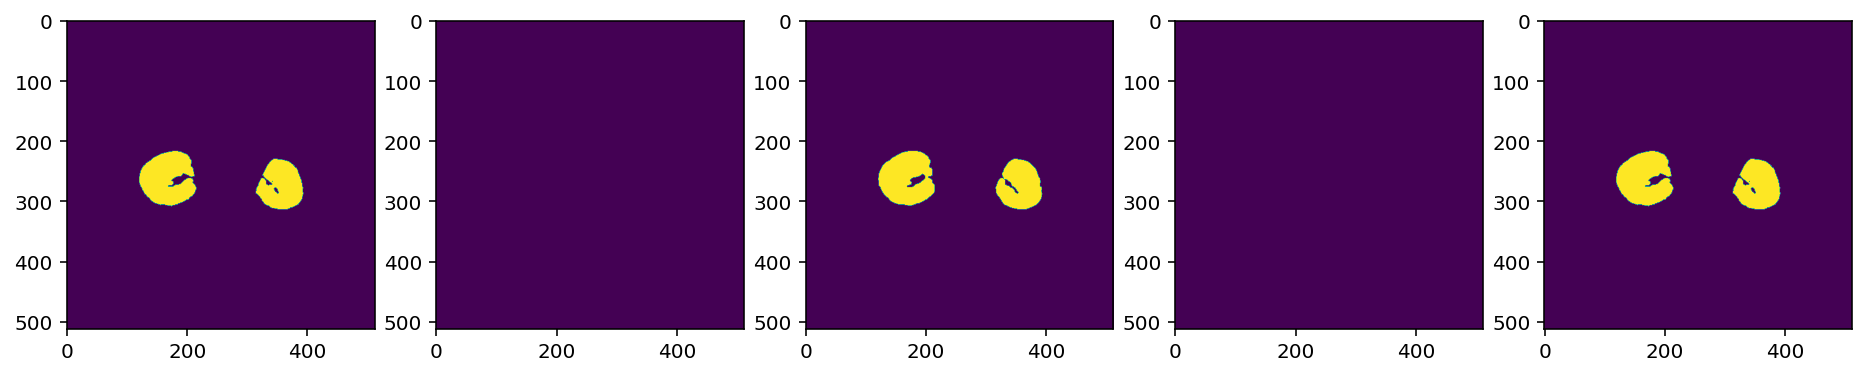

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 72 	Training Loss: 0.532575 	Validation Loss: 0.670928


  0%|          | 0/5813 [00:00<?, ?it/s]

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


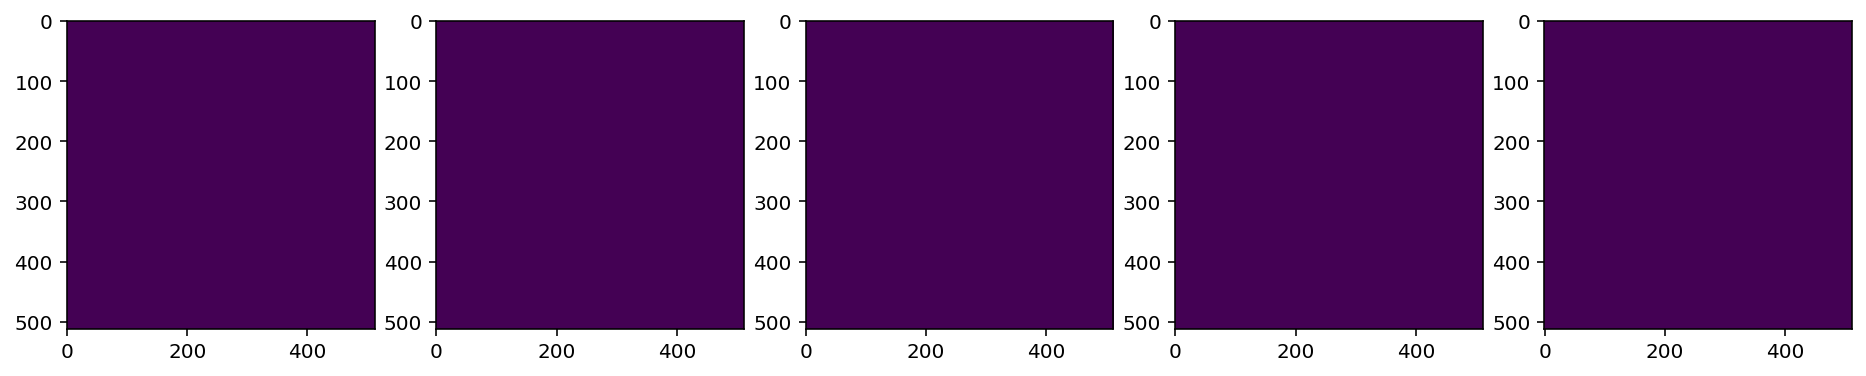

0.9413195633335263


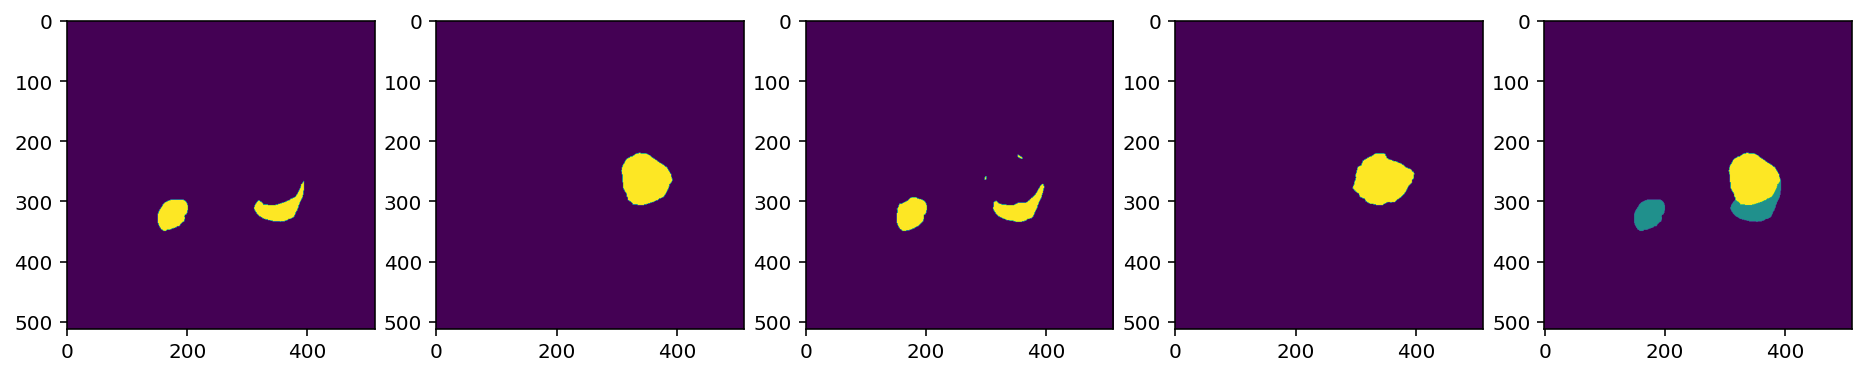

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 73 	Training Loss: 0.532575 	Validation Loss: 0.657612


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9936069217888972


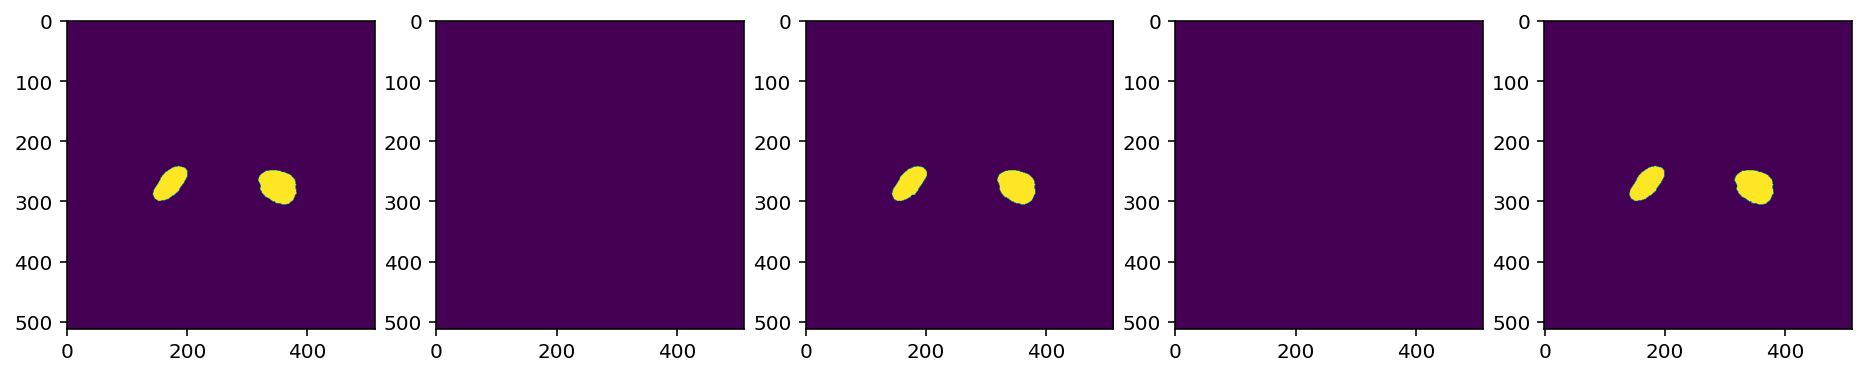

0.989571416571025


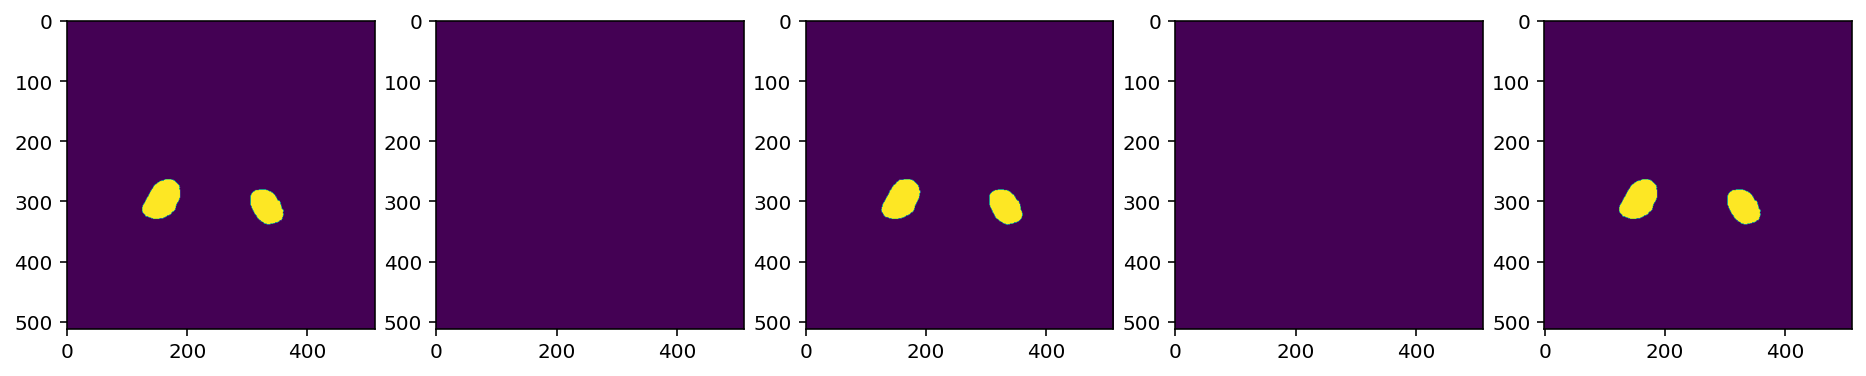

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 74 	Training Loss: 0.532575 	Validation Loss: 0.656824


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9906782065308739


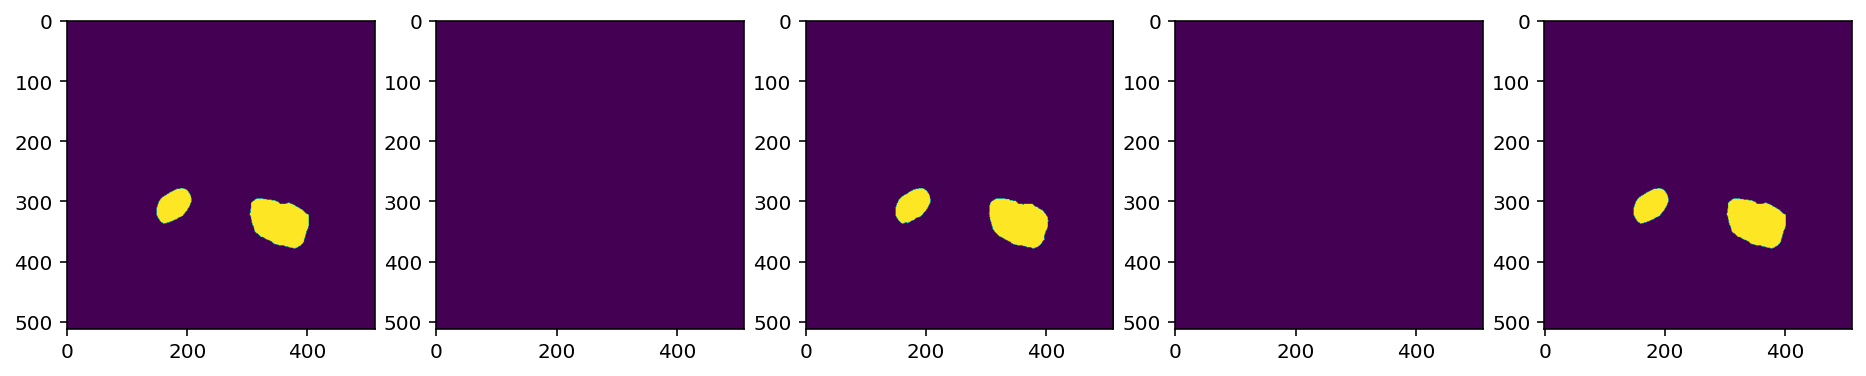

0.9191322816609642


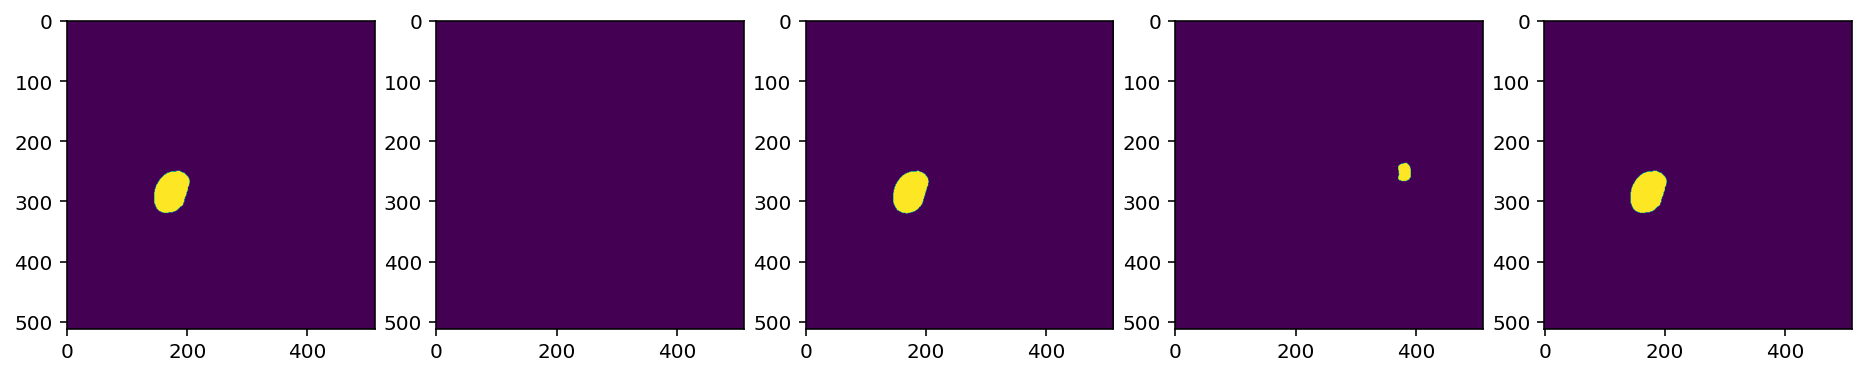

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 75 	Training Loss: 0.532574 	Validation Loss: 0.669890


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9857550284218736


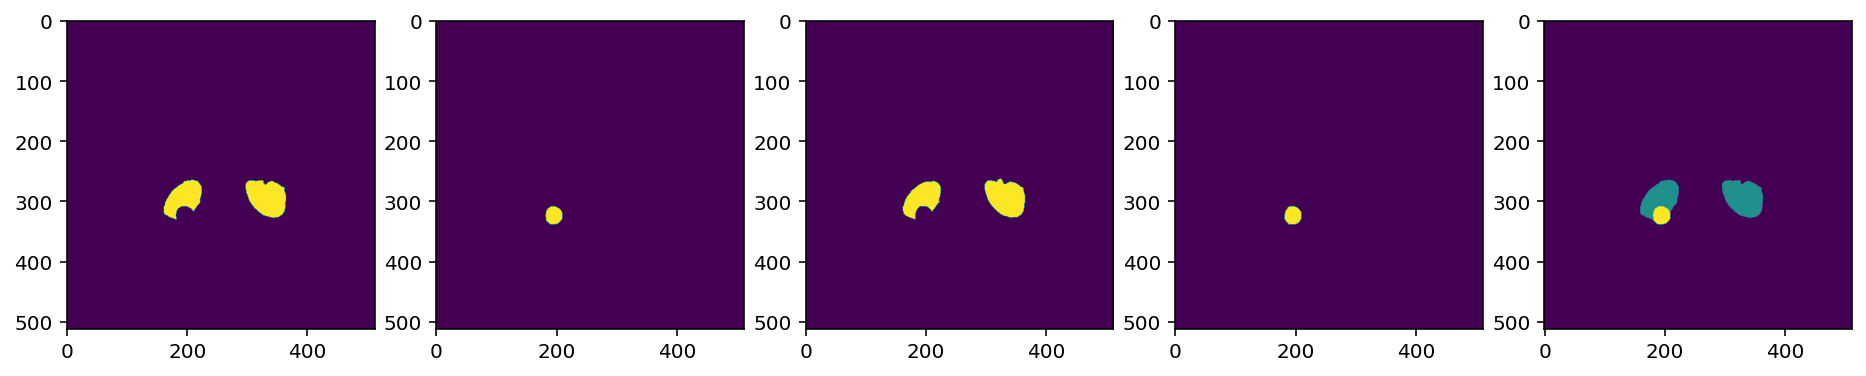

0.992551106884116


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 76 	Training Loss: 0.532575 	Validation Loss: 0.664192


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9587867542353465


0.8671581630737399


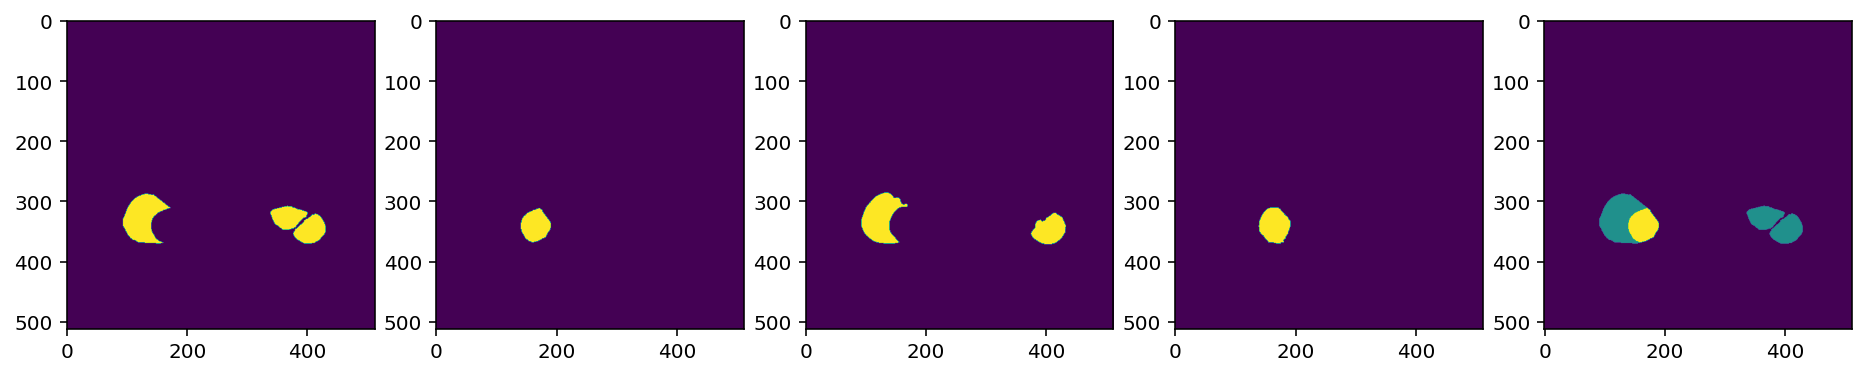

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 77 	Training Loss: 0.532575 	Validation Loss: 0.667499


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9929391418400012


0.9747381975397813


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 78 	Training Loss: 0.532575 	Validation Loss: 0.664248


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9805641215081593


0.9843935194873372


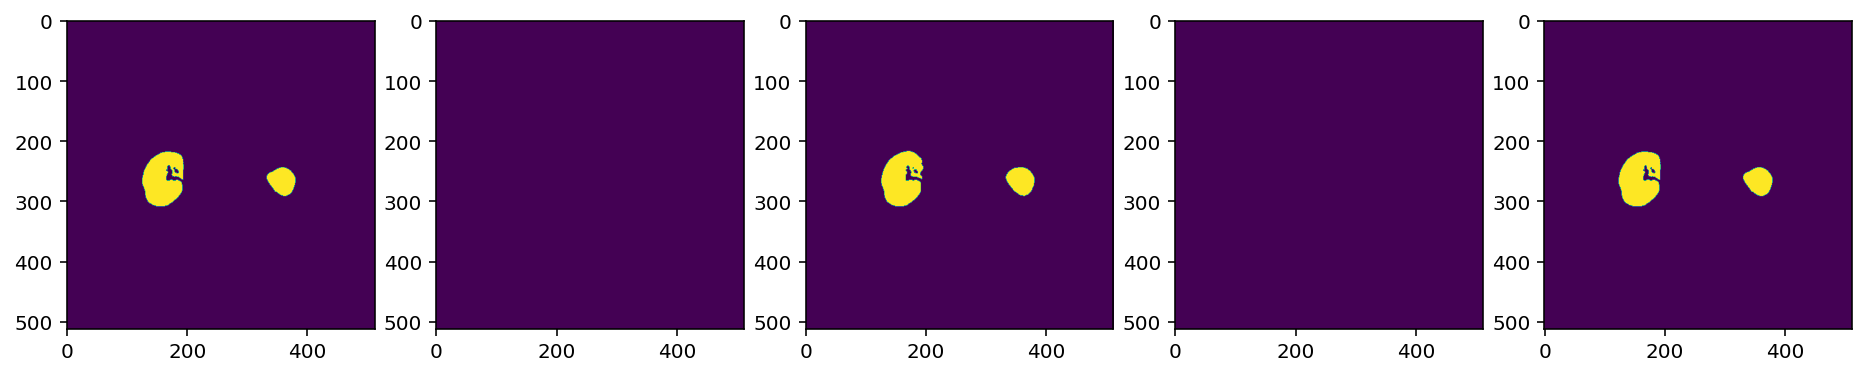

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 79 	Training Loss: 0.532574 	Validation Loss: 0.660555


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9761920473518282


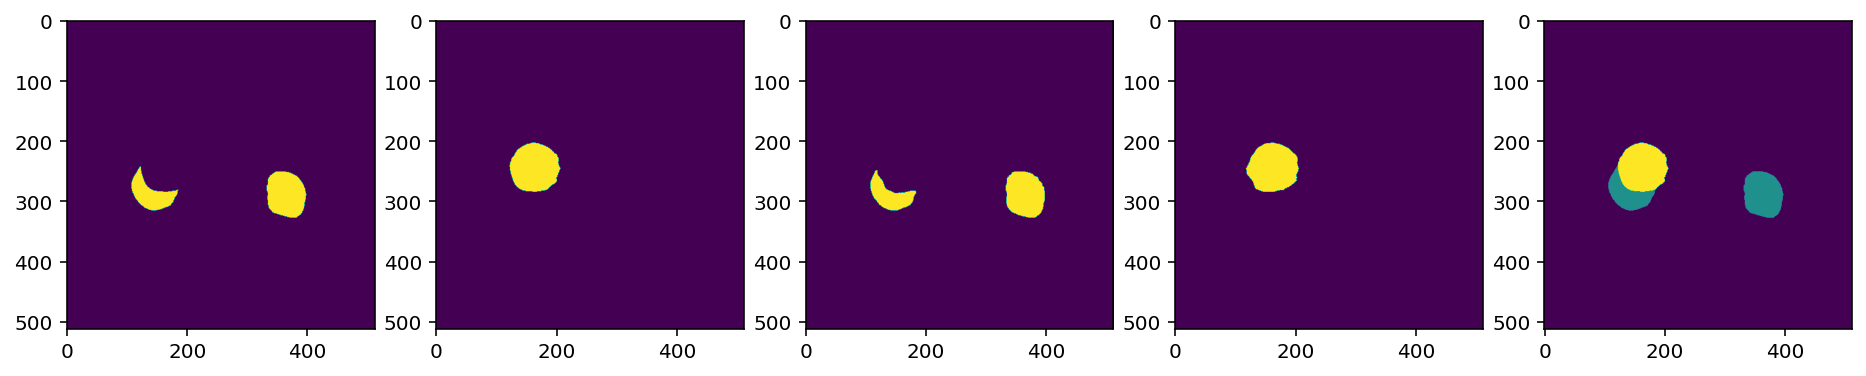

0.49999141693115234


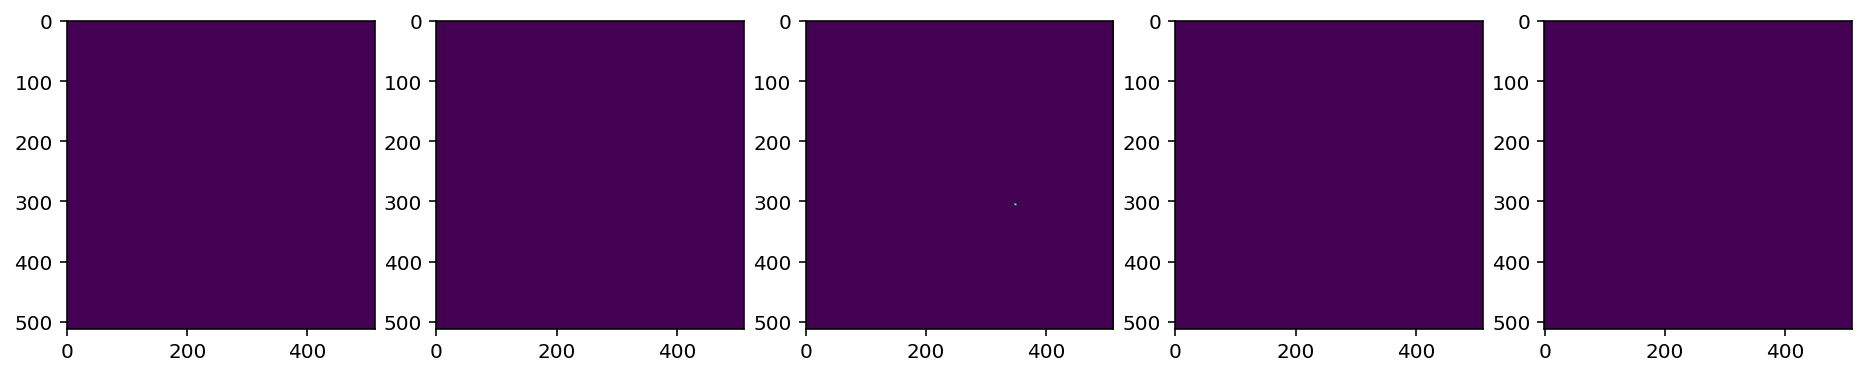

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 80 	Training Loss: 0.532574 	Validation Loss: 0.651805


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9866296966297666


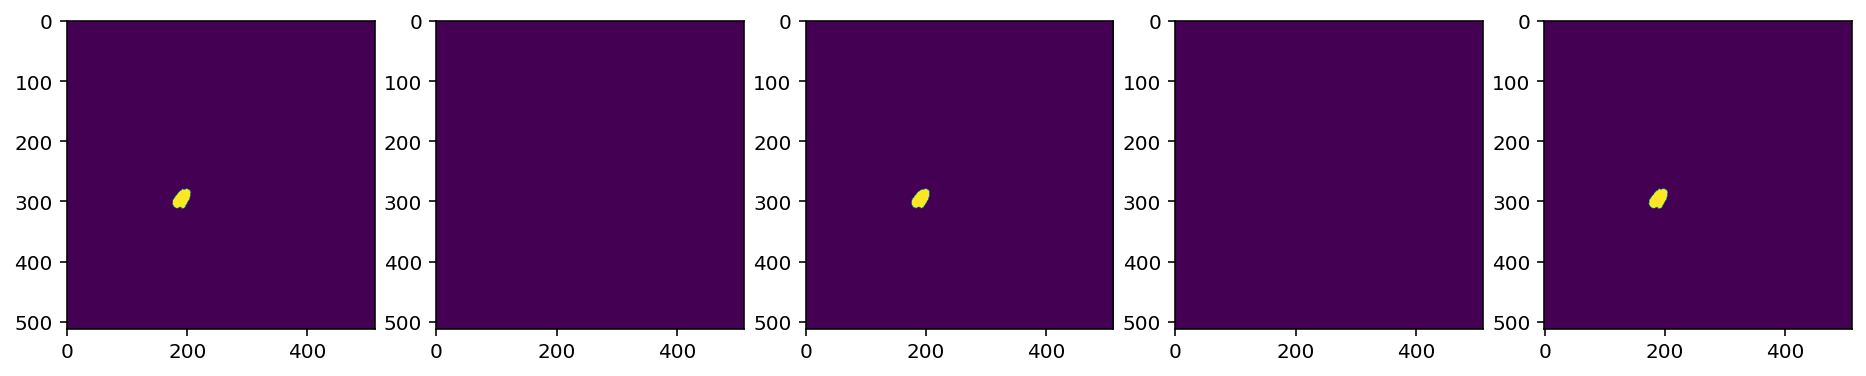

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


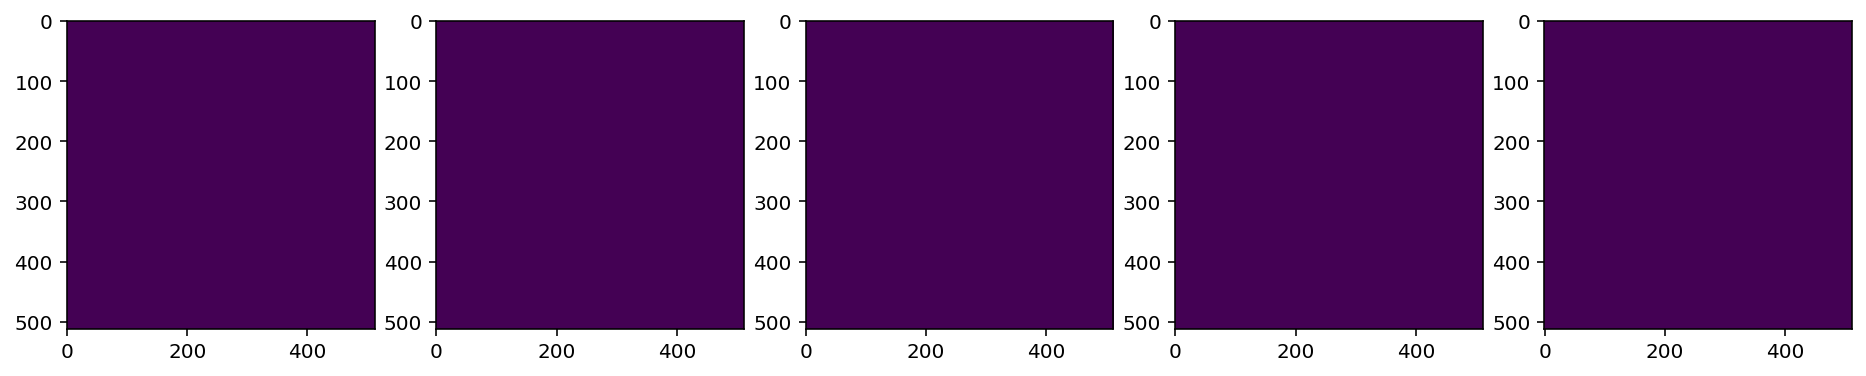

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 81 	Training Loss: 0.532574 	Validation Loss: 0.674774


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9836172016268149


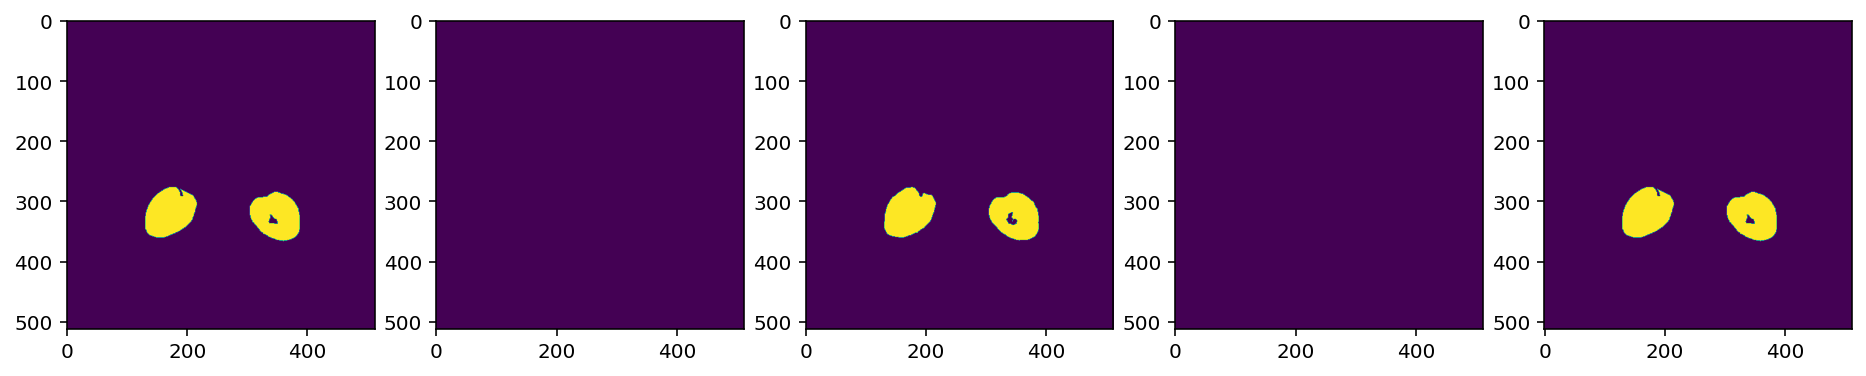

0.9859059499349367


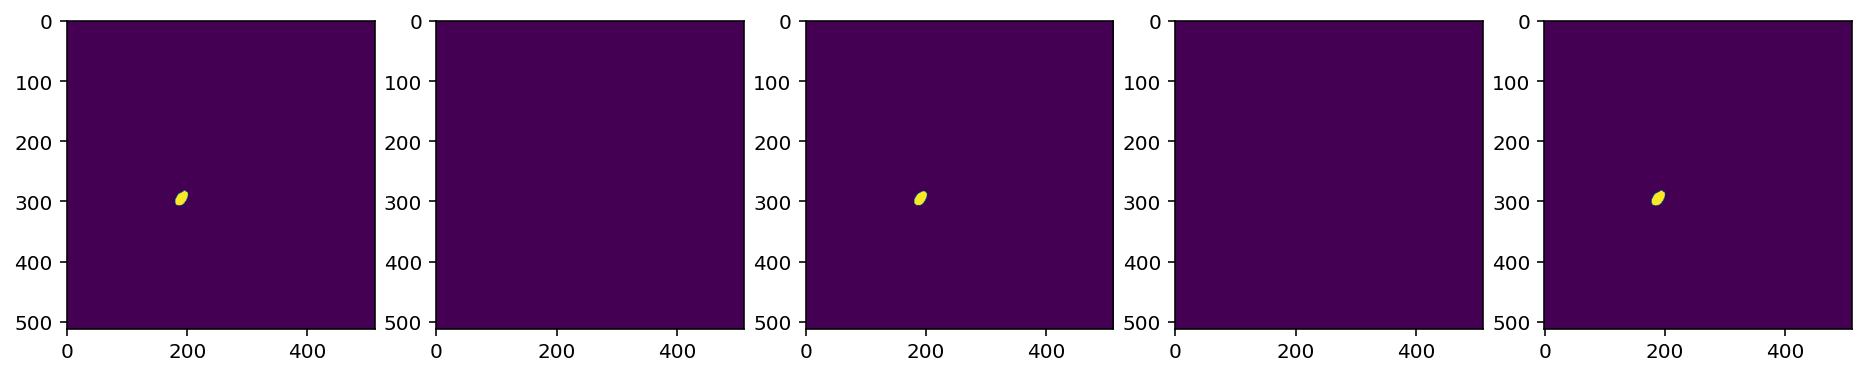

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 82 	Training Loss: 0.532575 	Validation Loss: 0.662957


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9704462559196161


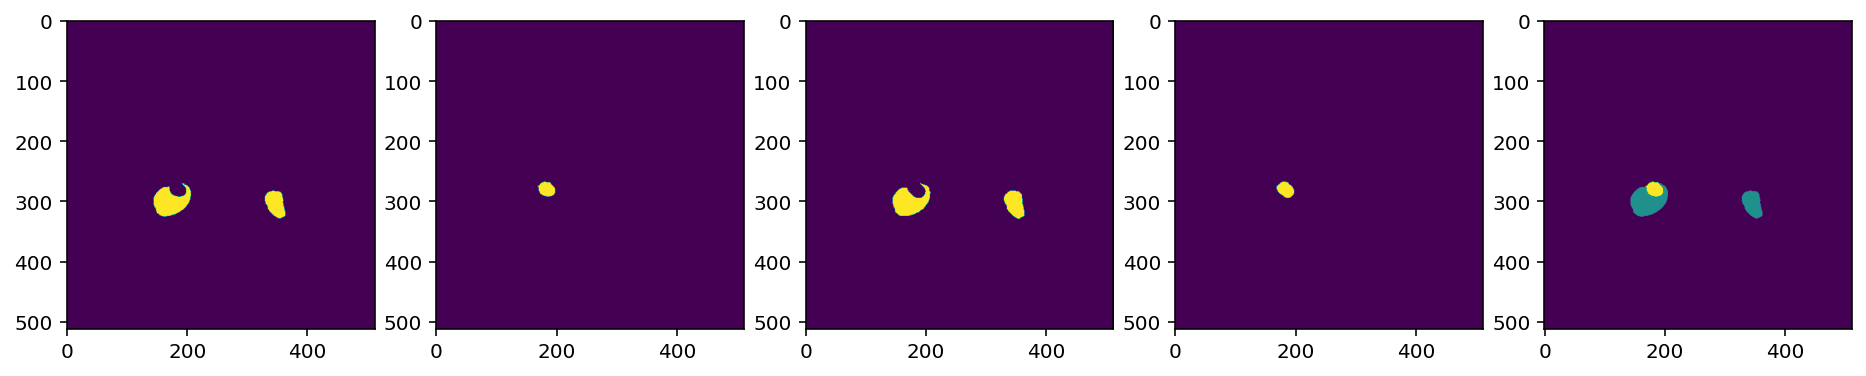

0.9852869941449804


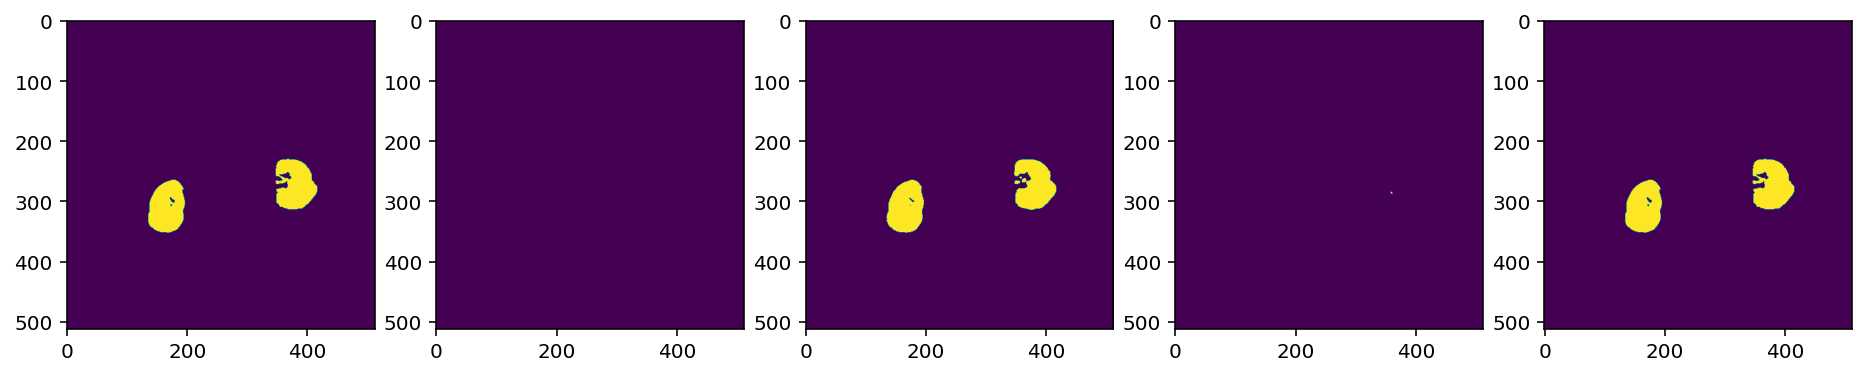

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 83 	Training Loss: 0.532574 	Validation Loss: 0.662081


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9813751398883589


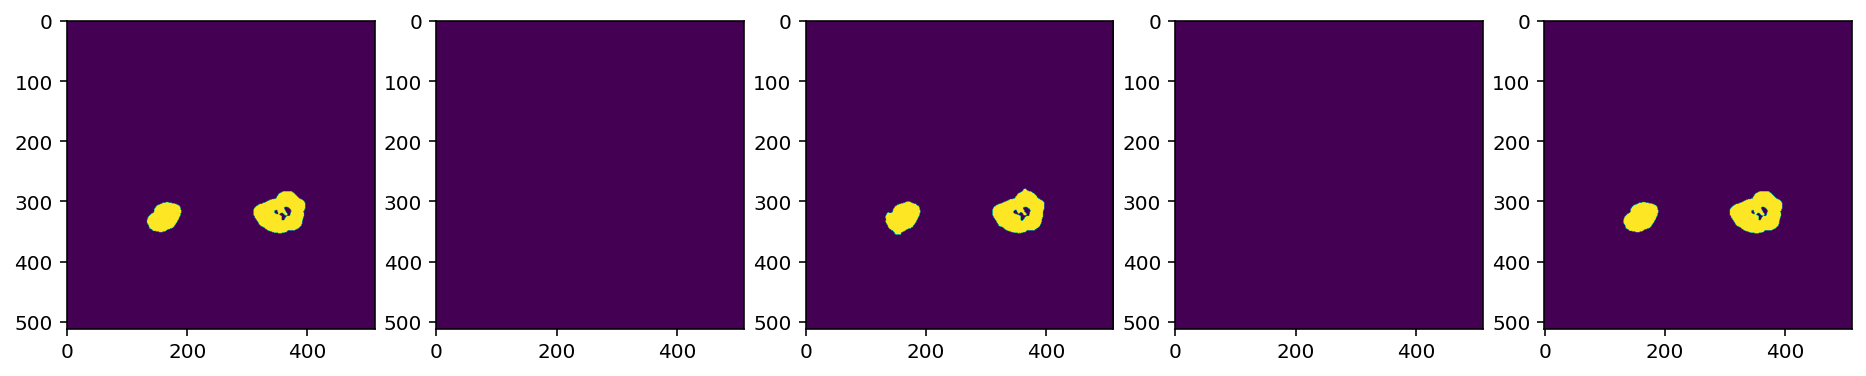

0.9801070232317184


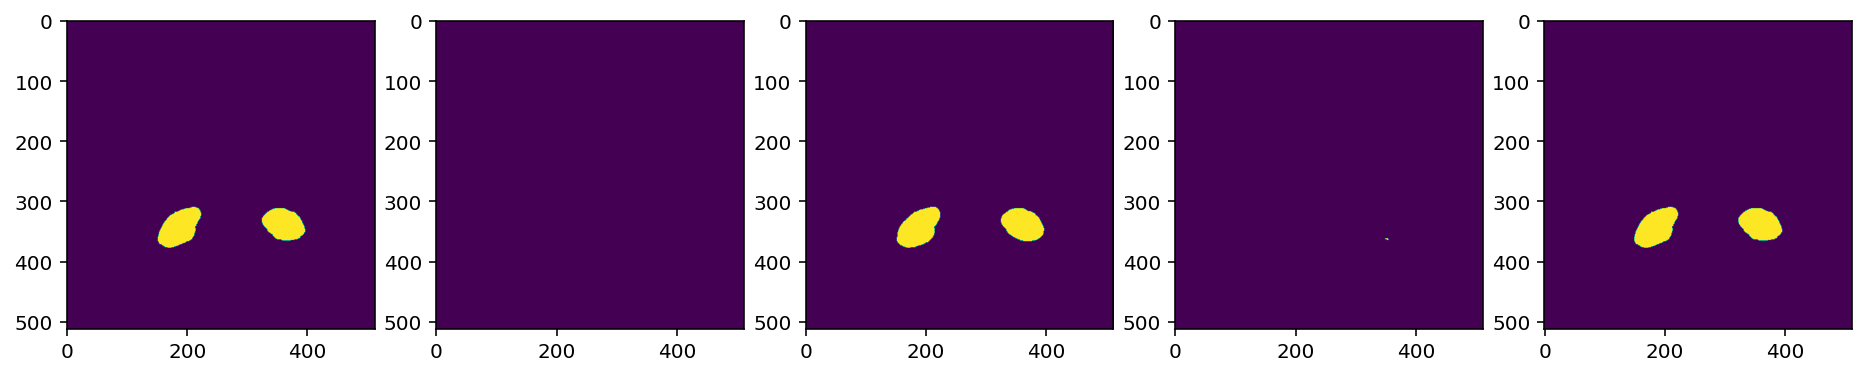

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 84 	Training Loss: 0.532576 	Validation Loss: 0.670089


  0%|          | 0/5813 [00:00<?, ?it/s]

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


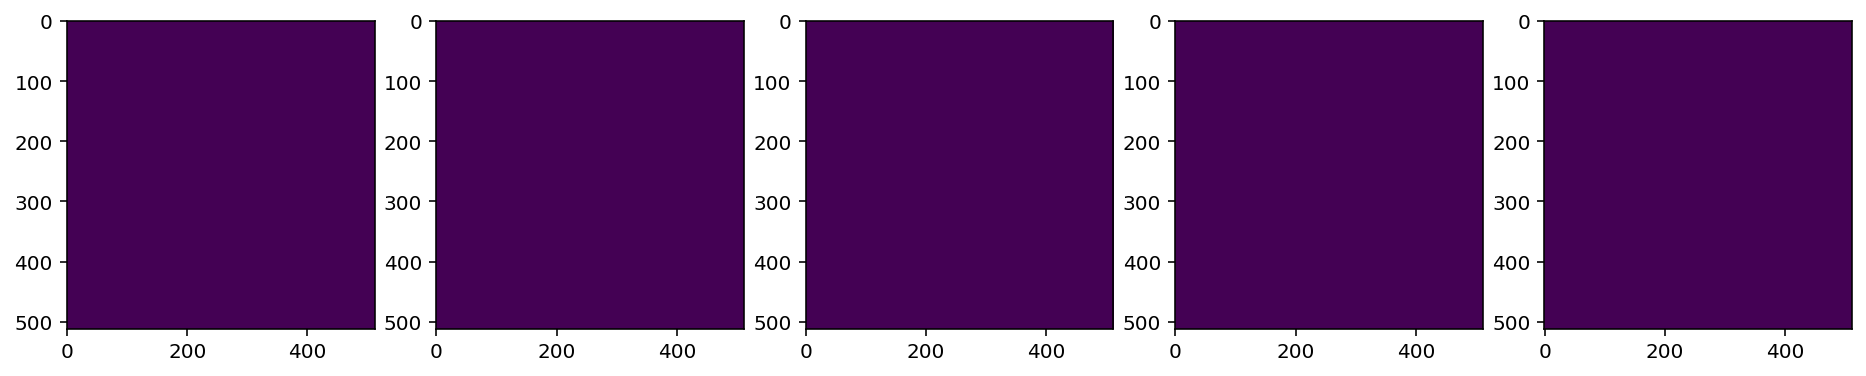

0.9549425074426808


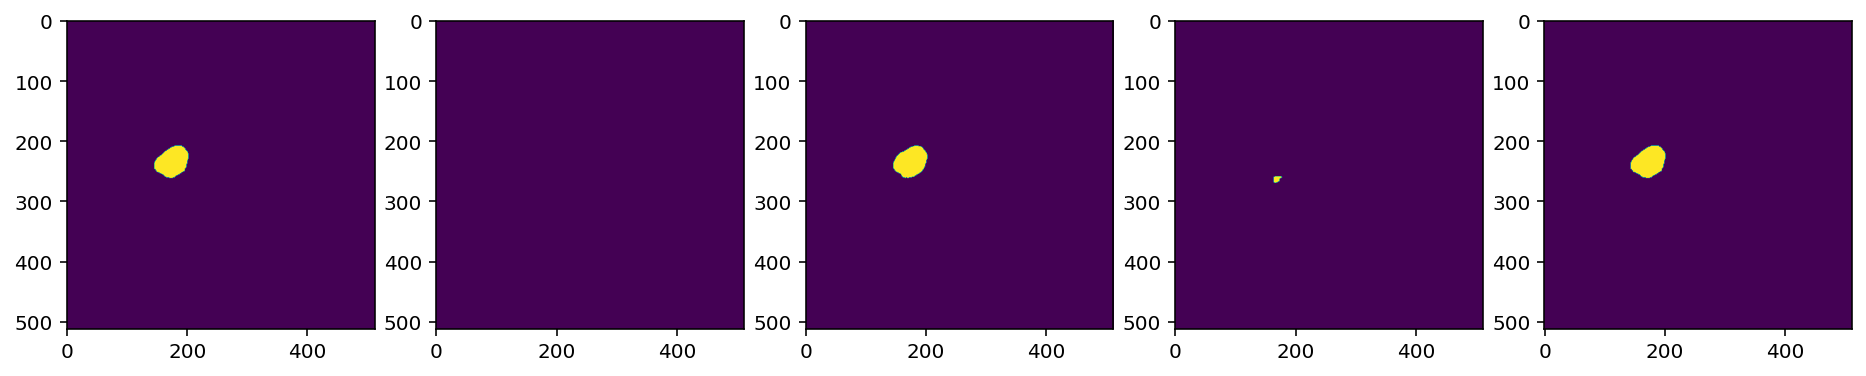

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 85 	Training Loss: 0.532574 	Validation Loss: 0.663278


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9874699015637131


0.9406213285590874


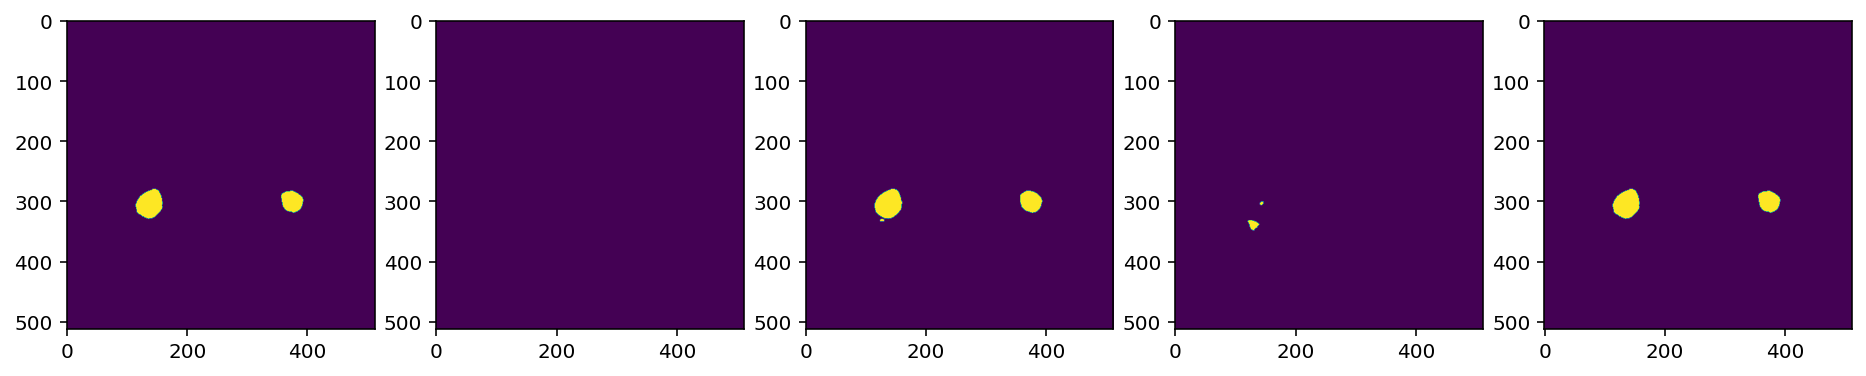

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 86 	Training Loss: 0.532574 	Validation Loss: 0.654742


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9702835415707012


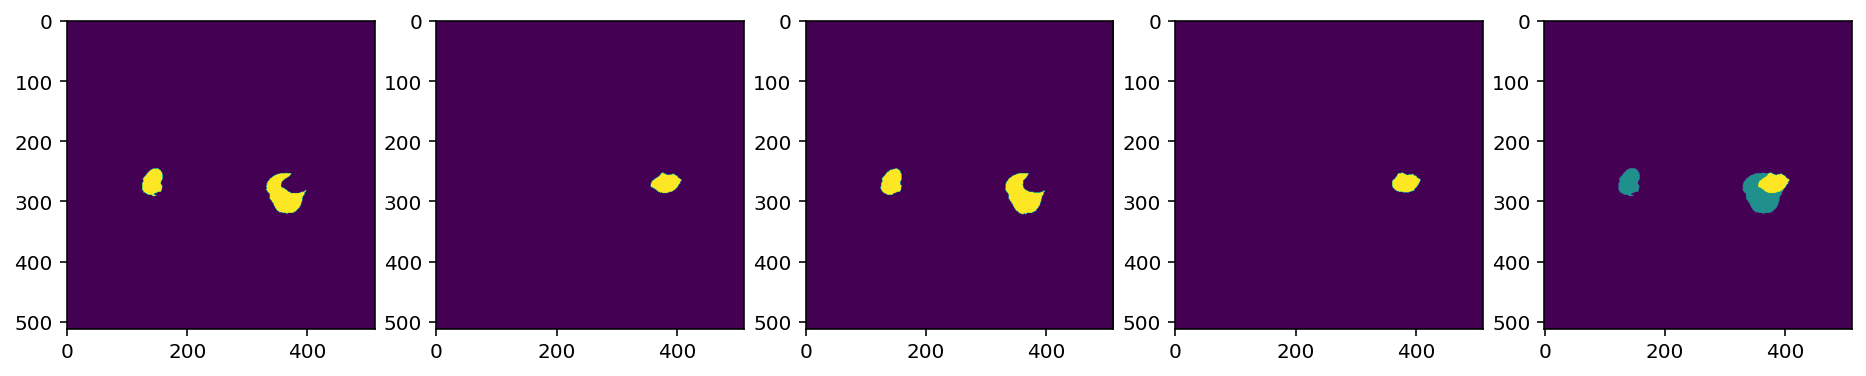

0.9693054339305054


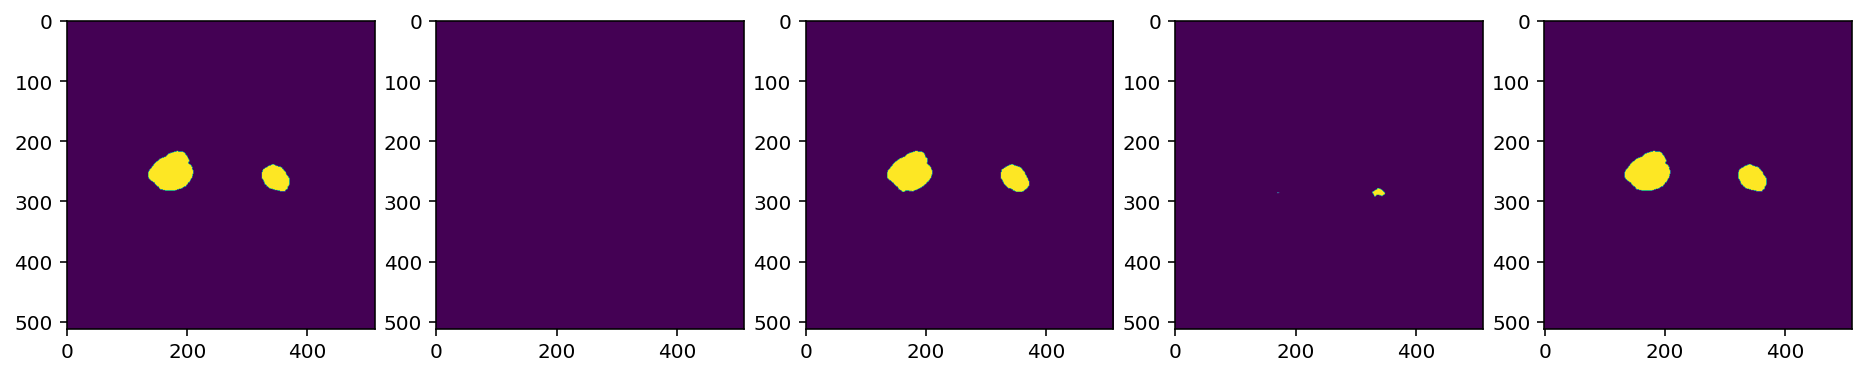

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 87 	Training Loss: 0.532574 	Validation Loss: 0.660756


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9843935194873372


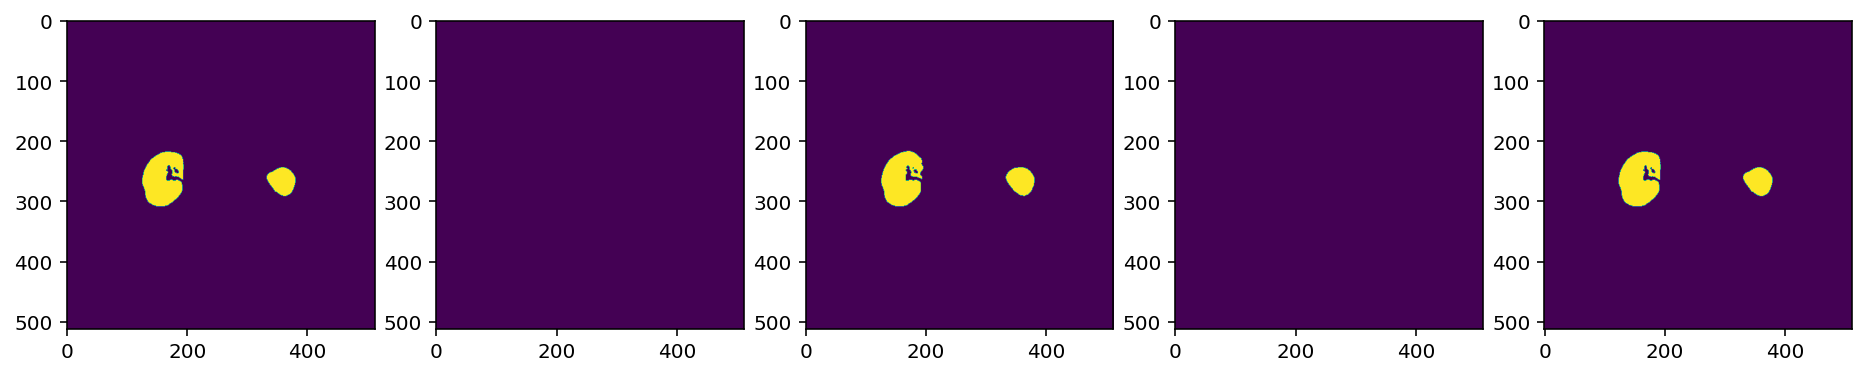

0.9853830638237409


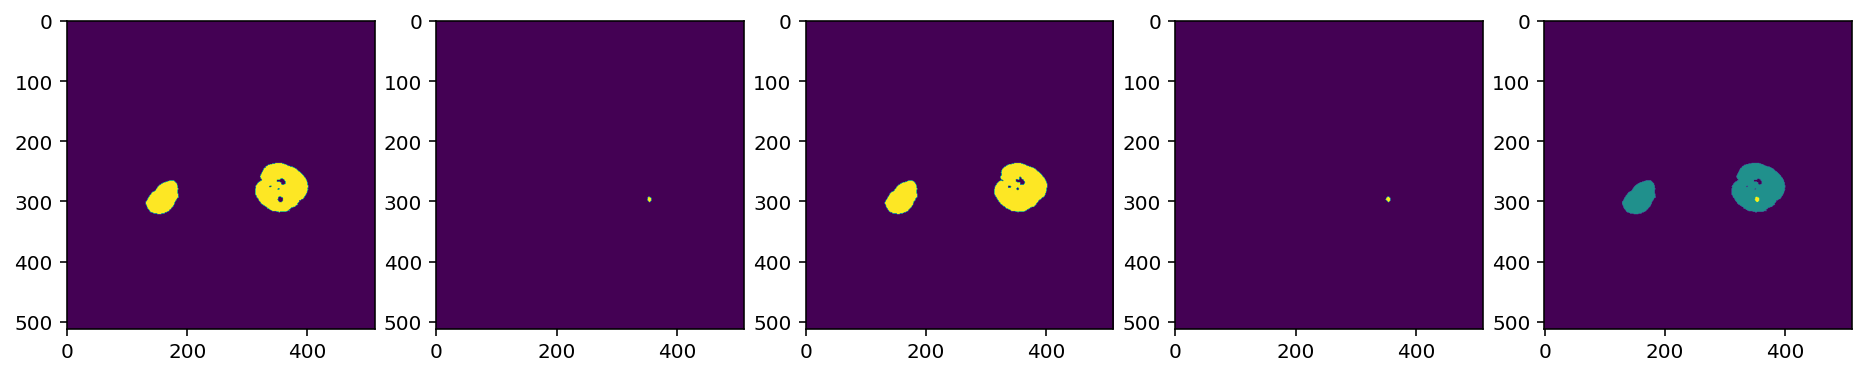

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 88 	Training Loss: 0.532574 	Validation Loss: 0.674432


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9055206226706206


0.9723414977195228


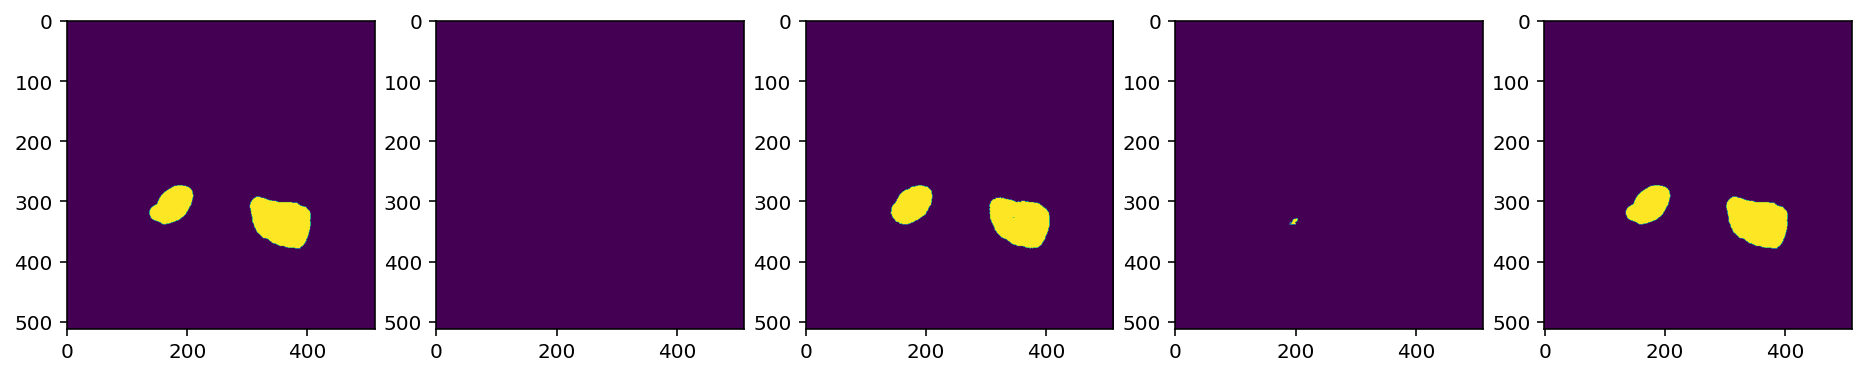

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 89 	Training Loss: 0.532575 	Validation Loss: 0.656631


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9781277468503653


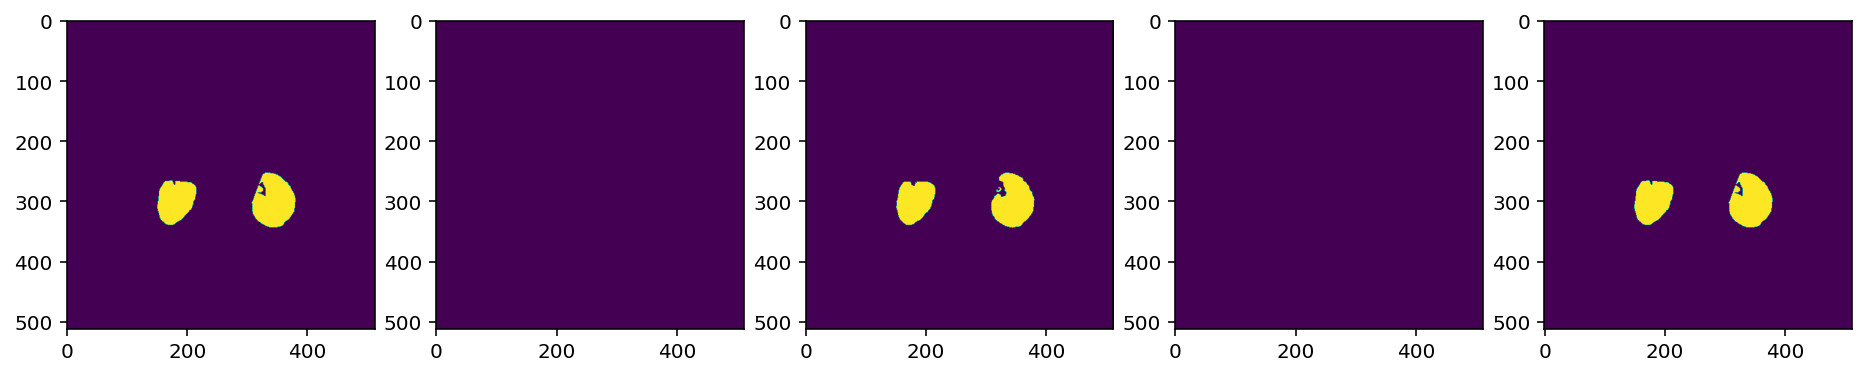

0.9862201977960487


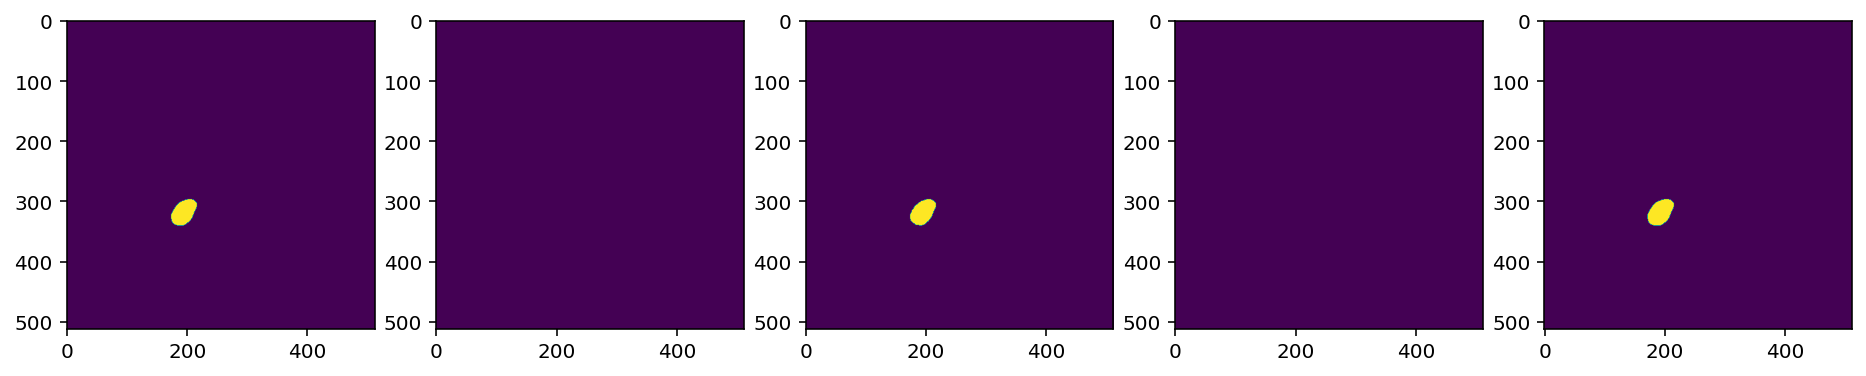

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 90 	Training Loss: 0.532573 	Validation Loss: 0.658172


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9696331161266019


0.868653054800111


<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


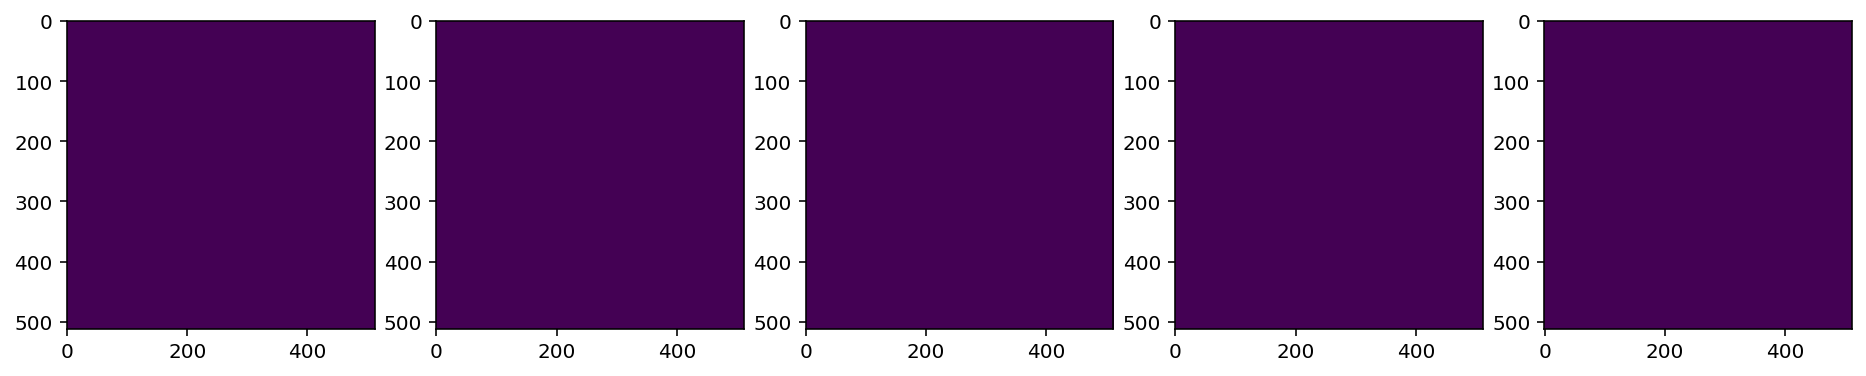

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 91 	Training Loss: 0.532574 	Validation Loss: 0.661272


  0%|          | 0/5813 [00:00<?, ?it/s]

0.4997549057006836


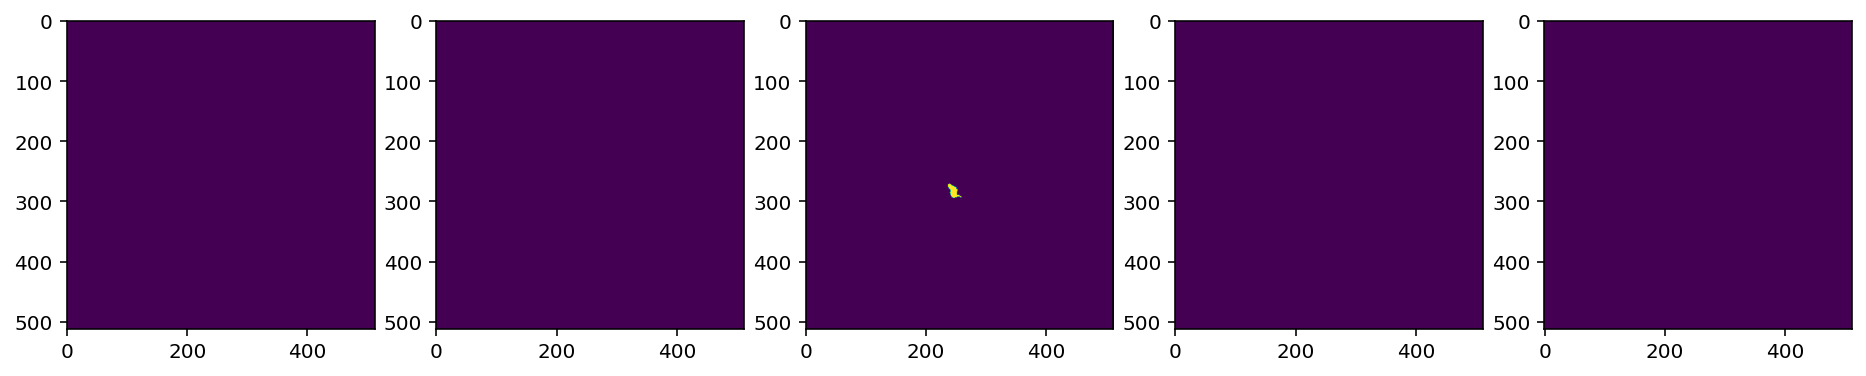

0.8058239001911535


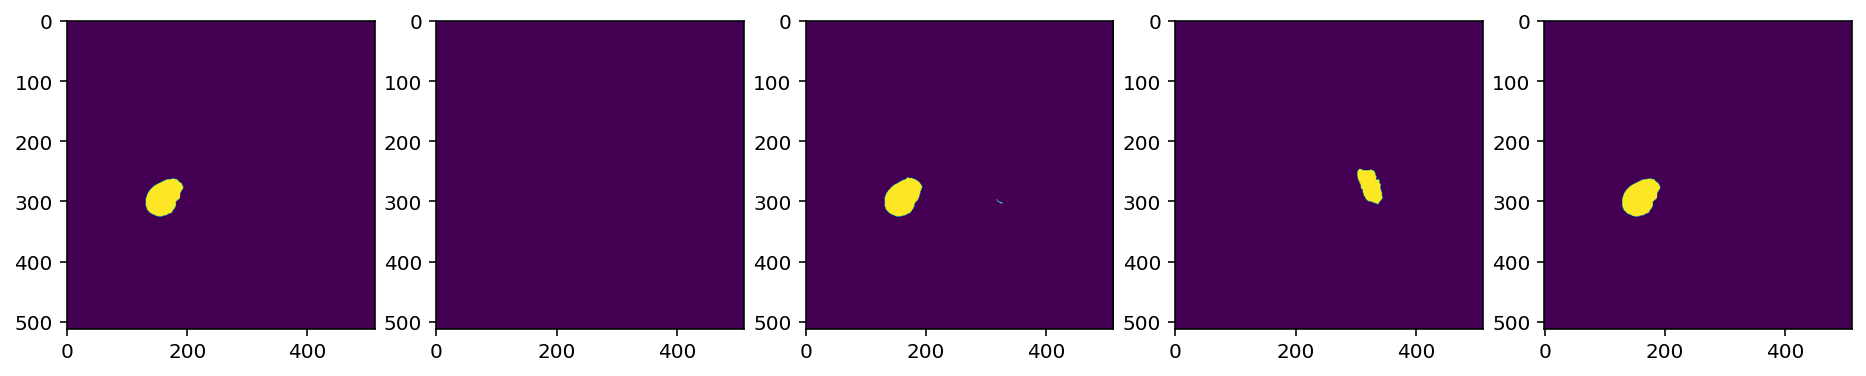

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 92 	Training Loss: 0.532574 	Validation Loss: 0.696572


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9794336528503443


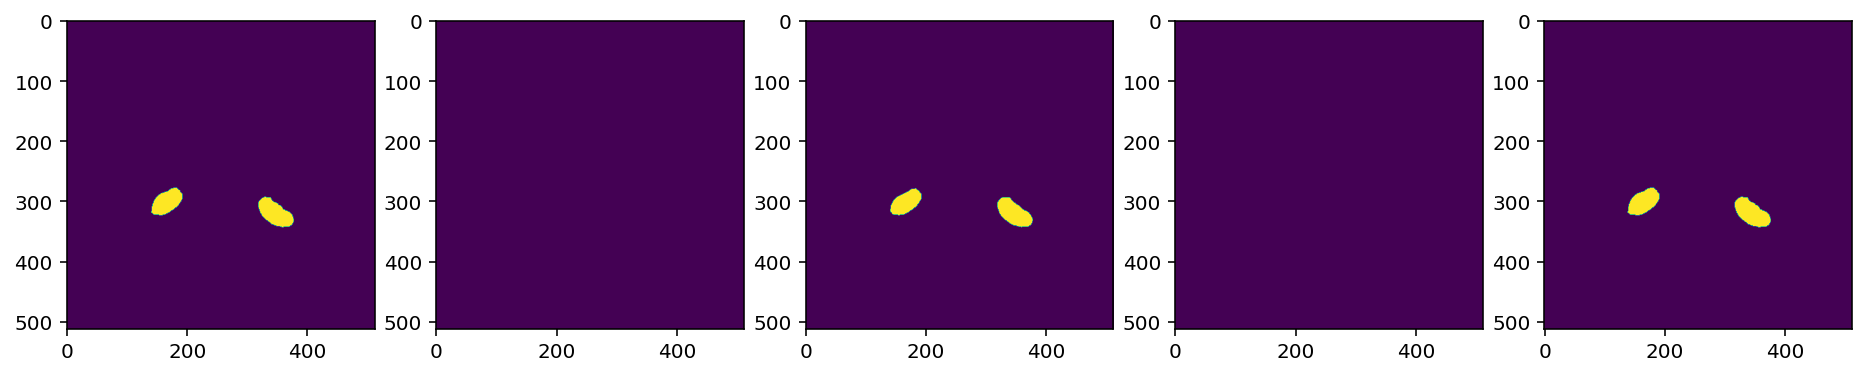

0.9734580451785404


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 93 	Training Loss: 0.532574 	Validation Loss: 0.659644


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9845912603871947


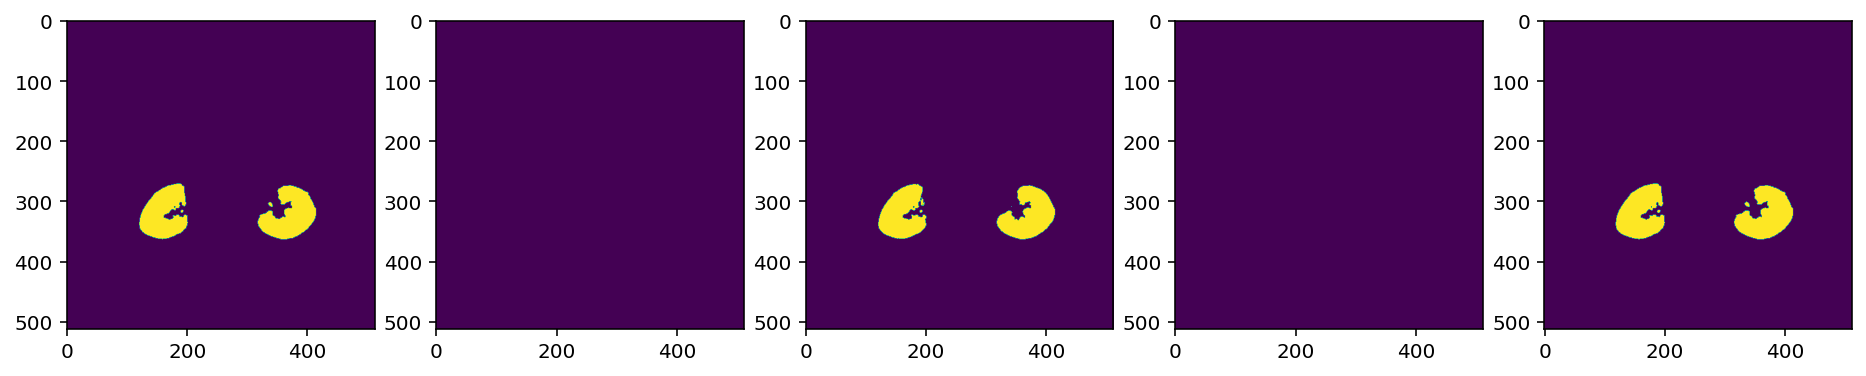

0.4999866485595703


  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 94 	Training Loss: 0.532574 	Validation Loss: 0.667732


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9656392570152663


0.9903175538293354


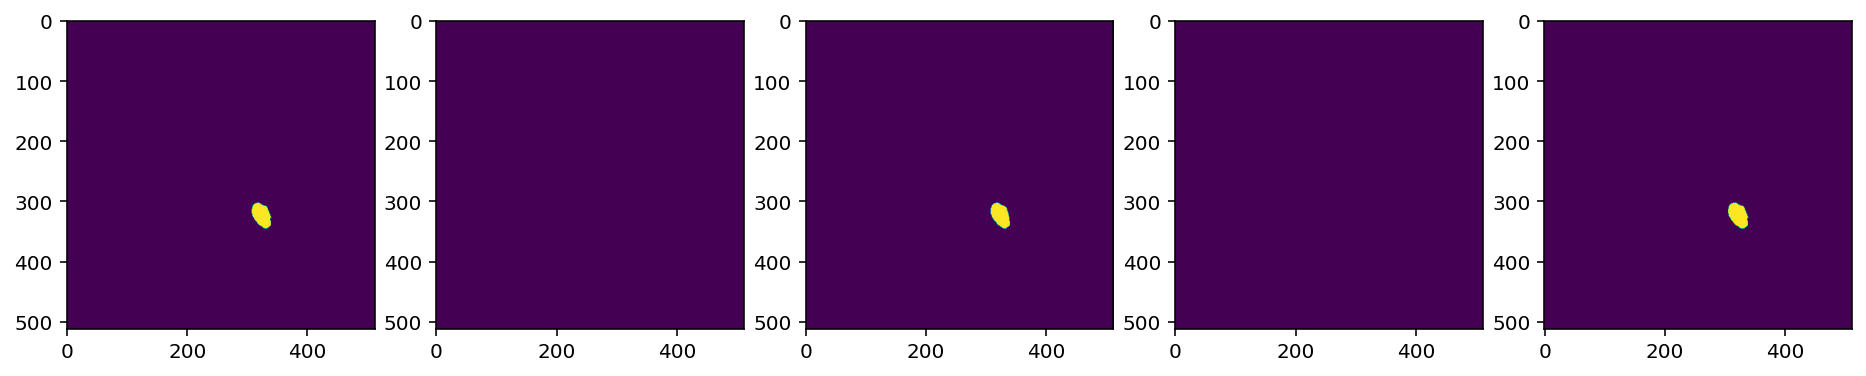

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 95 	Training Loss: 0.532574 	Validation Loss: 0.662060


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9663148340916534


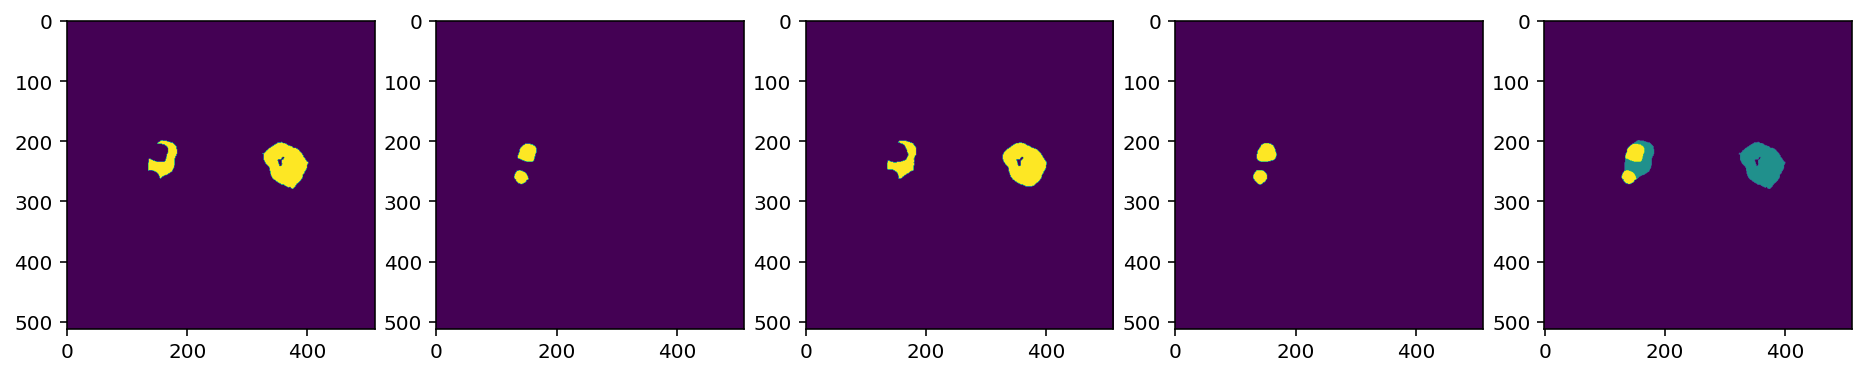

0.983156172046701


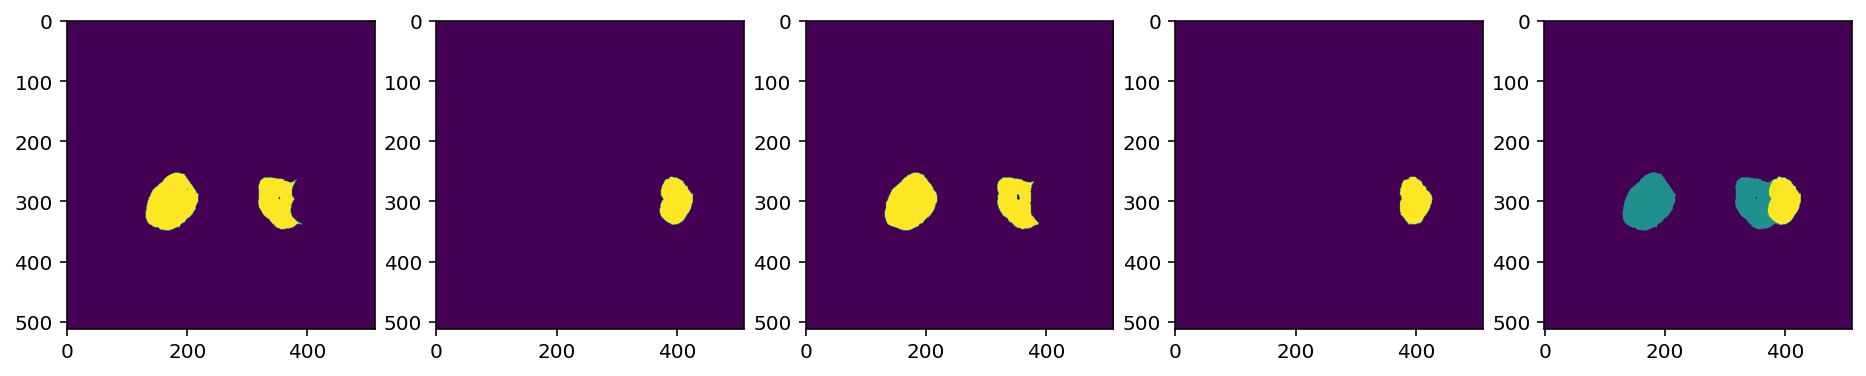

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 96 	Training Loss: 0.532574 	Validation Loss: 0.661587


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9046587326437192


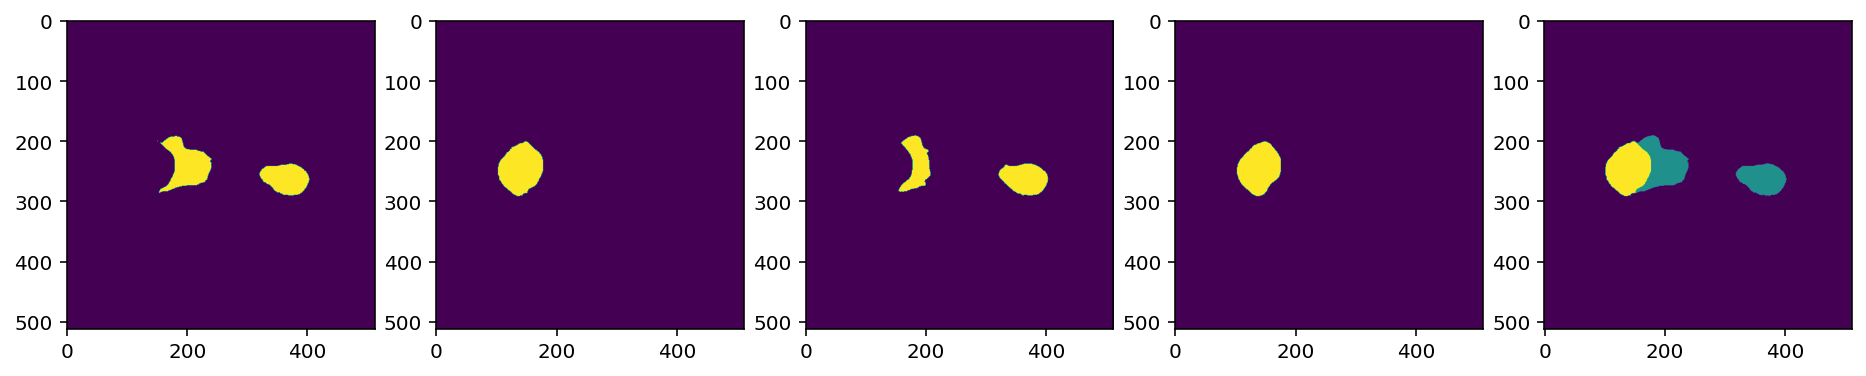

0.9805064949413889


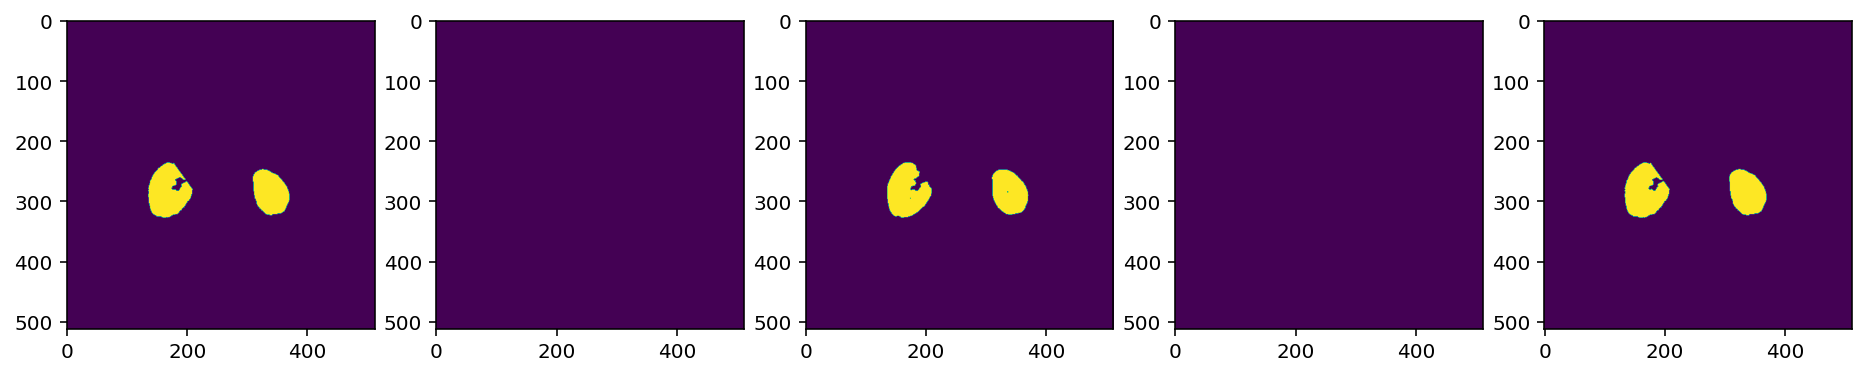

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 97 	Training Loss: 0.532573 	Validation Loss: 0.679962


  0%|          | 0/5813 [00:00<?, ?it/s]

0.9912712573673884


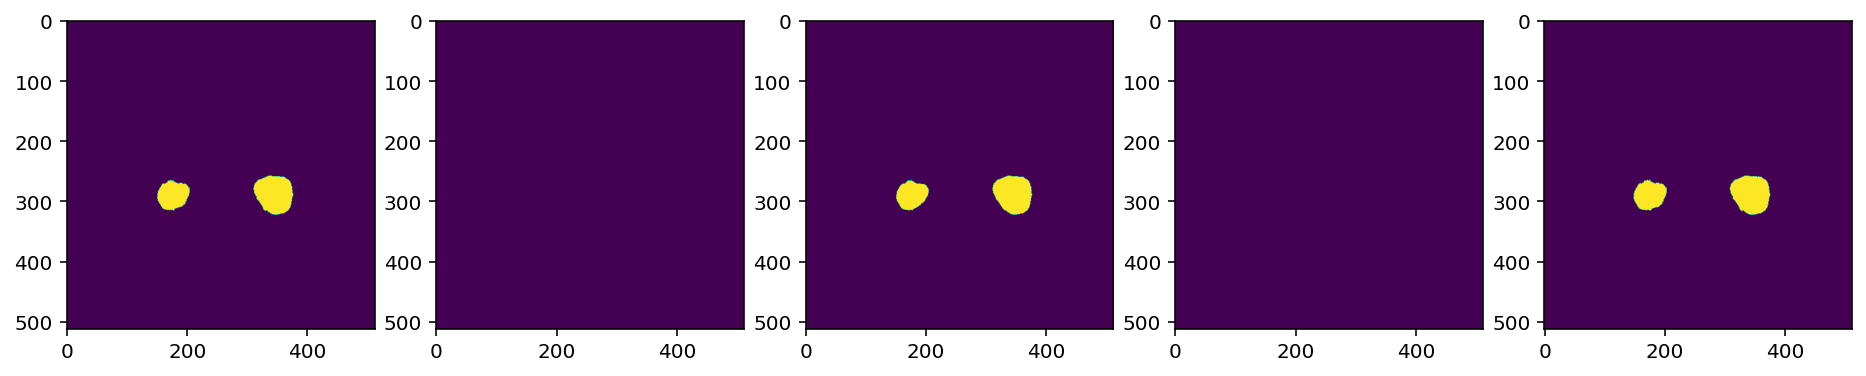

0.9820336273322692


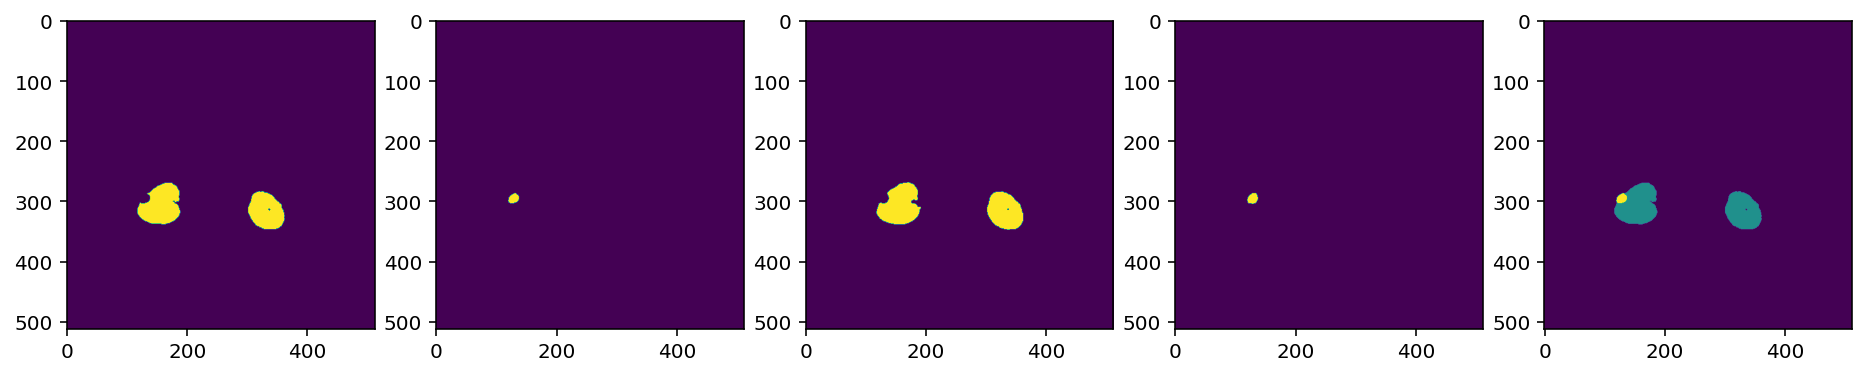

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 98 	Training Loss: 0.532575 	Validation Loss: 0.668754


  0%|          | 0/5813 [00:00<?, ?it/s]

0.49988842010498047


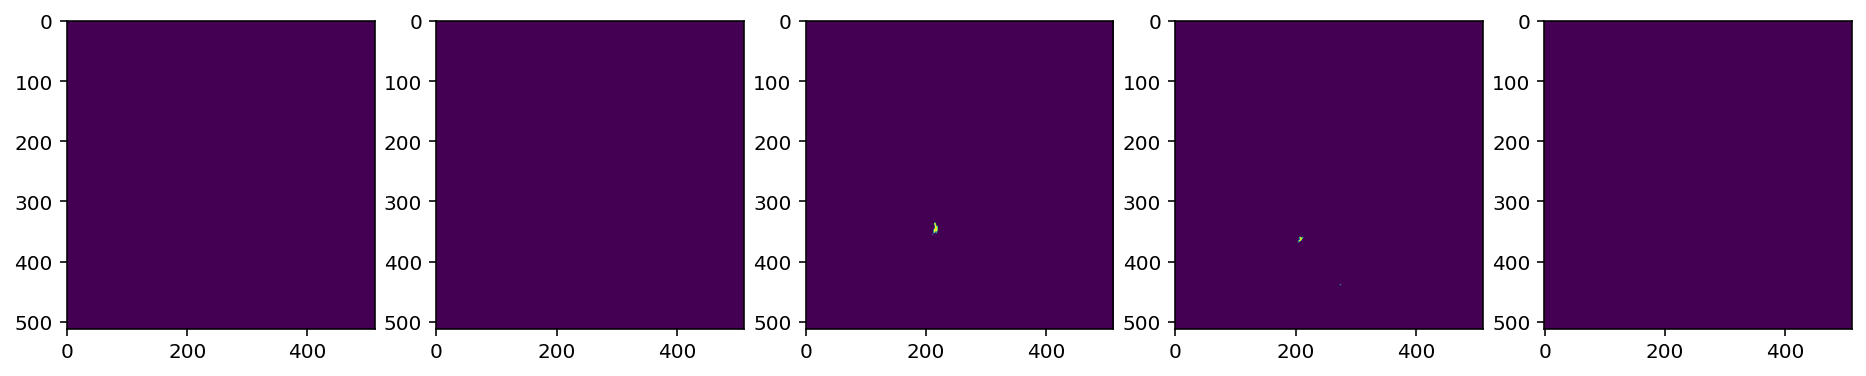

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)


nan


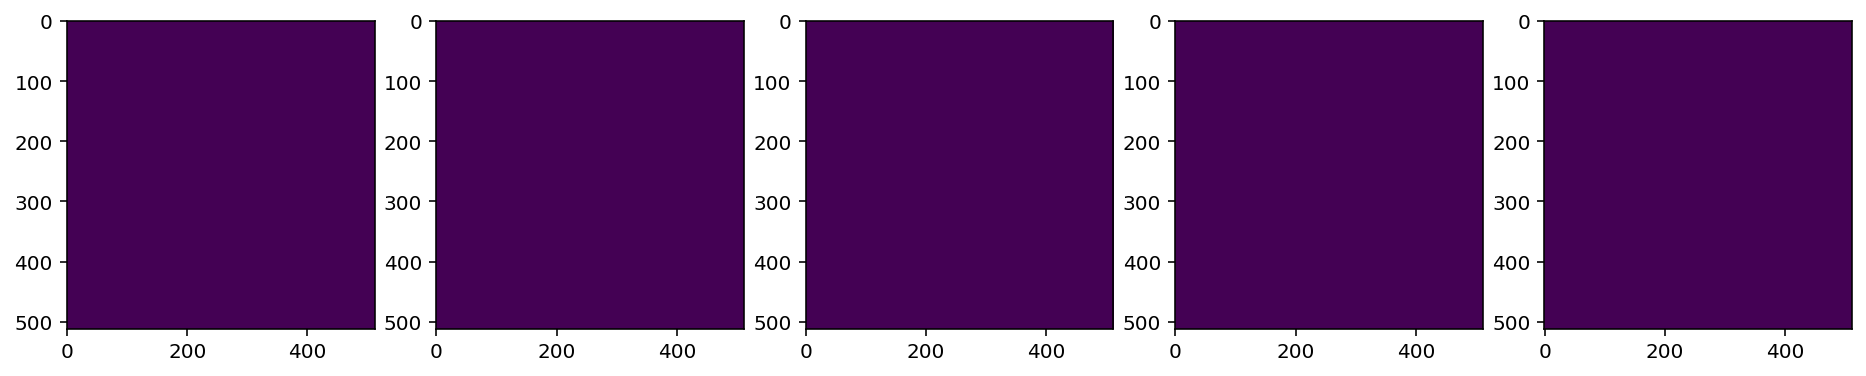

  0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 99 	Training Loss: 0.532573 	Validation Loss: 0.652363


In [22]:
n_epochs =100
cnt =0
valid_loss_min = 0.652412 # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)
Iou=0
model.to(device)
for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model.train()
    for data, labels,a in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device) #cpu에 있는 데이터를 gpu에 보냄
        # clear the gradients of all optimized variables
#         print(data.shape)
#         break
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        # print(logits.shape)
        # print(labels.shape)
        # calculate the batch loss
        loss = criterion(logits, labels)
#         loss2 = criterion2(logits, labels)
#         loss=(loss+loss2)/2
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        
#         z=logits.detach().cpu().numpy()
#         z = z.astype(np.uint8)
        cnt = cnt+1
        
        
        if cnt %2875==0:
            
            logits = logits.sigmoid()
            logits = mask_binarization(logits.detach().cpu(), 0.5)
            iou = compute_iou(logits,labels)
            # iou=  get_iou(logits,labels)
            print(iou)
            # y=torch.squeeze(labels[0])
            y=logits[0].detach().cpu().numpy()
            # x=data[0].detach().cpu().numpy()
            x=labels[0].detach().cpu().numpy()
            #y=labels[0].numpy()
            plt.figure(figsize=(16,18))
            plt.subplot(1,5,1)
            plt.imshow(x[0])
            plt.subplot(1,5,2)
            plt.imshow(x[1])
            plt.subplot(1,5,3)
            plt.imshow(y[0])
            plt.subplot(1,5,4)
            plt.imshow(y[1])
            plt.subplot(1,5,5)
            plt.imshow(a[0])
            plt.show()

    
    train_loss[e] /= len(train_loader)
    #torch.save(model.state_dict(), 'model_.pt')
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        for data, labels,a in tqdm(val_loader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
#             loss2 = criterion2(logits, labels)
#             loss=(loss+loss2)/2
            # update average validation loss 
            valid_loss[e] += loss.item()

    
    # calculate average losses
    valid_loss[e] /= len(val_loader)
    scheduler.step(valid_loss[e])    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), 'model_best_2.pt')
        valid_loss_min = valid_loss[e]

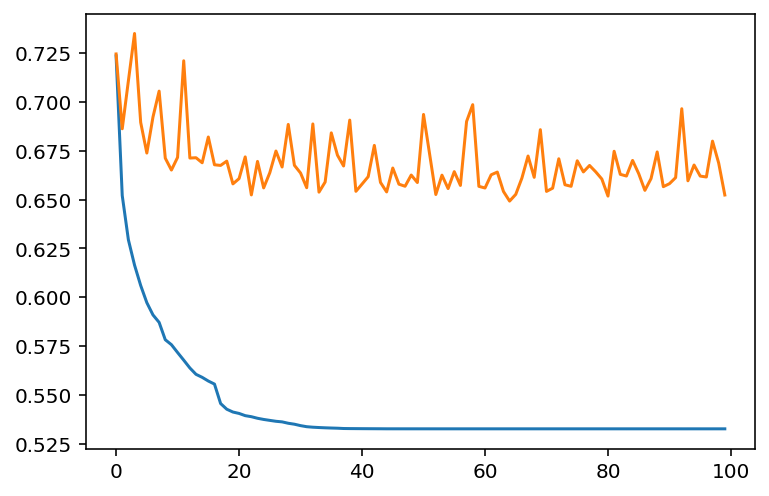

In [23]:
#Loss
plt.plot(train_loss)
plt.plot(valid_loss)

In [24]:
# model.load_state_dict(torch.load('model_.pt'))
model.load_state_dict(torch.load('model_best_2.pt'))

<All keys matched successfully>

In [25]:
class TestMyDataset(torch.utils.data.Dataset):
    def __init__(self, x_dir,y_dir,augmentation = False):
        super().__init__()
        self.augmentation = augmentation
        self.x_img = x_dir
        self.y_img = y_dir
     

    def __len__(self):
        return len(self.x_img)
    

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        y_img = self.y_img[idx]
        # Read an image with OpenCV  
        x_img = dcm.read_file(x_img)
        x_img=read_dicom(x_img,400,0)
        x_img=np.transpose(x_img,(2,0,1))
        x_img=x_img.astype(np.float32)
        
        y_img = imread(y_img)
        y_img = resize(y_img,(512,512))*255
        color_im = np.zeros([512, 512, 2])
        for i in range(1,3):
            encode_ = to_binary(y_img, i*1.0, i*1.0)
            color_im[:, :, i-1] = encode_
        color_im = np.transpose(color_im,(2,0,1))
        # Data Augmentation
        if self.augmentation:
            img, mask = augment_imgs_and_masks(x_img, color_im, rot_factor, scale_factor, trans_factor, flip)

        return x_img,color_im,y_img

In [26]:
test_dataset = TestMyDataset(test_input_files,test_label_files)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1,shuffle=False)

In [27]:
len(test_loader)

640

torch.Size([1, 3, 512, 512])
torch.Size([1, 2, 512, 512])


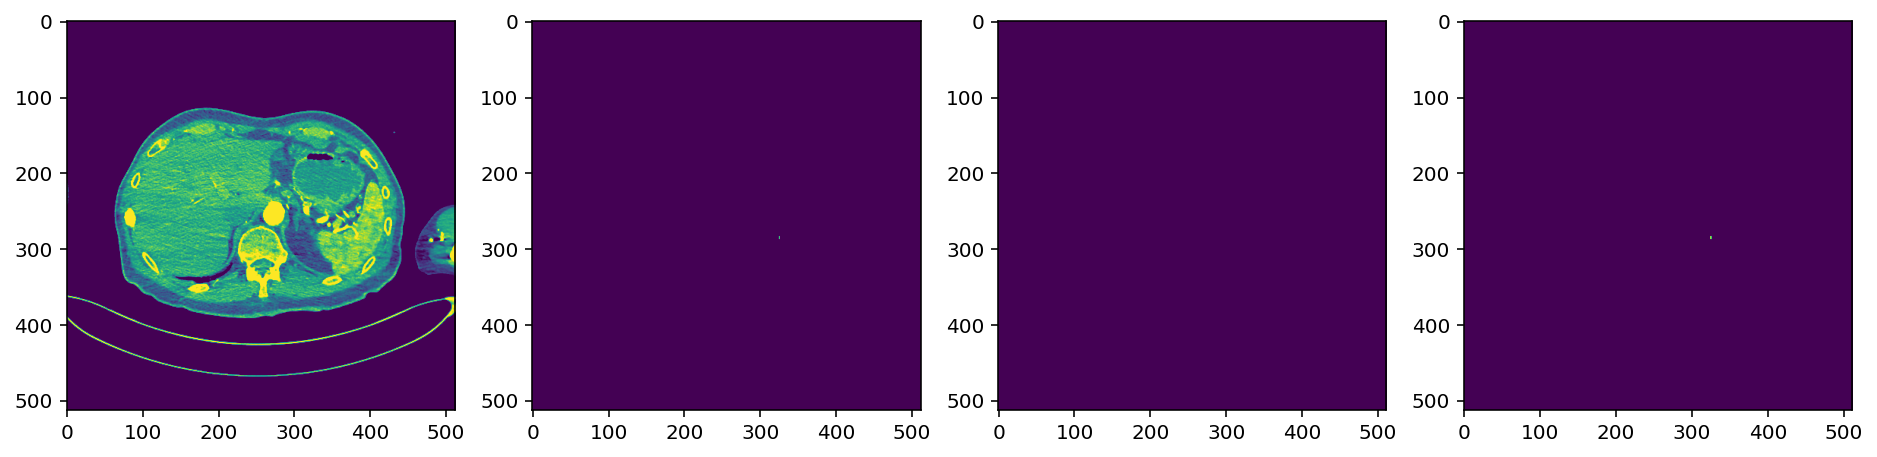

In [28]:
images,labels,a = next(iter(test_loader))
print(images.shape)
print(labels.shape)
plt.figure(figsize=(16,18))
plt.subplot(1,4,1)
plt.imshow(images[0][0])
plt.subplot(1,4,2)
plt.imshow(labels[0][0])
plt.subplot(1,4,3)
plt.imshow(labels[0][1])
plt.subplot(1,4,4)
plt.imshow(a[0])
plt.show()

In [29]:
cnt =0
Iou=0
model.to(device)

with torch.no_grad(): 
        model.eval()
        for data, labels,a in tqdm(test_loader):
                data, labels = data.to(device), labels.to(device)
                logits = model(data)
                logits = logits.sigmoid()
                logits = mask_binarization(logits.detach().cpu(), 0.5)
                iouu = compute_iou(logits,labels)
                iouu=np.round(iouu,3)*100
                if np.isnan(iouu)==True:
                    iouu=100
                Iou+=iouu

                labels=labels[0].detach().cpu().numpy()
                logits=logits[0].detach().cpu().numpy()
                cnt = cnt+1

  0%|          | 0/640 [00:00<?, ?it/s]

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-inpu

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-inpu

<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-input-19-73c674567aea>:16: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union.astype(np.float32)
<ipython-inpu

In [30]:
print("Iou:",Iou/len(test_loader))

Iou: 82.2123437500001
